In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import re
import os

# Loading data

In [2]:
codigos_escolas_distritos = pd.read_parquet("data_parquet/codigos_escolas_distritos.parquet")
disciplina = pd.read_parquet("data_parquet/inflacao_disciplina.parquet")
escolas = pd.read_parquet("data_parquet/inflacao_escolas.parquet")
escolas_bins = pd.read_parquet("data_parquet/inflacao_escola_bins.parquet")
escolas_bins_anos = pd.read_parquet("data_parquet/inflacao_escola_bins_anos.parquet")
escolas_anos = pd.read_parquet("data_parquet/inflacao_escolas_anos.parquet")
distritos = pd.read_parquet("data_parquet/inflacao_distritos.parquet")

In [3]:
print(escolas_bins.head())

     GROUP  ESCOLA   INFLACAO    INF_STD  NSAMPLES  \
0  [10,20)       2  93.500000  11.096975         8   
1  [20,30)       2  81.357143   8.983807        14   
2  [30,40)       2  78.139535   9.946479        43   
3  [40,50)       2  66.636364  12.363266        66   
4  [50,60)       2  62.225806  14.526029       124   

                                        ESCOLA_DESCR ESCOLA_PUBPRIV  
0  Escola BÃ¡sica e SecundÃ¡ria de Michel Giacometti            PUB  
1  Escola BÃ¡sica e SecundÃ¡ria de Michel Giacometti            PUB  
2  Escola BÃ¡sica e SecundÃ¡ria de Michel Giacometti            PUB  
3  Escola BÃ¡sica e SecundÃ¡ria de Michel Giacometti            PUB  
4  Escola BÃ¡sica e SecundÃ¡ria de Michel Giacometti            PUB  


# Useful functions

In [4]:
def mean_and_standard_deviation_from_samples(means, stdevs, nsamples):
    N = np.sum(nsamples)
    mean = np.sum(means * nsamples) / N
    variance = 1/(N-1)*(np.sum(nsamples * (stdevs**2 + means**2))-np.sum(nsamples*stdevs**2) - N*mean**2)
    return mean, np.sqrt(variance)


# Average inflation PUB PRIV 
One must read this with a grain of salt, due to Simpson's Paradox

In [18]:
inflacao_pub_means = escolas.loc[escolas["ESCOLA_PUBPRIV"] == "PUB", "INFLACAO"]
inflacao_pub_stdevs = escolas.loc[escolas["ESCOLA_PUBPRIV"] == "PUB", "INF_STD"]
inflacao_pub_nsamples = escolas.loc[escolas["ESCOLA_PUBPRIV"] == "PUB", "NSAMPLES"]
inflacao_pub_mean, inflacao_pub_std = mean_and_standard_deviation_from_samples(inflacao_pub_means, inflacao_pub_stdevs, inflacao_pub_nsamples)

inflacao_priv_means = escolas.loc[escolas["ESCOLA_PUBPRIV"] == "PRI", "INFLACAO"]
inflacao_priv_nsamples = escolas.loc[escolas["ESCOLA_PUBPRIV"] == "PRI", "NSAMPLES"]
inflacao_priv_stdevs = escolas.loc[escolas["ESCOLA_PUBPRIV"] == "PRI", "INF_STD"]
inflacao_priv_mean, inflacao_priv_std = mean_and_standard_deviation_from_samples(inflacao_priv_means, inflacao_priv_stdevs, inflacao_priv_nsamples)

print("Inflacao escolas publicas: ", inflacao_pub_mean, inflacao_pub_std)
print("Inflacao escolas privadas: ", inflacao_priv_mean, inflacao_priv_std)

Inflacao escolas publicas:  29.408680218361564 6.340472890542922
Inflacao escolas privadas:  27.57753417621032 11.251472661947341


Plot saved to figtabs/inflacao_pub_priv_pt.png
Plot saved to figtabs/inflacao_pub_priv_en.png


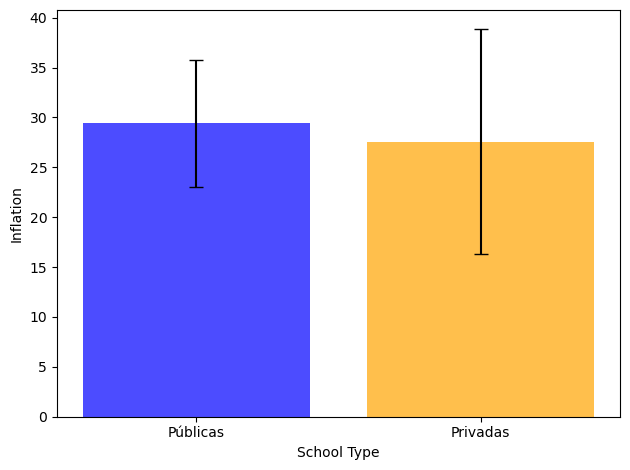

In [20]:
means = [inflacao_pub_mean, inflacao_priv_mean]
std_devs = [inflacao_pub_std, inflacao_priv_std]
labels = ['Públicas', 'Privadas']

# Create a bar plot with error bars
plt.bar(labels, means, yerr=std_devs, capsize=5, color=['blue', 'orange'], alpha=0.7)

# Portuguese labels and title
plt.xlabel("Tipo de Escola")
plt.ylabel("Inflação")
#plt.title("Inflação nas Escolas Públicas e Privadas")

# Ensure the folder exists
output_folder = "figtabs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Adjust layout and save the plot with Portuguese labels
plt.tight_layout()
output_path_pt = os.path.join(output_folder, "inflacao_pub_priv_pt.png")
plt.savefig(output_path_pt)
print(f"Plot saved to {output_path_pt}")

# Update labels and title to English
plt.xlabel("School Type")
plt.ylabel("Inflation")
#plt.title("Inflation in Public and Private Schools")

# Adjust layout and save the plot with English labels
plt.tight_layout()
output_path_en = os.path.join(output_folder, "inflacao_pub_priv_en.png")
plt.savefig(output_path_en)
print(f"Plot saved to {output_path_en}")

# Show the plot
plt.show()

Indeed, full averages dont capture any inflation. But students in private schools are disproportionately in higher grades on exams, which necessarily means less inflation. The "quality of student" is a confounder here, and this is a prototypical instance of Simpson's Paradox. Instead, we should compare per exam class, the difference between the two.

# Histogram of inflation for public versus private school, per class of exam grades

In [12]:
def welch_test(mean_pub, se_pub, n_pub, mean_priv, se_priv, n_priv):
    """
    Perform Welch's t-test using pooled mean and standard error for two groups.
    
    Parameters:
        mean_pub  (float): Mean inflation for public schools in the bin
        se_pub    (float): Standard error of the mean for public schools
        n_pub     (int)  : Total number of students in public schools (used for df)
        mean_priv (float): Mean inflation for private schools in the bin
        se_priv   (float): Standard error of the mean for private schools
        n_priv    (int)  : Total number of students in private schools

    Returns:
        t_stat (float): Welch's t-statistic
        df     (float): Degrees of freedom
        p_val  (float): Two-sided p-value
    """
    # Difference in means and its standard error
    diff = mean_pub - mean_priv
    se_pub = se_pub / np.sqrt(n_pub)
    se_priv = se_priv / np.sqrt(n_priv)
    se_diff = np.sqrt(se_pub**2 + se_priv**2)

    # Welch–Satterthwaite degrees of freedom
    numerator = (se_pub**2 + se_priv**2)**2
    denominator = (se_pub**4 / (n_pub - 1)) + (se_priv**4 / (n_priv - 1))
    df = numerator / denominator if denominator != 0 else np.nan

    # t-statistic and p-value
    t_stat = diff / se_diff if se_diff != 0 else np.nan
    p_val = 2 * stats.t.sf(abs(t_stat), df) if not np.isnan(t_stat) and not np.isnan(df) else np.nan

    return t_stat, df, p_val

Plot saved to figtabs/inflacao_bins_pub_priv_pt.png
Plot saved to figtabs/inflacao_bins_pub_priv_en.png


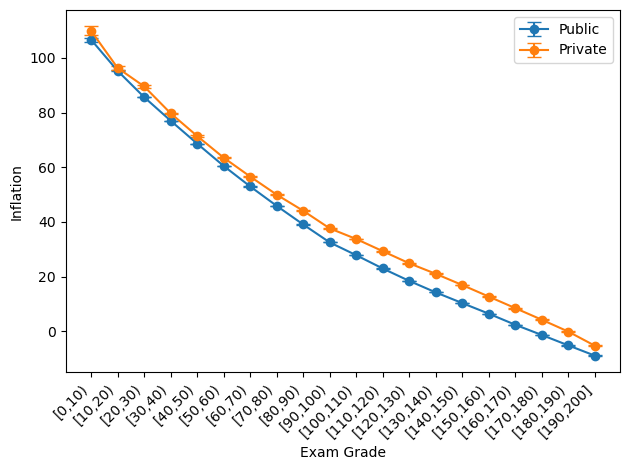

In [16]:
grade_classes = escolas_bins["GROUP"].cat.categories
inflacao_priv_means_list = []
inflacao_pub_means_list = []
inflacao_priv_stdevs_list = []
inflacao_pub_stdevs_list = []
inflacao_priv_CI_list = []
inflacao_pub_CI_list = []
welsh_t_test_list = []
welsh_t_test_pvalues = []
for grade_class in grade_classes:
    inflacao_pub_means = escolas_bins.loc[(escolas_bins["ESCOLA_PUBPRIV"] == "PUB") & (escolas_bins["GROUP"] == grade_class), "INFLACAO"]
    inflacao_pub_stdevs = escolas_bins.loc[(escolas_bins["ESCOLA_PUBPRIV"] == "PUB") & (escolas_bins["GROUP"] == grade_class), "INF_STD"]
    inflacao_pub_nsamples = escolas_bins.loc[(escolas_bins["ESCOLA_PUBPRIV"] == "PUB") & (escolas_bins["GROUP"] == grade_class), "NSAMPLES"]
    inflacao_priv_means = escolas_bins.loc[(escolas_bins["ESCOLA_PUBPRIV"] == "PRI") & (escolas_bins["GROUP"] == grade_class), "INFLACAO"]
    inflacao_priv_stdevs = escolas_bins.loc[(escolas_bins["ESCOLA_PUBPRIV"] == "PRI") & (escolas_bins["GROUP"] == grade_class), "INF_STD"]
    inflacao_priv_nsamples = escolas_bins.loc[(escolas_bins["ESCOLA_PUBPRIV"] == "PRI") & (escolas_bins["GROUP"] == grade_class), "NSAMPLES"]
    inflacao_pub_mean, inflacao_pub_std = mean_and_standard_deviation_from_samples(inflacao_pub_means, inflacao_pub_stdevs, inflacao_pub_nsamples)
    inflacao_priv_mean, inflacao_priv_std = mean_and_standard_deviation_from_samples(inflacao_priv_means, inflacao_priv_stdevs, inflacao_priv_nsamples)
    inflacao_pub_means_list.append(inflacao_pub_mean)
    inflacao_priv_means_list.append(inflacao_priv_mean)
    inflacao_pub_stdevs_list.append(inflacao_pub_std)
    inflacao_priv_stdevs_list.append(inflacao_priv_std)
    # t critical values (two-tailed, 95%)
    t_pub = stats.t.ppf(0.975, df=np.sum(inflacao_pub_nsamples) - 1)
    t_priv = stats.t.ppf(0.975, df=np.sum(inflacao_priv_nsamples) - 1)
    inflacao_pub_CI=t_pub*inflacao_pub_std/np.sqrt(np.sum(inflacao_pub_nsamples))
    inflacao_priv_CI=t_priv*inflacao_priv_std/np.sqrt(np.sum(inflacao_priv_nsamples))
    inflacao_pub_CI_list.append(inflacao_pub_CI)
    inflacao_priv_CI_list.append(inflacao_priv_CI)
    t_stat, df, p_val = welch_test(inflacao_pub_mean, inflacao_pub_std, np.sum(inflacao_pub_nsamples), inflacao_priv_mean, inflacao_priv_std, np.sum(inflacao_priv_nsamples))
    welsh_t_test_list.append(t_stat)
    welsh_t_test_pvalues.append(p_val)


x = np.arange(len(grade_classes))




# Plotting with error bars
plt.errorbar(x, inflacao_pub_means_list, yerr=inflacao_pub_CI_list, label="Públicas", fmt='-o', capsize=5)
plt.errorbar(x, inflacao_priv_means_list, yerr=inflacao_priv_CI_list, label="Privadas", fmt='-o', capsize=5)

plt.xticks(ticks=x, labels=[str(label) for label in grade_classes], rotation=45, ha='right')


# Portuguese labels and title
plt.xlabel("Nota Exame")
plt.ylabel("Inflação")
#plt.title("Inflação nas Escolas Públicas e Privadas por Nota")
plt.legend()

# Ensure the folder exists
output_folder = "figtabs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Adjust layout to prevent cutting off
plt.tight_layout()

# Save the plot with Portuguese labels
output_path_pt = os.path.join(output_folder, "inflacao_bins_pub_priv_pt.png")
plt.savefig(output_path_pt)
print(f"Plot saved to {output_path_pt}")

# Update labels and title to English
plt.xlabel("Exam Grade")
plt.ylabel("Inflation")
#plt.title("Inflation in Public and Private Schools by Grade")
plt.legend(["Public", "Private"])  # Update legend labels to English

# Adjust layout again after updating labels
plt.tight_layout()

# Save the plot with English labels
output_path_en = os.path.join(output_folder, "inflacao_bins_pub_priv_en.png")
plt.savefig(output_path_en)
print(f"Plot saved to {output_path_en}")

# Show the plot
plt.show()


Just checking number of samples per bin

In [16]:
# number of samples per bin in the above plot
for grade_class in grade_classes:
    inflacao_pub_nsamples = escolas_bins.loc[(escolas_bins["ESCOLA_PUBPRIV"] == "PUB") & (escolas_bins["GROUP"] == grade_class), "NSAMPLES"]
    inflacao_priv_nsamples = escolas_bins.loc[(escolas_bins["ESCOLA_PUBPRIV"] == "PRI") & (escolas_bins["GROUP"] == grade_class), "NSAMPLES"]
    print("Grupo: ", grade_class, "N publicas: ", np.sum(inflacao_pub_nsamples), "N privadas: ", np.sum(inflacao_priv_nsamples))

Grupo:  [10.0, 20.0) N publicas:  3766 N privadas:  311
Grupo:  [20.0, 30.0) N publicas:  10473 N privadas:  901
Grupo:  [30.0, 40.0) N publicas:  22183 N privadas:  1876
Grupo:  [40.0, 50.0) N publicas:  38709 N privadas:  3344
Grupo:  [50.0, 60.0) N publicas:  58497 N privadas:  5246
Grupo:  [60.0, 70.0) N publicas:  78378 N privadas:  7117
Grupo:  [70.0, 80.0) N publicas:  95350 N privadas:  8764
Grupo:  [80.0, 90.0) N publicas:  104635 N privadas:  10596
Grupo:  [90.0, 100.0) N publicas:  112480 N privadas:  12049
Grupo:  [100.0, 110.0) N publicas:  120055 N privadas:  13873
Grupo:  [110.0, 120.0) N publicas:  110405 N privadas:  14091
Grupo:  [120.0, 130.0) N publicas:  101674 N privadas:  14533
Grupo:  [130.0, 140.0) N publicas:  89793 N privadas:  14660
Grupo:  [140.0, 150.0) N publicas:  77505 N privadas:  14640
Grupo:  [150.0, 160.0) N publicas:  63298 N privadas:  13484
Grupo:  [160.0, 170.0) N publicas:  48744 N privadas:  11897
Grupo:  [170.0, 180.0) N publicas:  35924 N pr

Printing welsh t-test result

In [17]:
for i, grade_class in enumerate(grade_classes):
    print("Grupo: ", grade_class, "t-statistic: ", welsh_t_test_list[i], "p-value: ", welsh_t_test_pvalues[i])
    if welsh_t_test_pvalues[i] < 0.05:
        print("Grupo: ", grade_class, "t-statistic: ", welsh_t_test_list[i], "p-value: ", welsh_t_test_pvalues[i], " -> Rejeita H0")
    else:
        print("Grupo: ", grade_class, "t-statistic: ", welsh_t_test_list[i], "p-value: ", welsh_t_test_pvalues[i], " -> Não rejeita H0")
   


Grupo:  [10.0, 20.0) t-statistic:  -2.5503675659539273 p-value:  0.011176736779907406
Grupo:  [10.0, 20.0) t-statistic:  -2.5503675659539273 p-value:  0.011176736779907406  -> Rejeita H0
Grupo:  [20.0, 30.0) t-statistic:  -16.95123454261108 p-value:  1.257600586420034e-56
Grupo:  [20.0, 30.0) t-statistic:  -16.95123454261108 p-value:  1.257600586420034e-56  -> Rejeita H0
Grupo:  [30.0, 40.0) t-statistic:  -18.347134645677176 p-value:  1.3042550104238441e-69
Grupo:  [30.0, 40.0) t-statistic:  -18.347134645677176 p-value:  1.3042550104238441e-69  -> Rejeita H0
Grupo:  [40.0, 50.0) t-statistic:  -26.80977695445016 p-value:  2.837807218774836e-144
Grupo:  [40.0, 50.0) t-statistic:  -26.80977695445016 p-value:  2.837807218774836e-144  -> Rejeita H0
Grupo:  [50.0, 60.0) t-statistic:  -33.95762842338714 p-value:  1.2470785451558137e-229
Grupo:  [50.0, 60.0) t-statistic:  -33.95762842338714 p-value:  1.2470785451558137e-229  -> Rejeita H0
Grupo:  [60.0, 70.0) t-statistic:  -43.934996126955994 

Plotting the difference

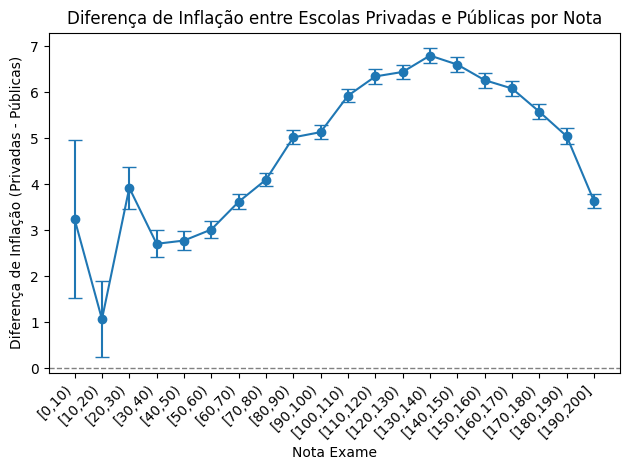

In [37]:
grade_classes = escolas_bins["GROUP"].cat.categories
inflacao_diff_list = []
inflacao_diff_CI_list = []

for grade_class in grade_classes:
    # Get all values per school
    inflacao_pub_means = escolas_bins.loc[(escolas_bins["ESCOLA_PUBPRIV"] == "PUB") & (escolas_bins["GROUP"] == grade_class), "INFLACAO"]
    inflacao_pub_stdevs = escolas_bins.loc[(escolas_bins["ESCOLA_PUBPRIV"] == "PUB") & (escolas_bins["GROUP"] == grade_class), "INF_STD"]
    inflacao_pub_nsamples = escolas_bins.loc[(escolas_bins["ESCOLA_PUBPRIV"] == "PUB") & (escolas_bins["GROUP"] == grade_class), "NSAMPLES"]
    inflacao_priv_means = escolas_bins.loc[(escolas_bins["ESCOLA_PUBPRIV"] == "PRI") & (escolas_bins["GROUP"] == grade_class), "INFLACAO"]
    inflacao_priv_stdevs = escolas_bins.loc[(escolas_bins["ESCOLA_PUBPRIV"] == "PRI") & (escolas_bins["GROUP"] == grade_class), "INF_STD"]
    inflacao_priv_nsamples = escolas_bins.loc[(escolas_bins["ESCOLA_PUBPRIV"] == "PRI") & (escolas_bins["GROUP"] == grade_class), "NSAMPLES"]

    # Pooled stats
    mean_pub, std_pub = mean_and_standard_deviation_from_samples(inflacao_pub_means, inflacao_pub_stdevs, inflacao_pub_nsamples)
    mean_priv, std_priv = mean_and_standard_deviation_from_samples(inflacao_priv_means, inflacao_priv_stdevs, inflacao_priv_nsamples)
    n_pub = np.sum(inflacao_pub_nsamples)
    n_priv = np.sum(inflacao_priv_nsamples)

    # Difference and standard error
    diff = mean_priv - mean_pub
    se_diff = np.sqrt((std_pub**2 / n_pub) + (std_priv**2 / n_priv))

    # Degrees of freedom (Welch–Satterthwaite)
    df = (std_pub**2 / n_pub + std_priv**2 / n_priv)**2 / (
        ((std_pub**2 / n_pub)**2 / (n_pub - 1)) + ((std_priv**2 / n_priv)**2 / (n_priv - 1))
    )

    # 95% CI on the difference
    t_crit = stats.t.ppf(0.975, df)
    ci_diff = t_crit * se_diff

    # Save results
    inflacao_diff_list.append(diff)
    inflacao_diff_CI_list.append(ci_diff)

# Plotting
x = np.arange(len(grade_classes))
plt.errorbar(x, inflacao_diff_list, yerr=inflacao_diff_CI_list, fmt='-o', capsize=5)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xticks(ticks=x, labels=[str(label) for label in grade_classes], rotation=45, ha='right')
plt.xlabel("Nota Exame")
plt.ylabel("Diferença de Inflação (Privadas - Públicas)")
plt.title("Diferença de Inflação entre Escolas Privadas e Públicas por Nota")
plt.tight_layout()
plt.show()


# Inflação por escola 

## Renascença-Type Plot

Número de escolas públicas:  524
Número de escolas privadas:  148
Número de bins para escolas públicas:  14
Número de bins para escolas privadas:  10


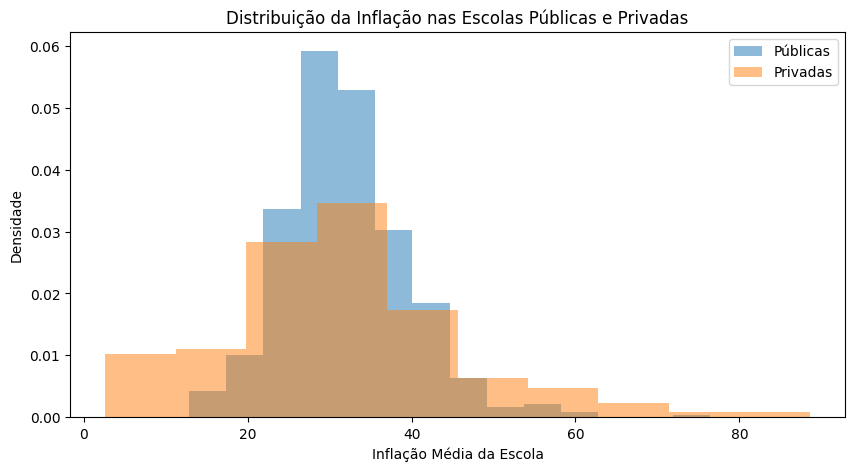

In [9]:
inflacao_pub_means = escolas.loc[escolas["ESCOLA_PUBPRIV"] == "PUB", "INFLACAO"]
inflacao_priv_means = escolas.loc[escolas["ESCOLA_PUBPRIV"] == "PRI", "INFLACAO"]

num_escolas_publicas = len(inflacao_pub_means)
num_escolas_privadas = len(inflacao_priv_means)

bin_width_pub = 1/np.sqrt(num_escolas_publicas)
bin_width_priv = 1/np.sqrt(num_escolas_privadas)
bins_pub = int((inflacao_pub_means.max() - inflacao_pub_means.min()) / bin_width_pub / 100)
bins_priv = int((inflacao_priv_means.max() - inflacao_priv_means.min()) / bin_width_priv / 100)

print("Número de escolas públicas: ", num_escolas_publicas)
print("Número de escolas privadas: ", num_escolas_privadas)
print("Número de bins para escolas públicas: ", bins_pub)
print("Número de bins para escolas privadas: ", bins_priv)

## Plot histogramas
plt.figure(figsize=(10, 5))
plt.hist(inflacao_pub_means, bins=bins_pub, alpha=0.5, label='Públicas', density=True)
plt.hist(inflacao_priv_means, bins=bins_priv, alpha=0.5, label='Privadas', density=True)
plt.xlabel("Inflação Média da Escola")
plt.ylabel("Densidade")
plt.title("Distribuição da Inflação nas Escolas Públicas e Privadas")
plt.legend()

Número de escolas públicas:  524
Número de escolas privadas:  148
Número de bins para escolas públicas:  14
Número de bins para escolas privadas:  10


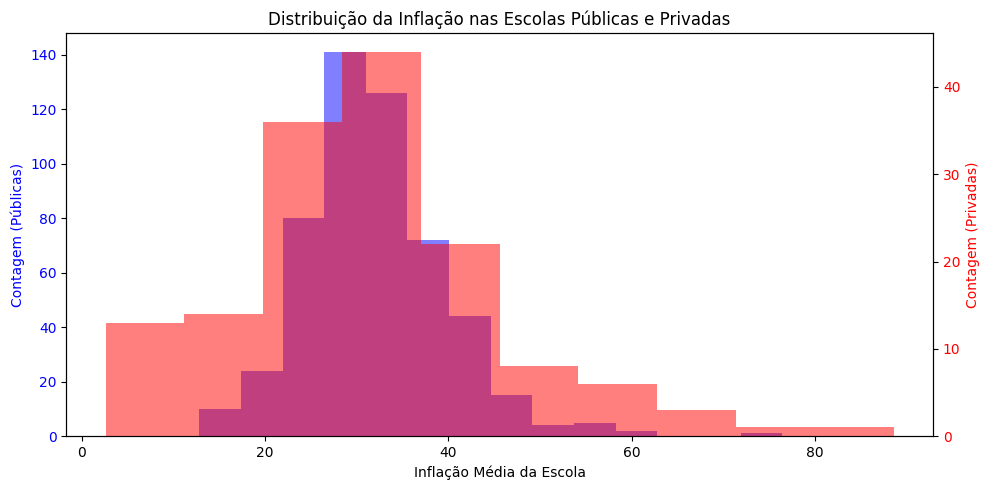

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Separate data
inflacao_pub_means = escolas.loc[escolas["ESCOLA_PUBPRIV"] == "PUB", "INFLACAO"]
inflacao_priv_means = escolas.loc[escolas["ESCOLA_PUBPRIV"] == "PRI", "INFLACAO"]

# Number of schools
num_escolas_publicas = len(inflacao_pub_means)
num_escolas_privadas = len(inflacao_priv_means)

# Bin calculation
bin_width_pub = 1 / np.sqrt(num_escolas_publicas)
bin_width_priv = 1 / np.sqrt(num_escolas_privadas)
bins_pub = int((inflacao_pub_means.max() - inflacao_pub_means.min()) / bin_width_pub / 100)
bins_priv = int((inflacao_priv_means.max() - inflacao_priv_means.min()) / bin_width_priv / 100)

print("Número de escolas públicas: ", num_escolas_publicas)
print("Número de escolas privadas: ", num_escolas_privadas)
print("Número de bins para escolas públicas: ", bins_pub)
print("Número de bins para escolas privadas: ", bins_priv)

# Create figure
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot histogram for public schools on primary y-axis
counts_pub, bins_pub_edges, _ = ax1.hist(inflacao_pub_means, bins=bins_pub, alpha=0.5, label='Públicas', color='blue')
ax1.set_xlabel("Inflação Média da Escola")
ax1.set_ylabel("Contagem (Públicas)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create secondary y-axis for private schools
ax2 = ax1.twinx()
counts_priv, bins_priv_edges, _ = ax2.hist(inflacao_priv_means, bins=bins_priv, alpha=0.5, label='Privadas', color='red')
ax2.set_ylabel("Contagem (Privadas)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and legend
plt.title("Distribuição da Inflação nas Escolas Públicas e Privadas")
fig.tight_layout()
plt.show()


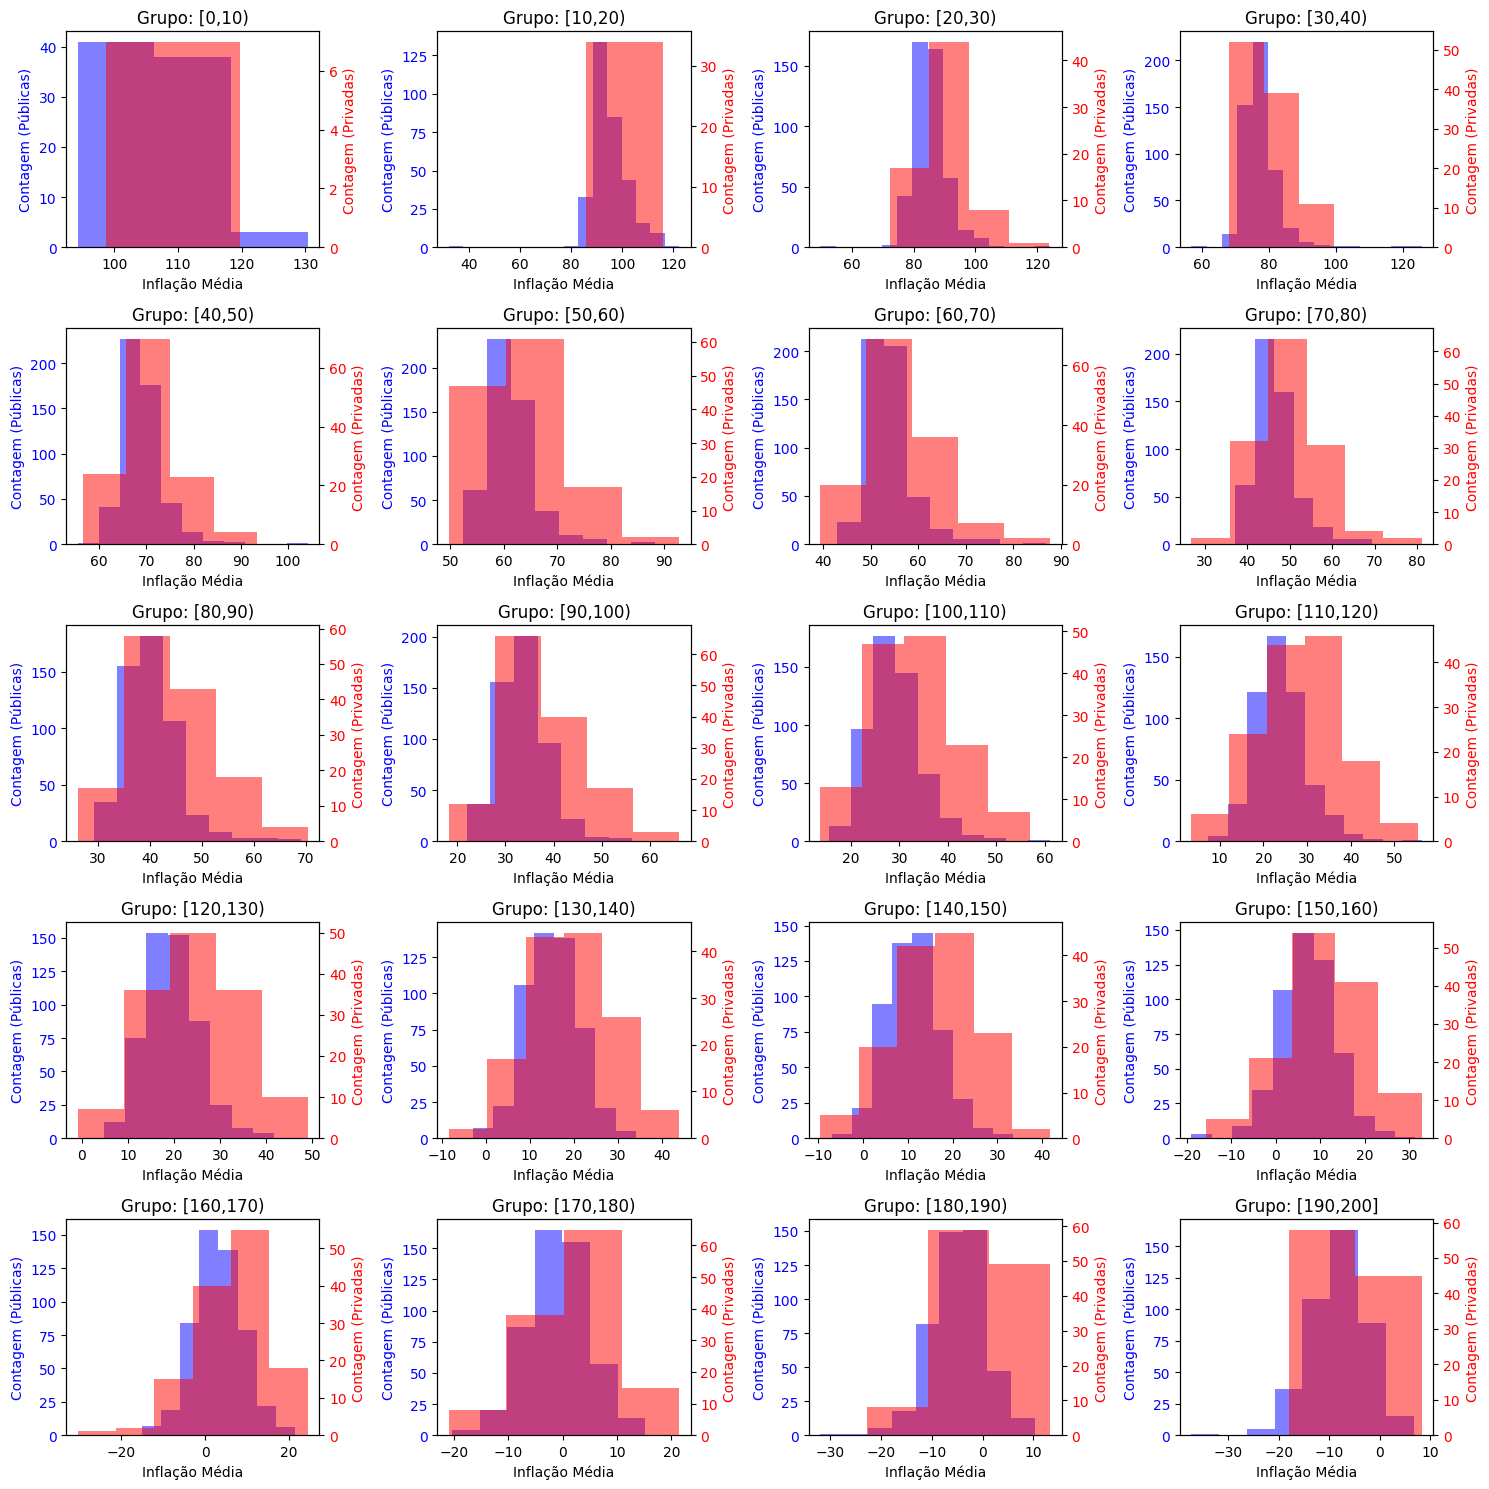

In [39]:
grade_classes = escolas_bins["GROUP"].cat.categories
num_classes = len(grade_classes)

# Define grid layout for subplots (5 rows, 4 columns)
rows, cols = 5, 4

# Create figure and subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()  # Flatten for easier iteration

for i, grade_class in enumerate(grade_classes):
    ax1 = axes[i]  # Select subplot


    inflacao_pub_means = escolas_bins.loc[(escolas_bins["ESCOLA_PUBPRIV"] == "PUB") & (escolas_bins["GROUP"] == grade_class), "INFLACAO"]
    inflacao_priv_means = escolas_bins.loc[(escolas_bins["ESCOLA_PUBPRIV"] == "PRI") & (escolas_bins["GROUP"] == grade_class), "INFLACAO"]

    # Number of schools
    num_escolas_publicas = len(inflacao_pub_means)
    num_escolas_privadas = len(inflacao_priv_means)

    # Skip empty groups
    if num_escolas_publicas == 0 and num_escolas_privadas == 0:
        continue

    # Bin calculation (handle cases where no data exists)
    bins_pub = max(1, int((inflacao_pub_means.max() - inflacao_pub_means.min()) / (1 / np.sqrt(num_escolas_publicas)) / 100)) if num_escolas_publicas > 0 else 1
    bins_priv = max(1, int((inflacao_priv_means.max() - inflacao_priv_means.min()) / (1 / np.sqrt(num_escolas_privadas)) / 100)) if num_escolas_privadas > 0 else 1

    # Plot histogram for public schools
    counts_pub, bins_pub_edges, _ = ax1.hist(inflacao_pub_means, bins=bins_pub, alpha=0.5, label='Públicas', color='blue')

    # Create secondary y-axis for private schools
    ax2 = ax1.twinx()
    counts_priv, bins_priv_edges, _ = ax2.hist(inflacao_priv_means, bins=bins_priv, alpha=0.5, label='Privadas', color='red')

    # Labels and titles
    ax1.set_title(f"Grupo: {grade_class}")
    ax1.set_xlabel("Inflação Média")
    ax1.set_ylabel("Contagem (Públicas)", color='blue')
    ax2.set_ylabel("Contagem (Privadas)", color='red')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='red')

# Adjust layout
plt.tight_layout()
plt.show()

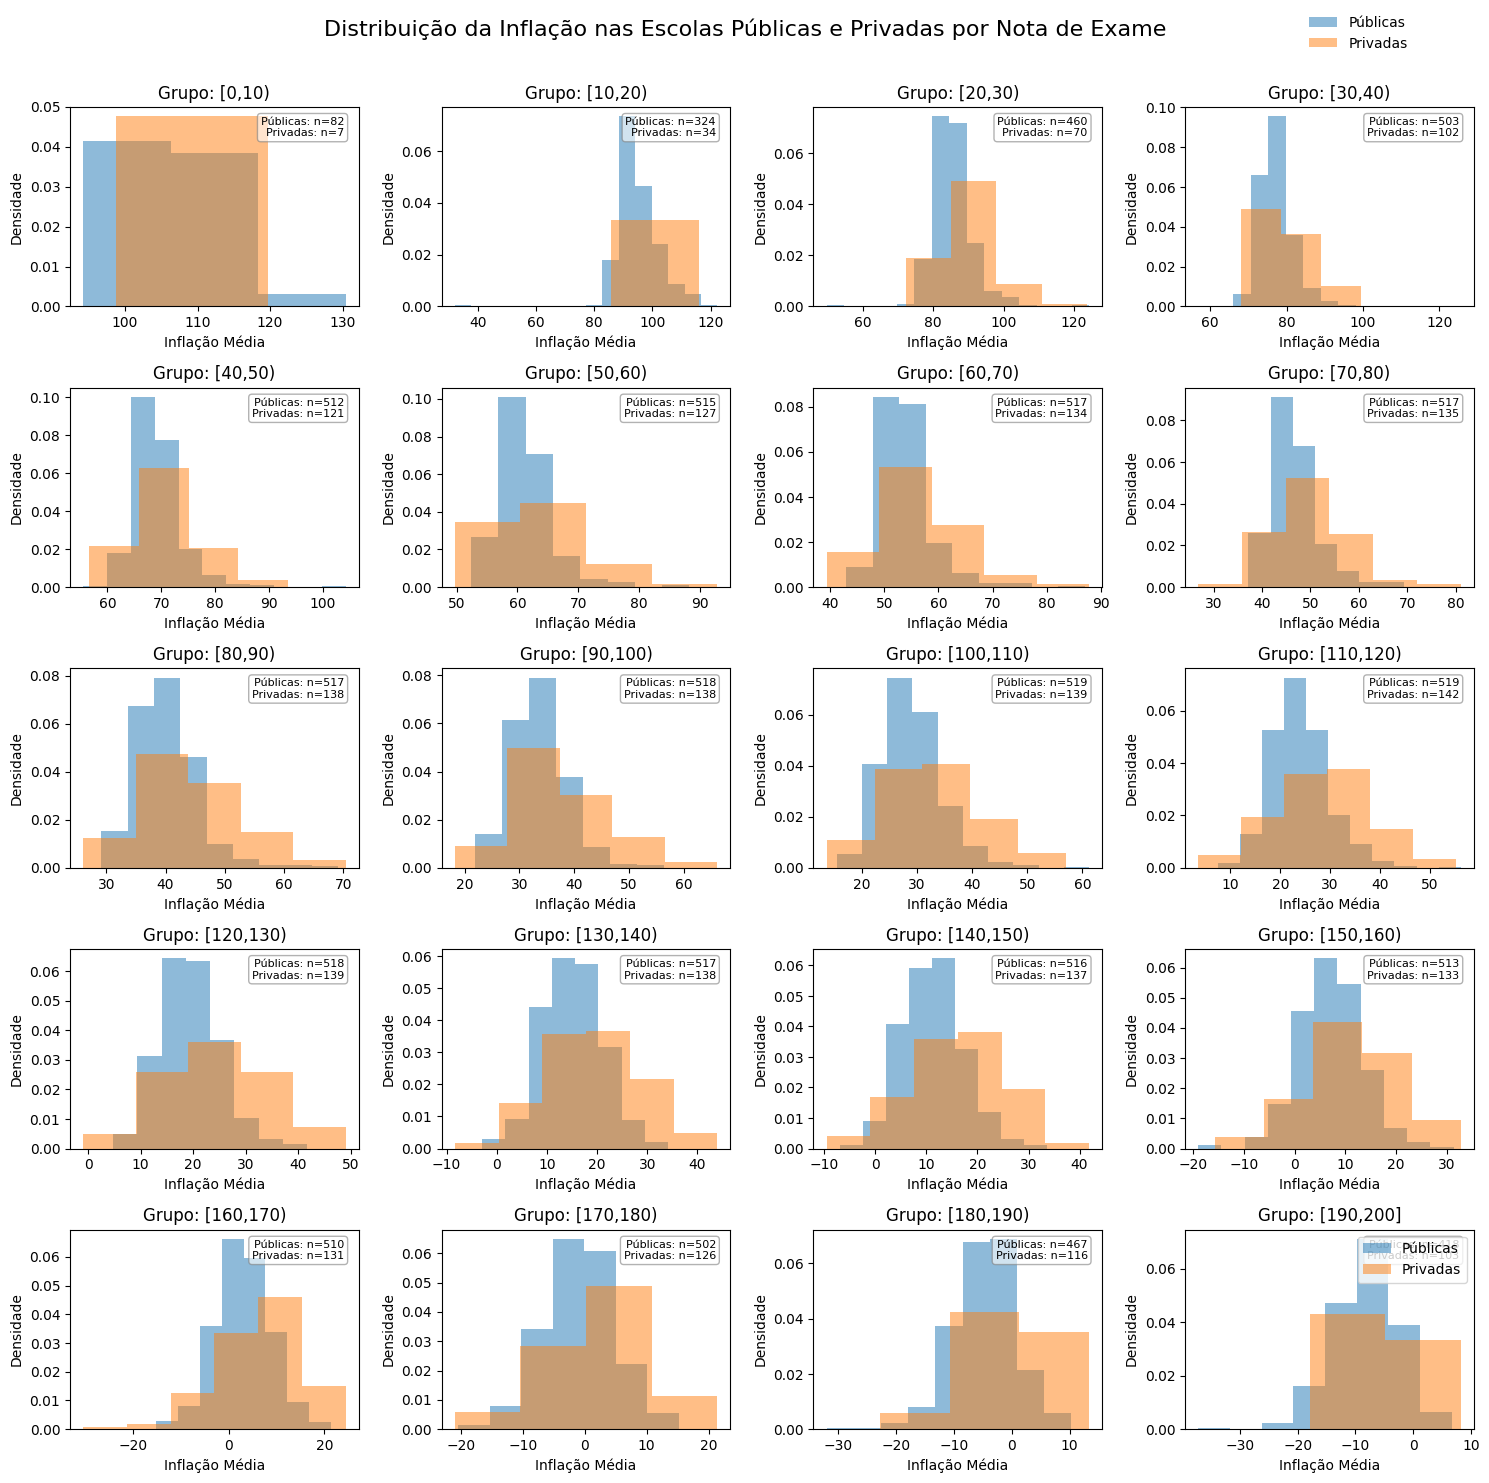

In [49]:
# Unique grade classes
grade_classes = escolas_bins["GROUP"].cat.categories
num_classes = len(grade_classes)

# Define grid layout for subplots (5 rows, 4 columns)
rows, cols = 5, 4

# Create figure and subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()  # Flatten for easier iteration

for i, grade_class in enumerate(grade_classes):
    ax = axes[i]  # Select subplot

    # Filter data
    inflacao_pub_means = escolas_bins.loc[
        (escolas_bins["ESCOLA_PUBPRIV"] == "PUB") & (escolas_bins["GROUP"] == grade_class), "INFLACAO"
    ]
    inflacao_priv_means = escolas_bins.loc[
        (escolas_bins["ESCOLA_PUBPRIV"] == "PRI") & (escolas_bins["GROUP"] == grade_class), "INFLACAO"
    ]

    n_pub = len(inflacao_pub_means)
    n_priv = len(inflacao_priv_means)

    # Skip empty groups
    if len(inflacao_pub_means) == 0 and len(inflacao_priv_means) == 0:
        ax.set_title(f"Grupo: {grade_class} (Sem dados)")
        ax.axis("off")
        continue

    # Bin calculation (handle cases where no data exists)
    bins_pub = max(1, int((inflacao_pub_means.max() - inflacao_pub_means.min()) / (1 / np.sqrt(len(inflacao_pub_means))) / 100)) if len(inflacao_pub_means) > 0 else 1
    bins_priv = max(1, int((inflacao_priv_means.max() - inflacao_priv_means.min()) / (1 / np.sqrt(len(inflacao_priv_means))) / 100)) if len(inflacao_priv_means) > 0 else 1

    # Plot normalized histograms (density=True)
    ax.hist(inflacao_pub_means, bins=bins_pub, alpha=0.5, label="Públicas", density=True)
    ax.hist(inflacao_priv_means, bins=bins_priv, alpha=0.5, label="Privadas",density=True)

    ax.text(
    0.95, 0.95,
    f"Públicas: n={n_pub}\nPrivadas: n={n_priv}",
    transform=ax.transAxes,
    ha='right', va='top',
    fontsize=8,
    bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.6)
)


    # Labels and titles
    ax.set_title(f"Grupo: {grade_class}")
    ax.set_xlabel("Inflação Média")
    ax.set_ylabel("Densidade")

# Adjust layout
fig.legend(
    labels=["Públicas", "Privadas"],
    loc='upper right',
    bbox_to_anchor=(0.95, 0.99),  # X, Y in figure coordinates
    frameon=False
)
plt.legend(loc='upper right')
plt.suptitle("Distribuição da Inflação nas Escolas Públicas e Privadas por Nota de Exame", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # leaves space for suptitle above
plt.show()


Better plots

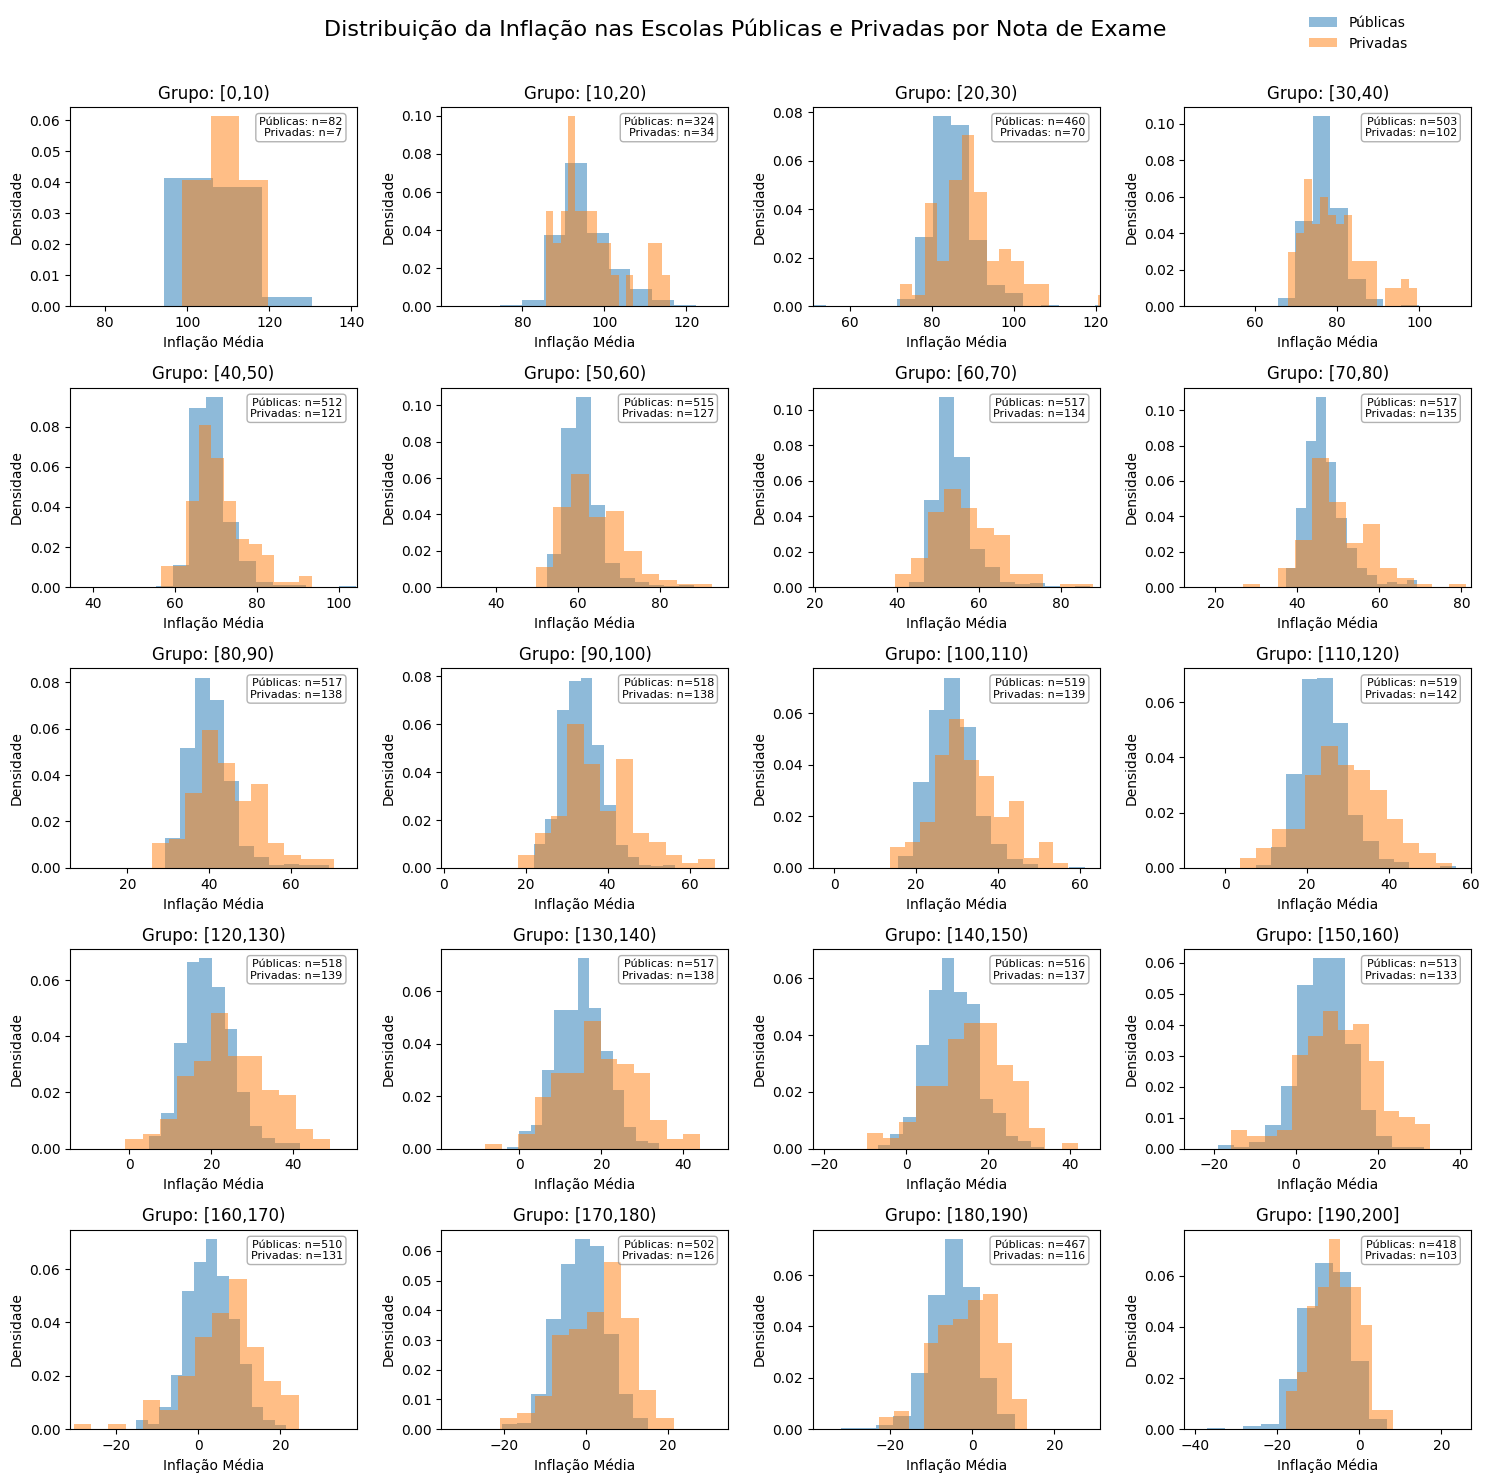

In [59]:
 #Unique grade classes
grade_classes = escolas_bins["GROUP"].cat.categories
num_classes = len(grade_classes)


# Define grid layout for subplots (5 rows, 4 columns)
rows, cols = 5, 4

# Create figure and subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()  # Flatten for easier iteration

for i, grade_class in enumerate(grade_classes):
    ax = axes[i]  # Select subplot

    # Filter data
    inflacao_pub_means = escolas_bins.loc[
        (escolas_bins["ESCOLA_PUBPRIV"] == "PUB") & (escolas_bins["GROUP"] == grade_class), "INFLACAO"
    ]
    inflacao_priv_means = escolas_bins.loc[
        (escolas_bins["ESCOLA_PUBPRIV"] == "PRI") & (escolas_bins["GROUP"] == grade_class), "INFLACAO"
    ]

    n_pub = len(inflacao_pub_means)
    n_priv = len(inflacao_priv_means)

    all_data = pd.concat([inflacao_pub_means, inflacao_priv_means])
    data_mean = all_data.mean()
    span = 70  # or choose a consistent value that fits all

    # Skip empty groups
    if len(inflacao_pub_means) == 0 and len(inflacao_priv_means) == 0:
        ax.set_title(f"Grupo: {grade_class} (Sem dados)")
        ax.axis("off")
        continue

    # Bin calculation (handle cases where no data exists)
    bins = max(1, int((all_data.max() - all_data.min()) / (1 / np.sqrt(len(all_data))) / 100)) if len(all_data) > 0 else 1

    # Plot normalized histograms (density=True)
    ax.hist(inflacao_pub_means, bins=bins, alpha=0.5, label="Públicas", density=True)
    ax.hist(inflacao_priv_means, bins=bins, alpha=0.5, label="Privadas",density=True)

    ax.set_xlim(data_mean - span/2, data_mean + span/2)

    ax.text(
    0.95, 0.95,
    f"Públicas: n={n_pub}\nPrivadas: n={n_priv}",
    transform=ax.transAxes,
    ha='right', va='top',
    fontsize=8,
    bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.6)
)


    # Labels and titles
    ax.set_title(f"Grupo: {grade_class}")
    ax.set_xlabel("Inflação Média")
    ax.set_ylabel("Densidade")

# Adjust layout
fig.legend(
    labels=["Públicas", "Privadas"],
    loc='upper right',
    bbox_to_anchor=(0.95, 0.99),  # X, Y in figure coordinates
    frameon=False
)
plt.suptitle("Distribuição da Inflação nas Escolas Públicas e Privadas por Nota de Exame", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # leaves space for suptitle above
plt.show()

In [ ]:
def get_left_edge(label):
    match = re.match(r"\[(\d+(?:\.\d+)?),", label)
    return float(match.group(1)) if match else float('nan')

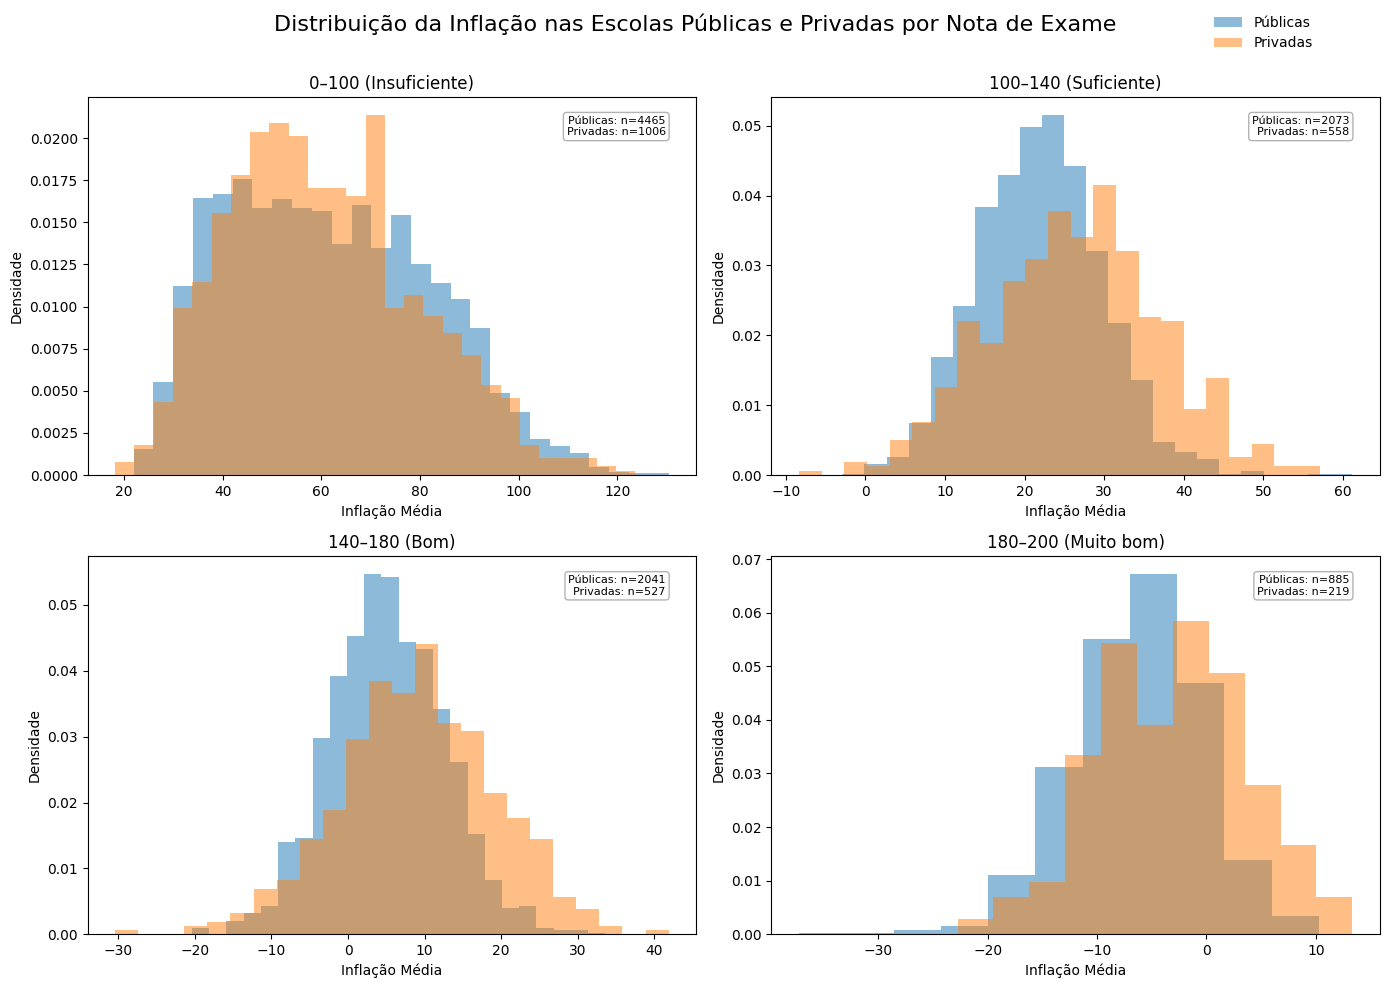

In [65]:
# Get string categories from your categorical
grade_classes = escolas_bins["GROUP"].cat.categories

# Create groupings by parsing the labels
groupings = {
    "0–100 (Insuficiente)": [g for g in grade_classes if get_left_edge(g) < 100],
    "100–140 (Suficiente)": [g for g in grade_classes if 100 <= get_left_edge(g) < 140],
    "140–180 (Bom)":        [g for g in grade_classes if 140 <= get_left_edge(g) < 180],
    "180–200 (Muito bom)":  [g for g in grade_classes if get_left_edge(g) >= 180]
}

## Create figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (label, bins) in enumerate(groupings.items()):
    ax = axes[i]

    # Filter all relevant rows for this group
    mask_pub = (escolas_bins["ESCOLA_PUBPRIV"] == "PUB") & (escolas_bins["GROUP"].isin(bins))
    mask_priv = (escolas_bins["ESCOLA_PUBPRIV"] == "PRI") & (escolas_bins["GROUP"].isin(bins))
    
    inflacao_pub_means = escolas_bins.loc[mask_pub, "INFLACAO"]
    inflacao_priv_means = escolas_bins.loc[mask_priv, "INFLACAO"]

    n_pub = len(inflacao_pub_means)
    n_priv = len(inflacao_priv_means)

    all_data = pd.concat([inflacao_pub_means, inflacao_priv_means])
    data_mean = all_data.mean()
    span = 100  # or choose a consistent value that fits all

    # Skip empty groups
    if len(inflacao_pub_means) == 0 and len(inflacao_priv_means) == 0:
        ax.set_title(f"Grupo: {grade_class} (Sem dados)")
        ax.axis("off")
        continue

    # Bin calculation (handle cases where no data exists)
    bins = max(1, int((all_data.max() - all_data.min()) / (1 / np.sqrt(len(all_data))) / 150)) if len(all_data) > 0 else 1

    if i == 0:
        bins = max(1, int((all_data.max() - all_data.min()) / (1 / np.sqrt(len(all_data))) / 300)) if len(all_data) > 0 else 1

    # Plot normalized histograms (density=True)
    ax.hist(inflacao_pub_means, bins=bins, alpha=0.5, label="Públicas", density=True)
    ax.hist(inflacao_priv_means, bins=bins, alpha=0.5, label="Privadas",density=True)

    # ax.set_xlim(data_mean - span/2, data_mean + span/2)

    ax.text(
    0.95, 0.95,
    f"Públicas: n={n_pub}\nPrivadas: n={n_priv}",
    transform=ax.transAxes,
    ha='right', va='top',
    fontsize=8,
    bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.6)
)


    # Labels and titles
    ax.set_title(label)
    ax.set_xlabel("Inflação Média")
    ax.set_ylabel("Densidade")

# Adjust layout
fig.legend(
    labels=["Públicas", "Privadas"],
    loc='upper right',
    bbox_to_anchor=(0.95, 0.99),  # X, Y in figure coordinates
    frameon=False
)
plt.suptitle("Distribuição da Inflação nas Escolas Públicas e Privadas por Nota de Exame", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # leaves space for suptitle above
plt.show()

# Reincidência

In [67]:
print(escolas_bins_anos.head())

          GROUP  ESCOLA   ANO   INFLACAO    INF_STD  NSAMPLES  \
0  [30.0, 40.0)       2  2014  73.750000   4.924429         4   
1  [40.0, 50.0)       2  2014  62.625000   4.657943         8   
2  [50.0, 60.0)       2  2014  55.000000  11.520732        12   
3  [60.0, 70.0)       2  2014  46.333333  12.804389        15   
4  [70.0, 80.0)       2  2014  40.222222  12.587472         9   

                                        ESCOLA_DESCR ESCOLA_PUBPRIV  
0  Escola BÃ¡sica e SecundÃ¡ria de Michel Giacometti            PUB  
1  Escola BÃ¡sica e SecundÃ¡ria de Michel Giacometti            PUB  
2  Escola BÃ¡sica e SecundÃ¡ria de Michel Giacometti            PUB  
3  Escola BÃ¡sica e SecundÃ¡ria de Michel Giacometti            PUB  
4  Escola BÃ¡sica e SecundÃ¡ria de Michel Giacometti            PUB  


In [68]:
print(escolas_anos.head())

   ESCOLA   ANO   INFLACAO    INF_STD  NSAMPLES  \
0       2  2014  25.248677  26.476335       189   
1      39  2014  35.550000  41.098350        40   
2      49  2014  33.449057  25.026165       265   
3      57  2014  28.392857  33.254729        28   
4      62  2014  45.120000  32.764241        50   

                                        ESCOLA_DESCR ESCOLA_PUBPRIV  
0  Escola BÃ¡sica e SecundÃ¡ria de Michel Giacometti            PUB  
1            Escola BÃ¡sica e SecundÃ¡ria de Ourique            PUB  
2  Escola BÃ¡sica e SecundÃ¡ria de Celorico de Basto            PUB  
3    Escola BÃ¡sica e SecundÃ¡ria de Terras de Bouro            PUB  
4   Escola BÃ¡sica e SecundÃ¡ria de Alfandega da FÃ©            PUB  


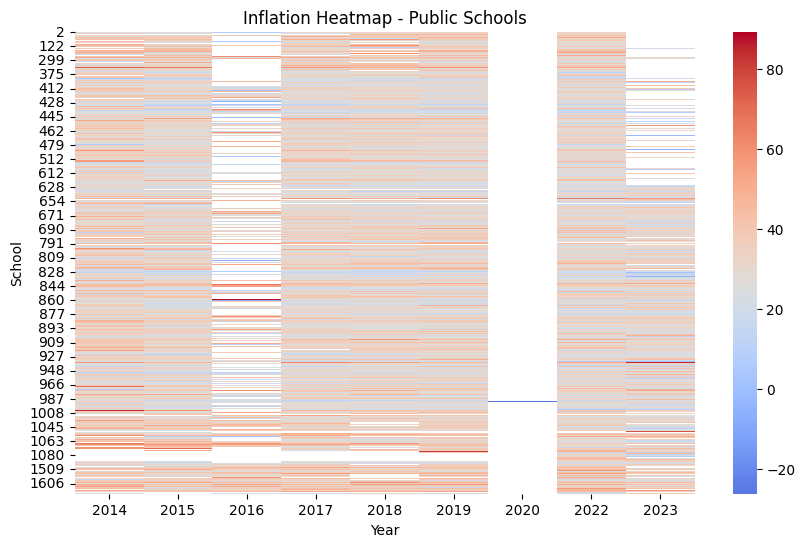

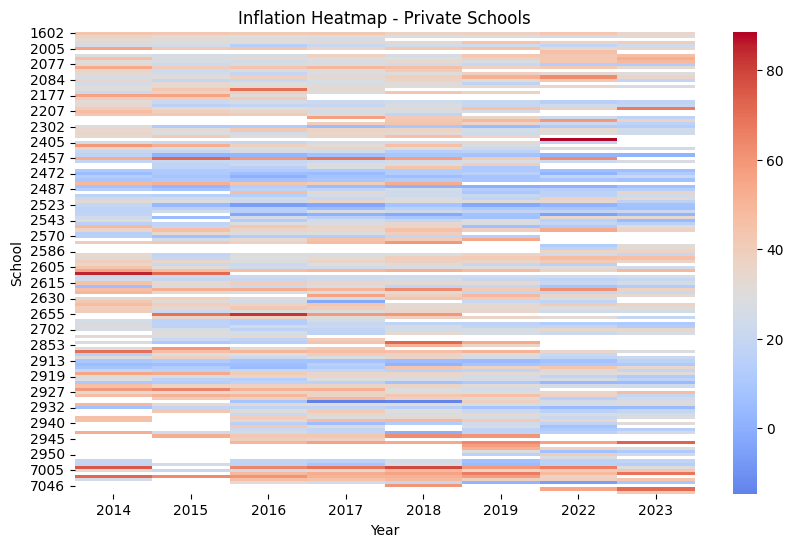

In [69]:
# Filter public schools
public_schools = escolas_anos[escolas_anos["ESCOLA_PUBPRIV"] == "PUB"]

# Filter private schools
private_schools = escolas_anos[escolas_anos["ESCOLA_PUBPRIV"] == "PRI"]

# Create pivot tables
inflation_pivot_pub = public_schools.pivot_table(index="ESCOLA", columns="ANO", values="INFLACAO", aggfunc="mean")
inflation_pivot_pri = private_schools.pivot_table(index="ESCOLA", columns="ANO", values="INFLACAO", aggfunc="mean")

# Create figure
# Create a figure for Public Schools
plt.figure(figsize=(10, 6))
sns.heatmap(
    inflation_pivot_pub, 
    cmap="coolwarm", 
    center=inflation_pivot_pub.mean().mean(), 
    annot=False
)
plt.title("Inflation Heatmap - Public Schools")
plt.xlabel("Year")
plt.ylabel("School")
plt.show()  # Show first plot

# Create a figure for Private Schools
plt.figure(figsize=(10, 6))
sns.heatmap(
    inflation_pivot_pri, 
    cmap="coolwarm", 
    center=inflation_pivot_pri.mean().mean(),  # Center based on private schools
    annot=False
)
plt.title("Inflation Heatmap - Private Schools")
plt.xlabel("Year")
plt.ylabel("School")
plt.show()  # Show second plot


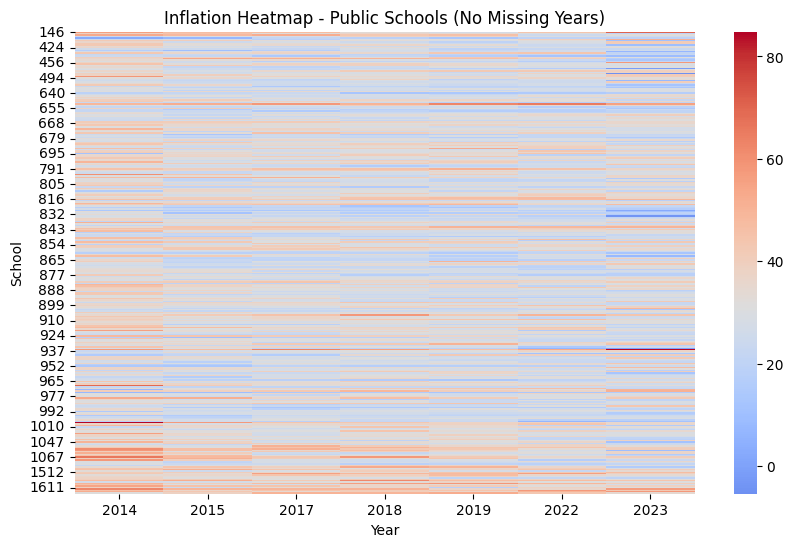

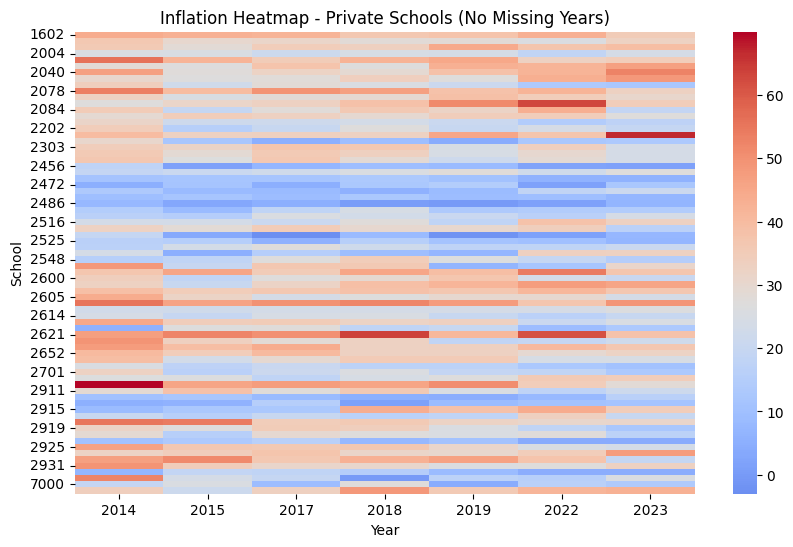

In [70]:
inflation_pivot_pub = inflation_pivot_pub.drop(columns=[2016])
inflation_pivot_pub = inflation_pivot_pub.drop(columns=[2020])
inflation_pivot_pri = inflation_pivot_pri.drop(columns=[2016]) 

# Remove schools with any missing years from both pivot tables
inflation_pivot_pub_clean = inflation_pivot_pub.dropna()
inflation_pivot_pri_clean = inflation_pivot_pri.dropna()
# Create figure for Public Schools
plt.figure(figsize=(10, 6))
sns.heatmap(
    inflation_pivot_pub_clean, 
    cmap="coolwarm", 
    center=inflation_pivot_pub_clean.mean().mean(), 
    annot=False
)
plt.title("Inflation Heatmap - Public Schools (No Missing Years)")
plt.xlabel("Year")
plt.ylabel("School")
plt.show()  # Show first plot
# Create figure for Private Schools
plt.figure(figsize=(10, 6))
sns.heatmap(
    inflation_pivot_pri_clean, 
    cmap="coolwarm", 
    center=inflation_pivot_pri_clean.mean().mean(),  # Center based on private schools
    annot=False
)
plt.title("Inflation Heatmap - Private Schools (No Missing Years)")
plt.xlabel("Year")
plt.ylabel("School")
plt.show()  # Show second plot


Which rows did I drop?

In [71]:
# Find dropped rows in public schools pivot
dropped_pub = inflation_pivot_pub[~inflation_pivot_pub.index.isin(inflation_pivot_pub_clean.index)]

# Find dropped rows in private schools pivot
dropped_pri = inflation_pivot_pri[~inflation_pivot_pri.index.isin(inflation_pivot_pri_clean.index)]

# Step 1: Get ESCOLA codes from dropped rows
# Step 1: Get ESCOLA codes from the index (since 'ESCOLA' is the index)
dropped_pub_escolas = dropped_pub.index.unique()
dropped_pri_escolas = dropped_pri.index.unique()

# Step 2: Find school names using these codes
dropped_pub_names = codigos_escolas_distritos[
    codigos_escolas_distritos['escola'].isin(dropped_pub_escolas)
]['escola_descr'].tolist()

dropped_pri_names = codigos_escolas_distritos[
    codigos_escolas_distritos['escola'].isin(dropped_pri_escolas)
]['escola_descr'].tolist()

# Step 3: Print results
print("Dropped Public School Names:")
print(dropped_pub_names)

print("number of dropped public schools: ", len(dropped_pub_names))
print("total number of public schools: ", len(codigos_escolas_distritos[codigos_escolas_distritos["escola_pubpriv"] == "PUB"]))

print("\nDropped Private School Names:")
print(dropped_pri_names)
print("number of dropped private schools: ", len(dropped_pri_names))
print("total number of private schools: ", len(codigos_escolas_distritos[codigos_escolas_distritos["escola_pubpriv"] == "PRI"]))

Dropped Public School Names:
['Escola BÃ¡sica e SecundÃ¡ria de Michel Giacometti, Sesimbra', 'Escola BÃ¡sica e SecundÃ¡ria Dr. JoÃ£o Brito Camacho, AlmodÃ´var', 'Escola BÃ¡sica e SecundÃ¡ria de Ourique', 'Escola BÃ¡sica e SecundÃ¡ria de Cabeceiras de Basto', 'Escola BÃ¡sica e SecundÃ¡ria de Celorico de Basto', 'Escola BÃ¡sica e SecundÃ¡ria de Terras de Bouro', 'Escola BÃ¡sica e SecundÃ¡ria de Alfandega da FÃ©', 'Escola BÃ¡sica e SecundÃ¡ria Pedro Ã\x81lvares Cabral, Belmonte', 'Escola BÃ¡sica e SecundÃ¡ria JosÃ© Silvestre Ribeiro, Idanha-a-Nova', 'Escola BÃ¡sica e SecundÃ¡ria Ribeiro Sanches, Penamacor', 'Escola BÃ¡sica e SecundÃ¡ria Pedro da Fonseca', 'Escola SecundÃ¡ria Fernando Namora, Condeixa-a-Nova', 'Escola BÃ¡sica e SecundÃ¡ria JosÃ© FalcÃ£o,  Miranda do Corvo', 'Escola BÃ¡sica e SecundÃ¡ria Escalada, Pampilhosa da Serra', 'Escola BÃ¡sica e SecundÃ¡ria Dr. Daniel de Matos, Vila Nova de Poiares', 'Escola BÃ¡sica e SecundÃ¡ria Cunha Rivara, Arraiolos', 'Escola BÃ¡sica e SecundÃ¡r

Let's do it better, less schools, order, get them by name

Escolas públicas:


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.draw()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 130 (\x82) missing from current font.
  fig.canvas.draw()
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 130 (\x82) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


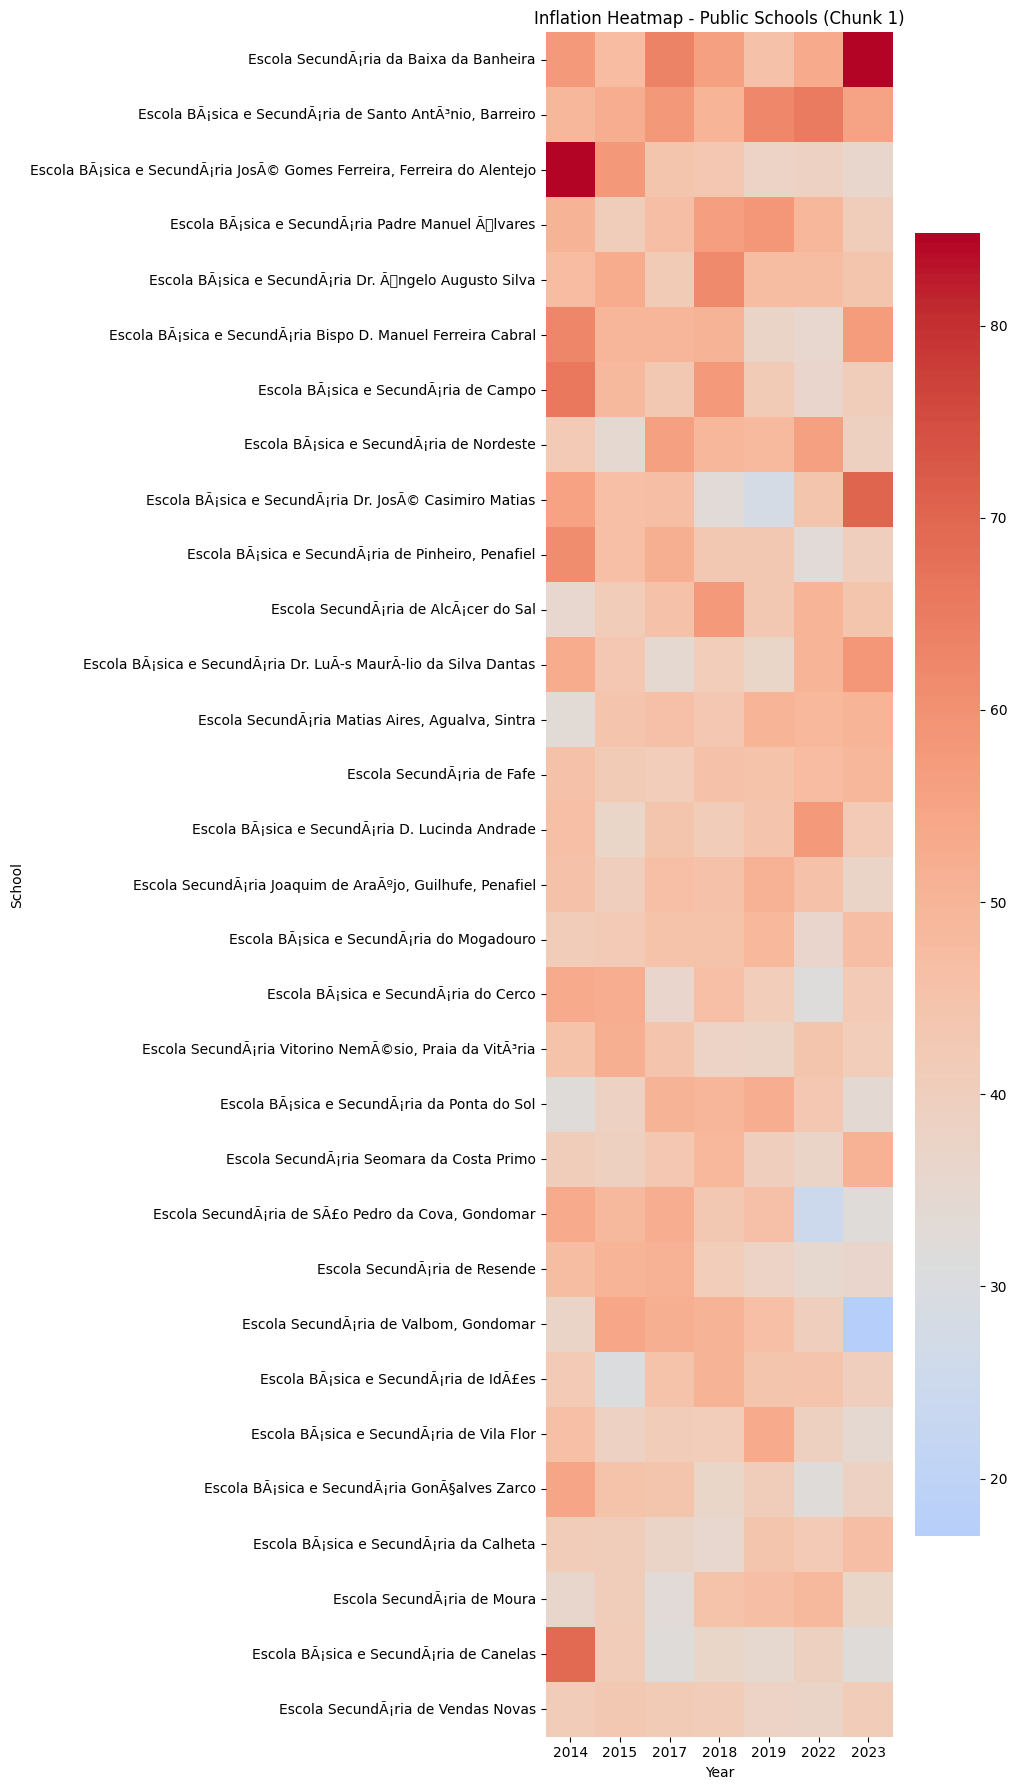

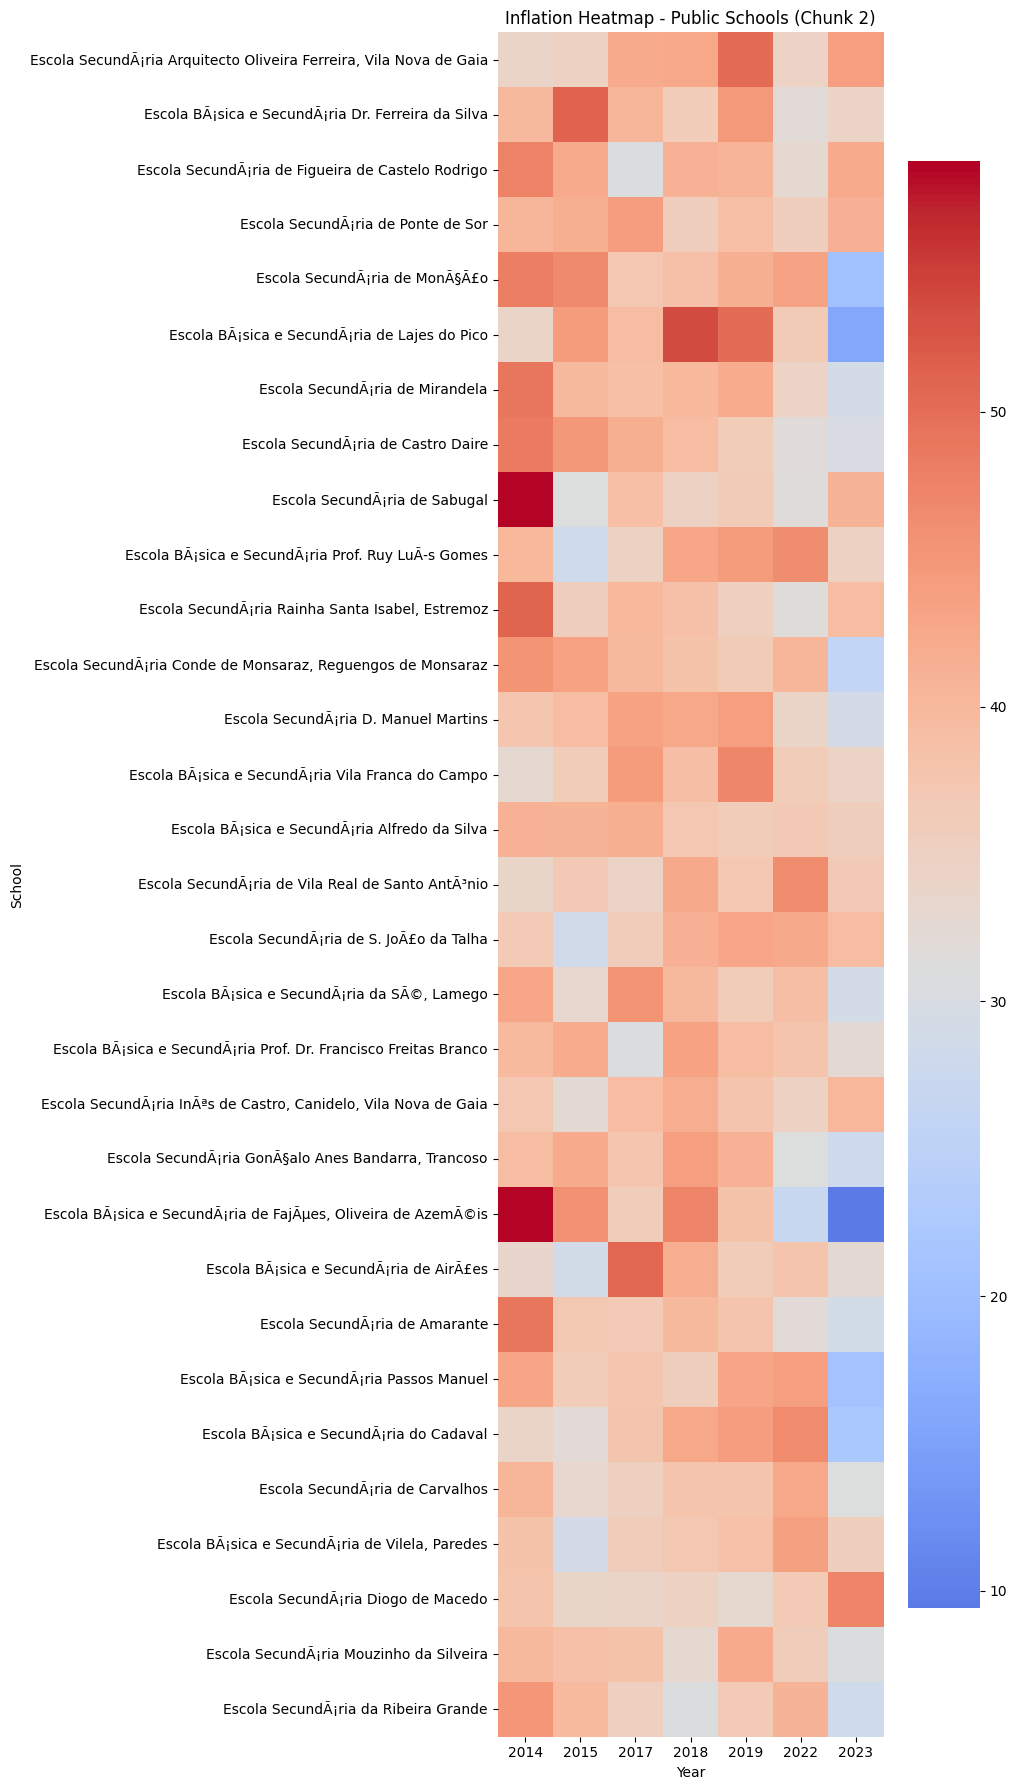

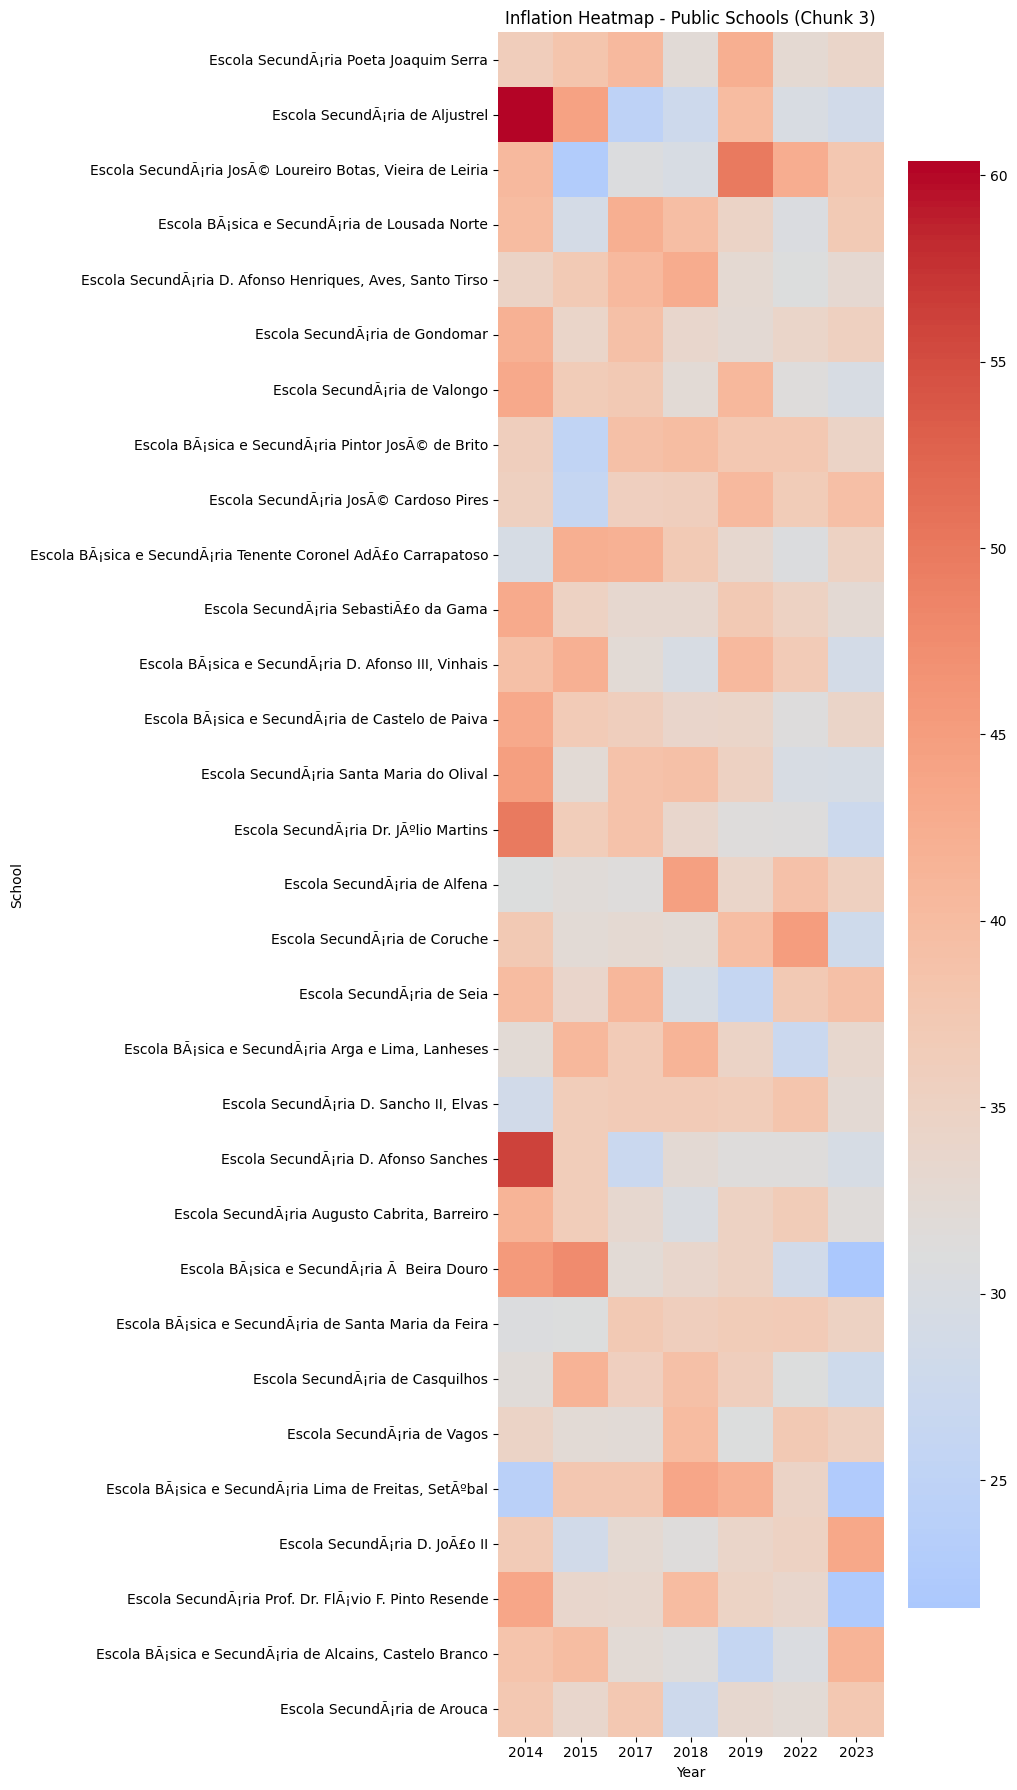

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 147 (\x93) missing from current font.
  fig.canvas.draw()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 141 (\x8d) missing from current font.
  fig.canvas.draw()
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 147 (\x93) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 141 (\x8d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


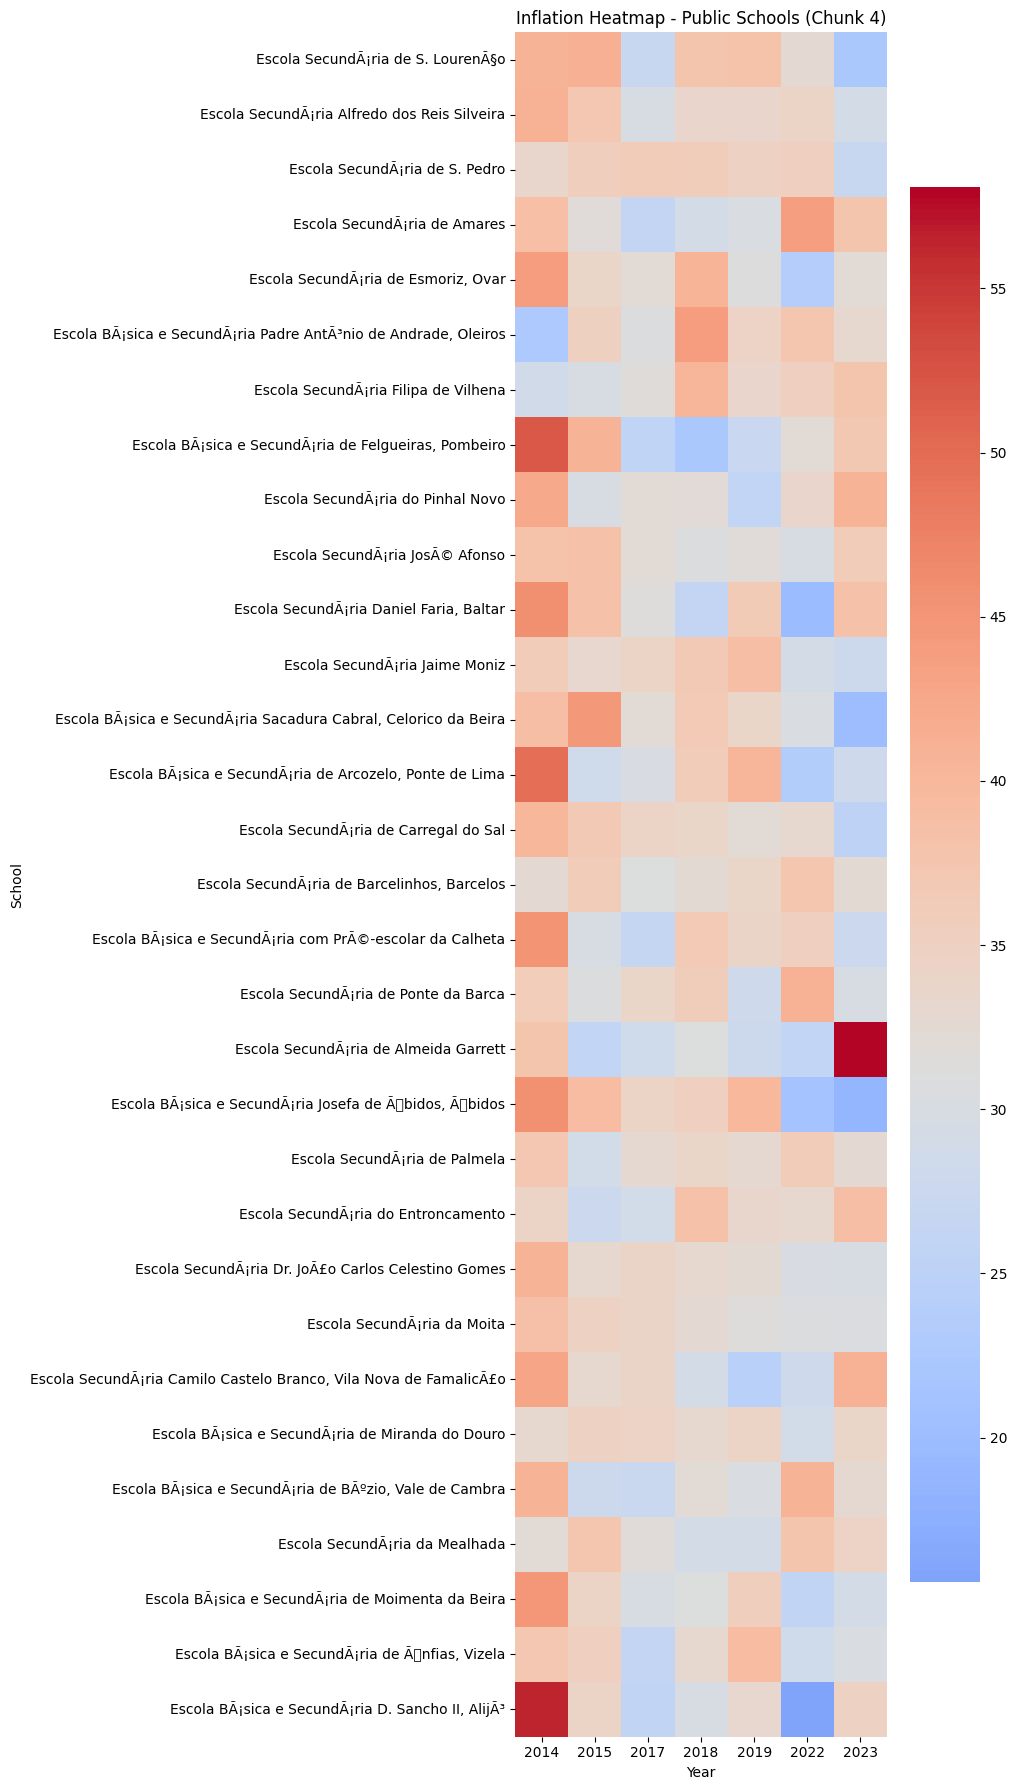

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.draw()
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


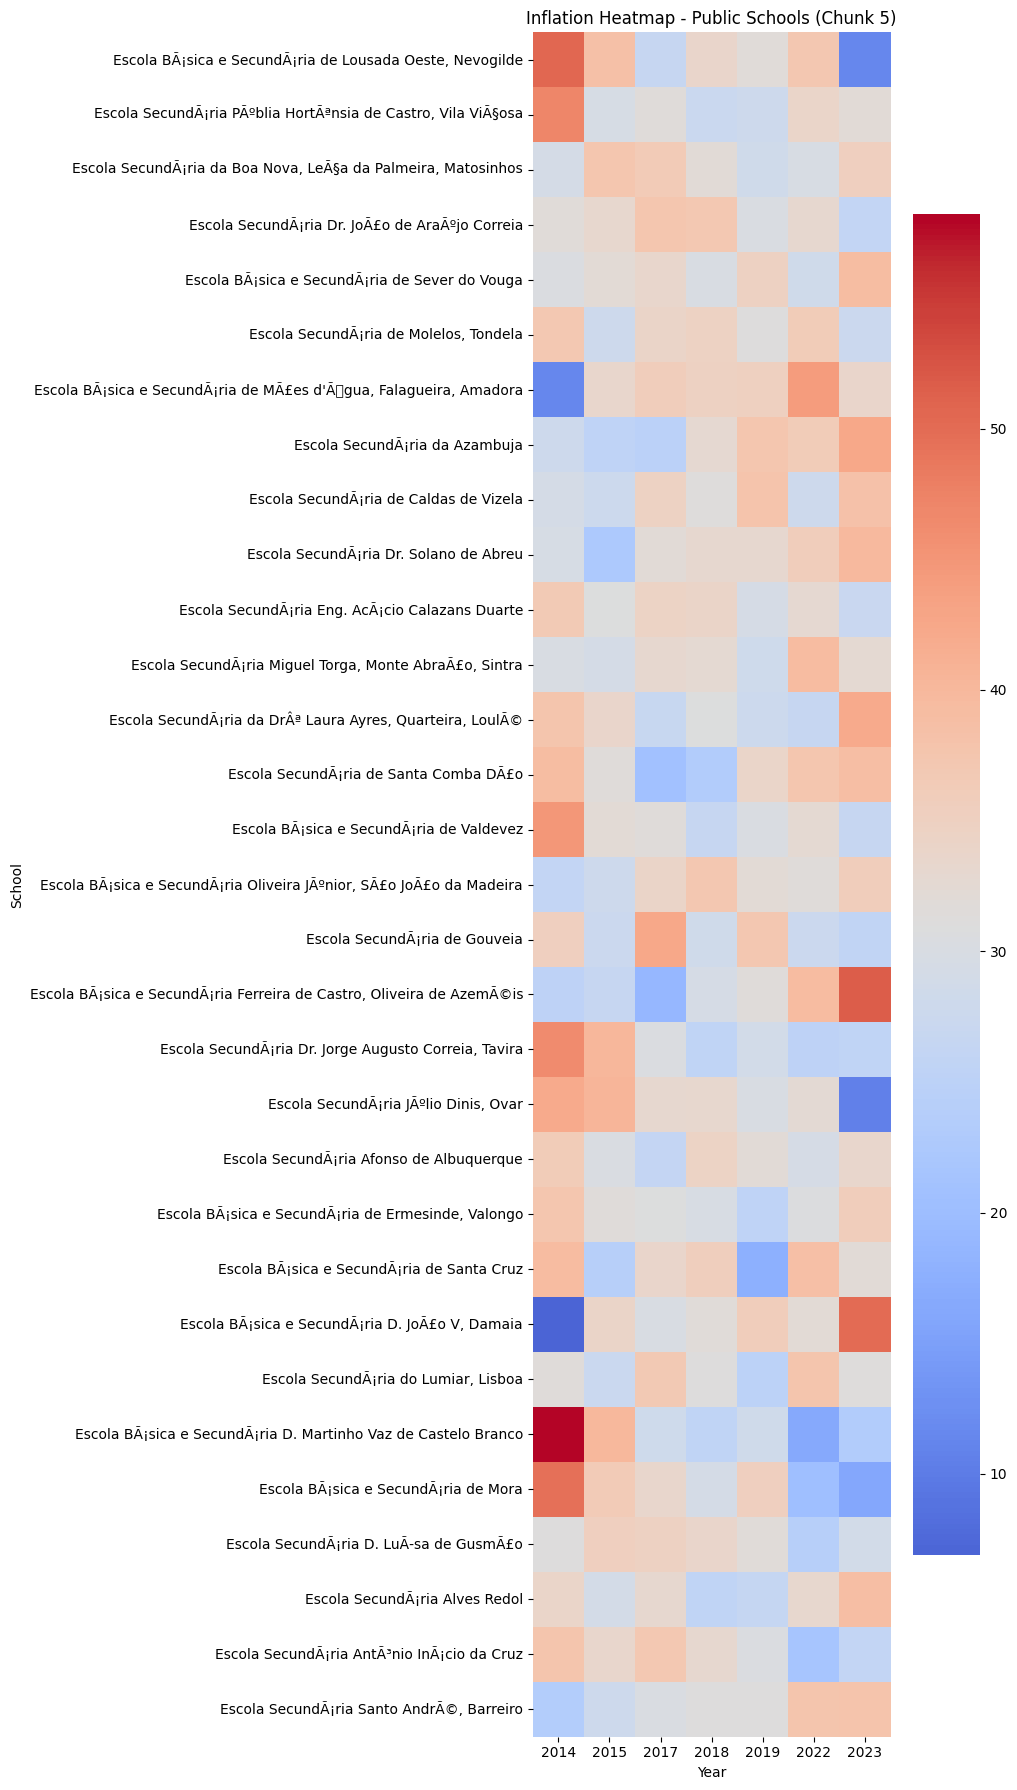

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.draw()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.draw()
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


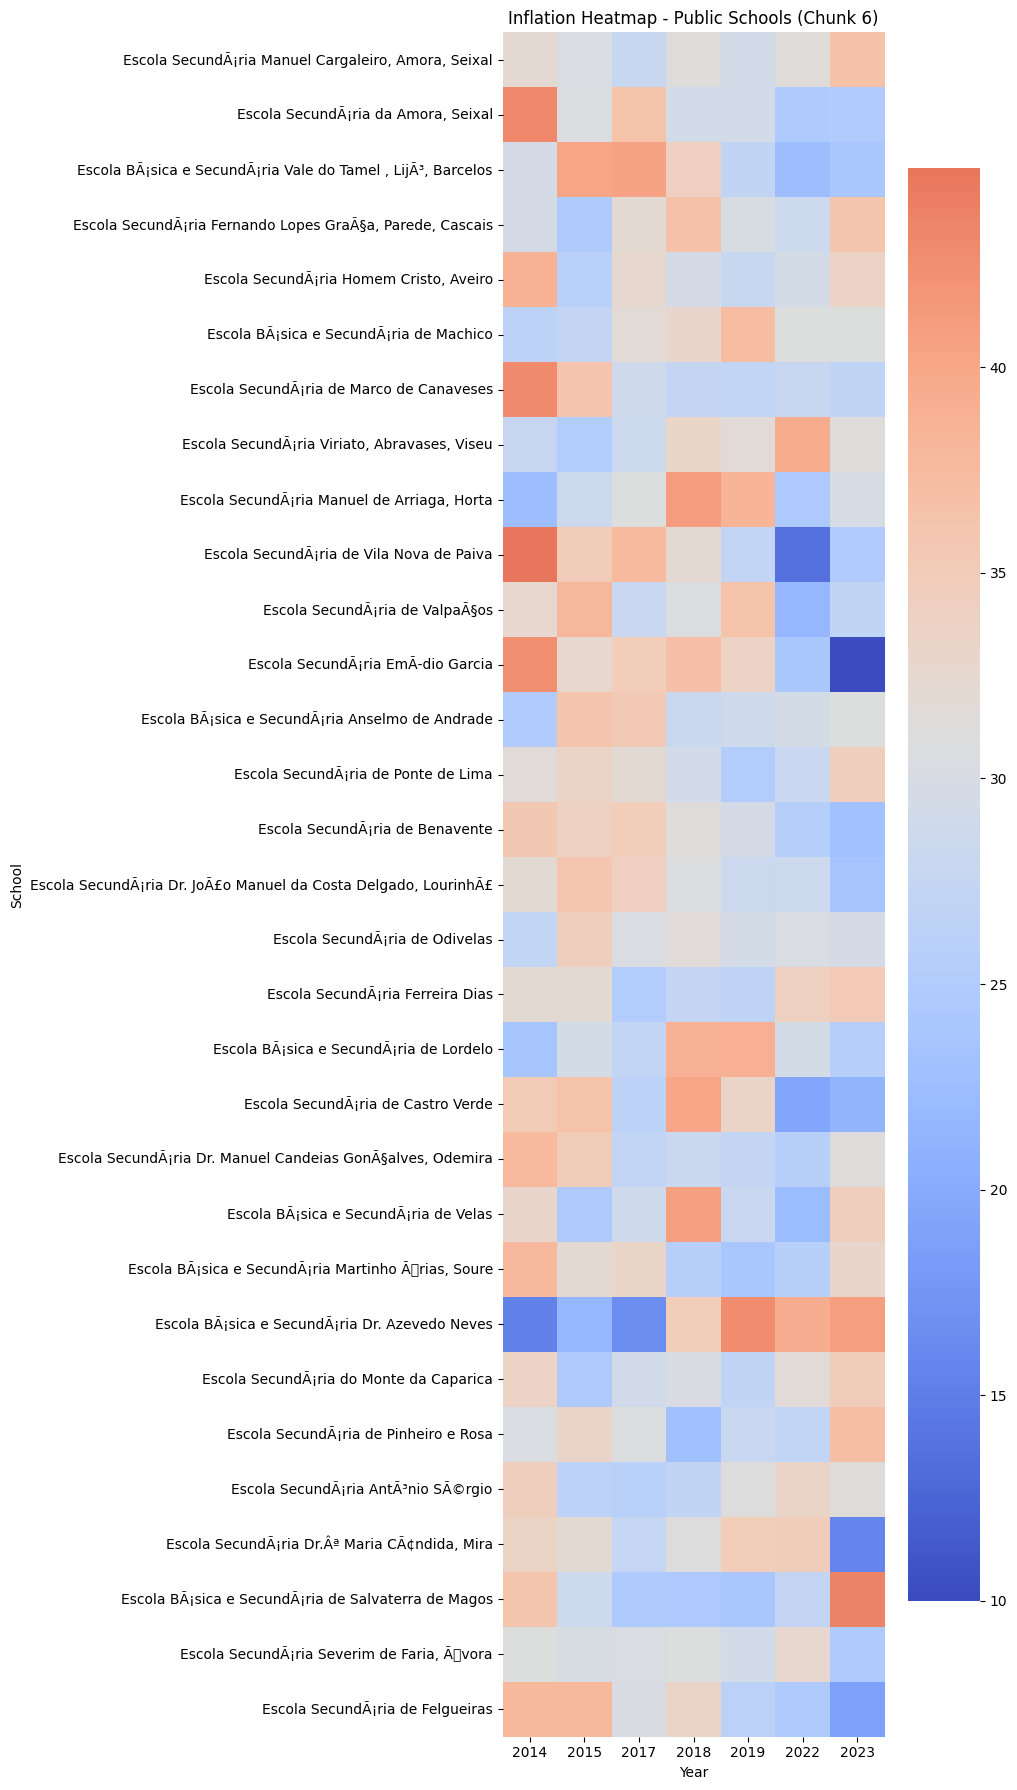

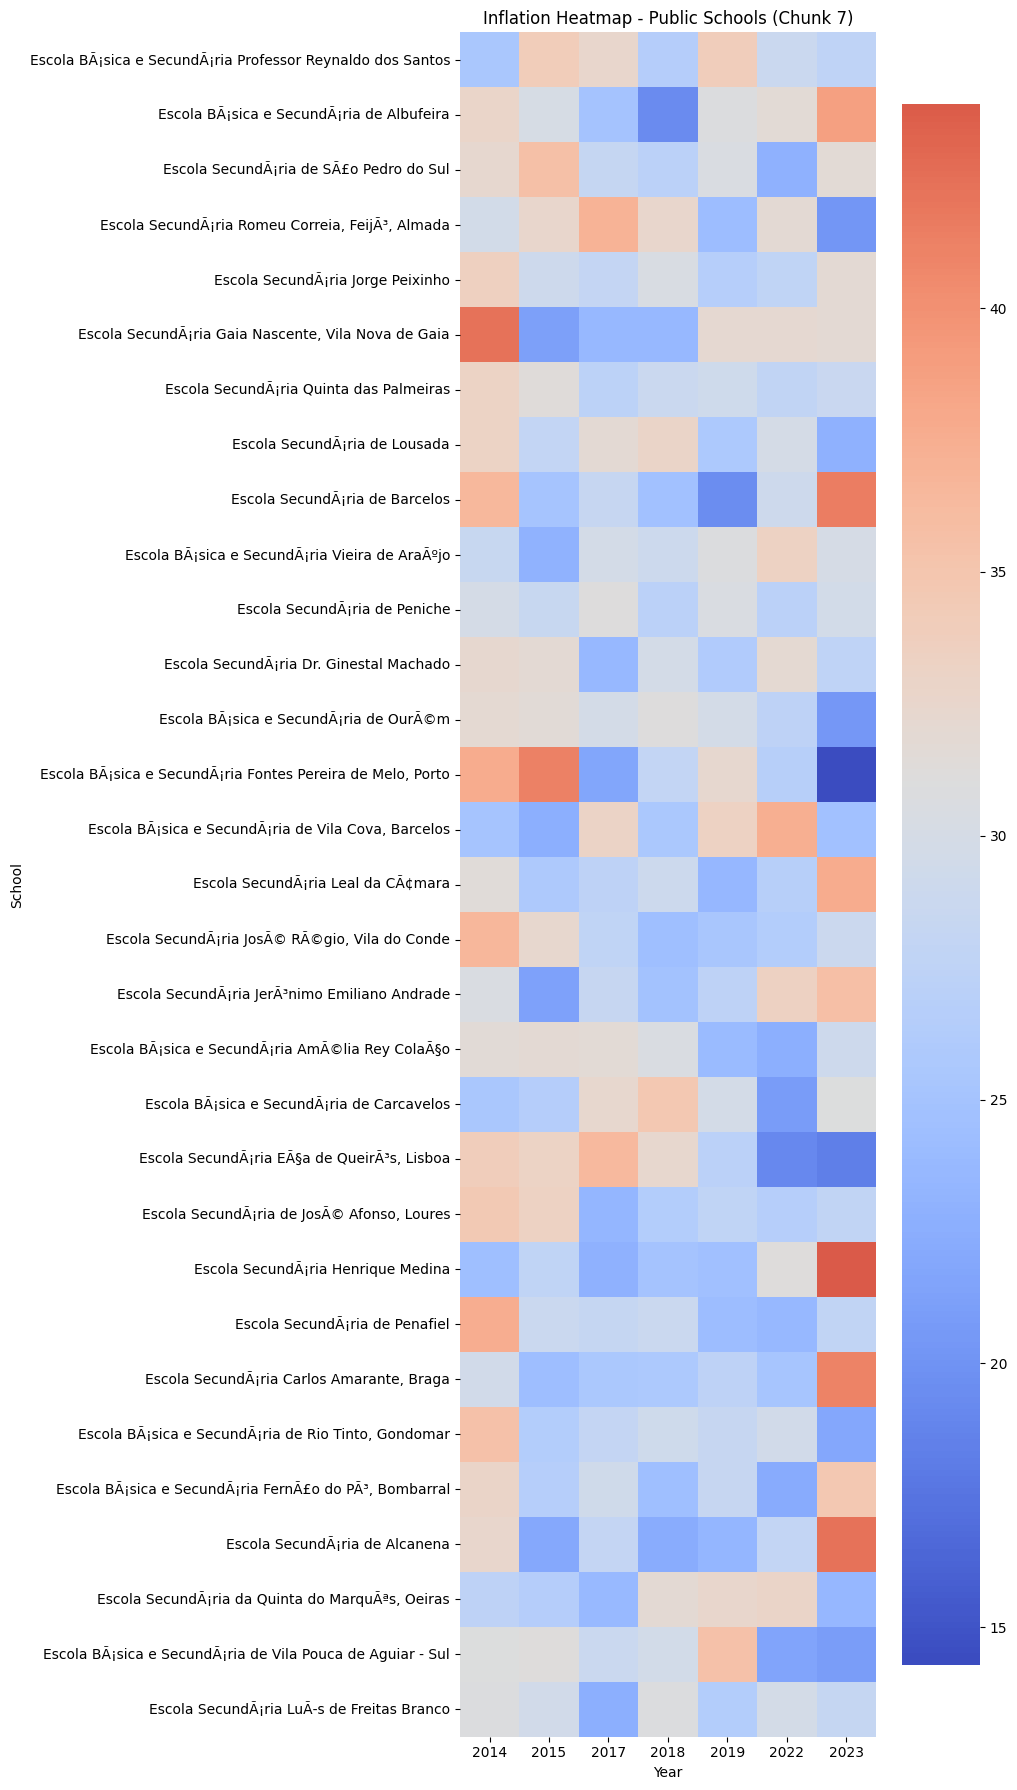

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.draw()
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


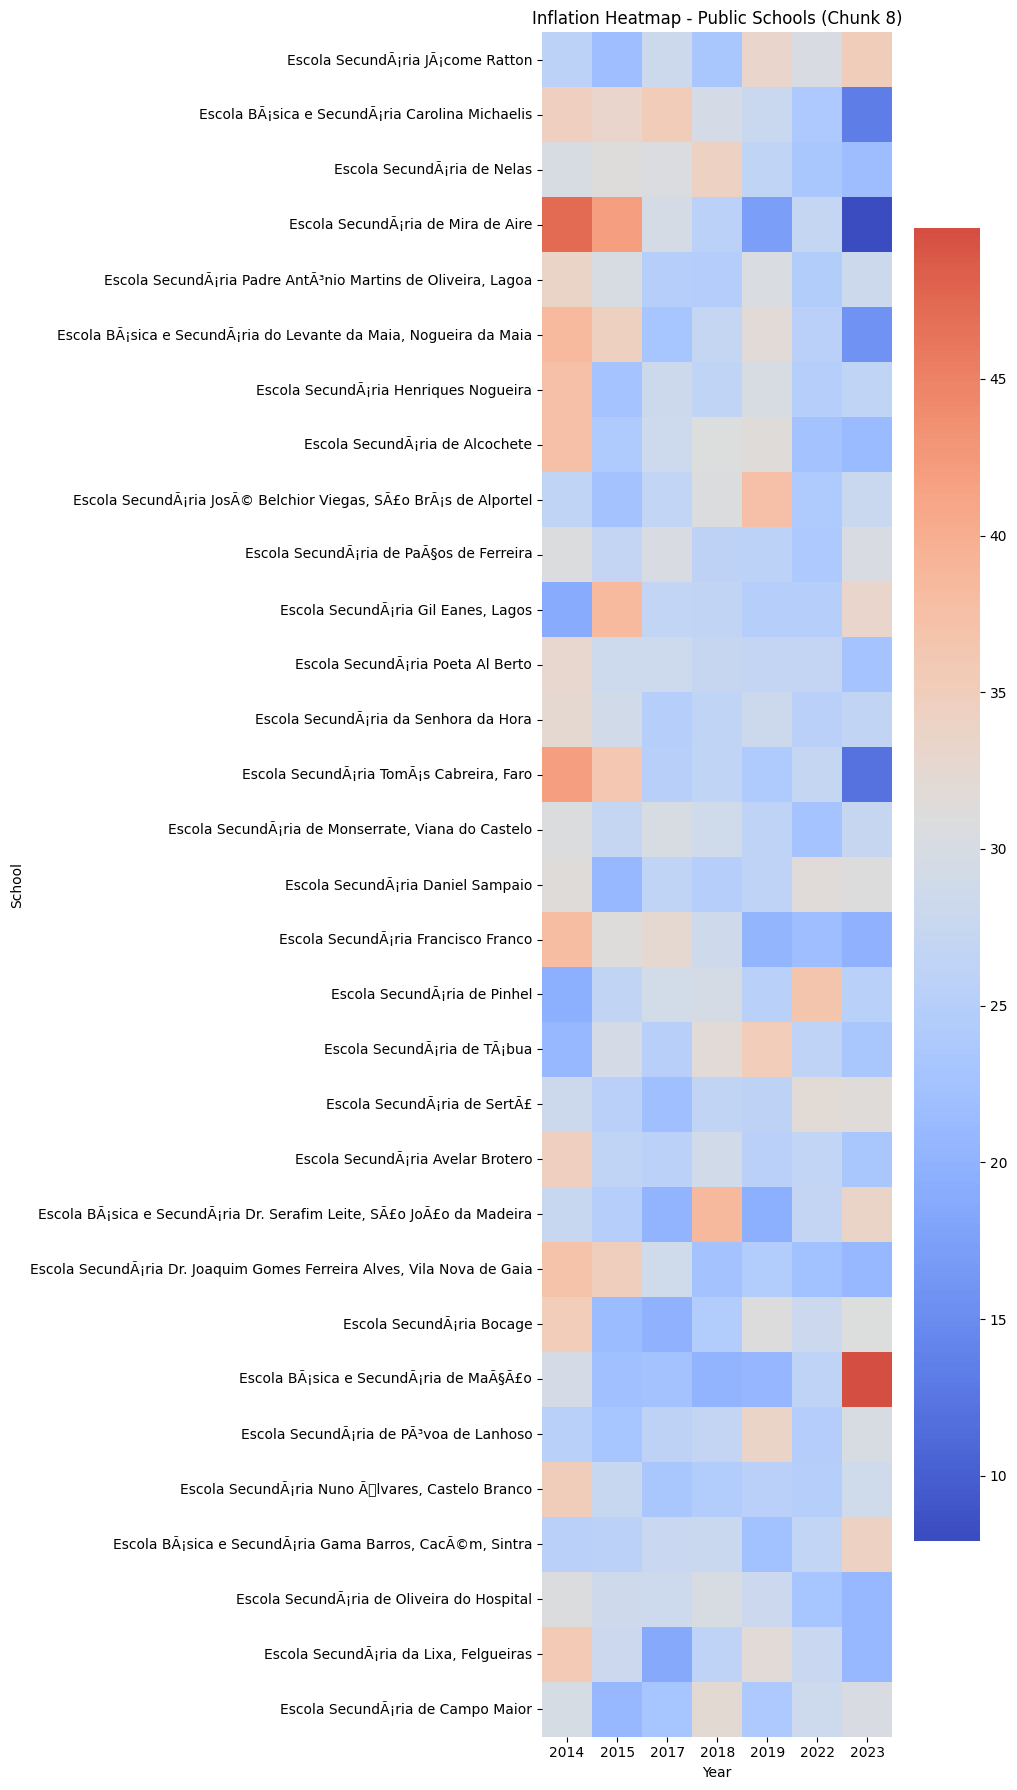

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.draw()
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


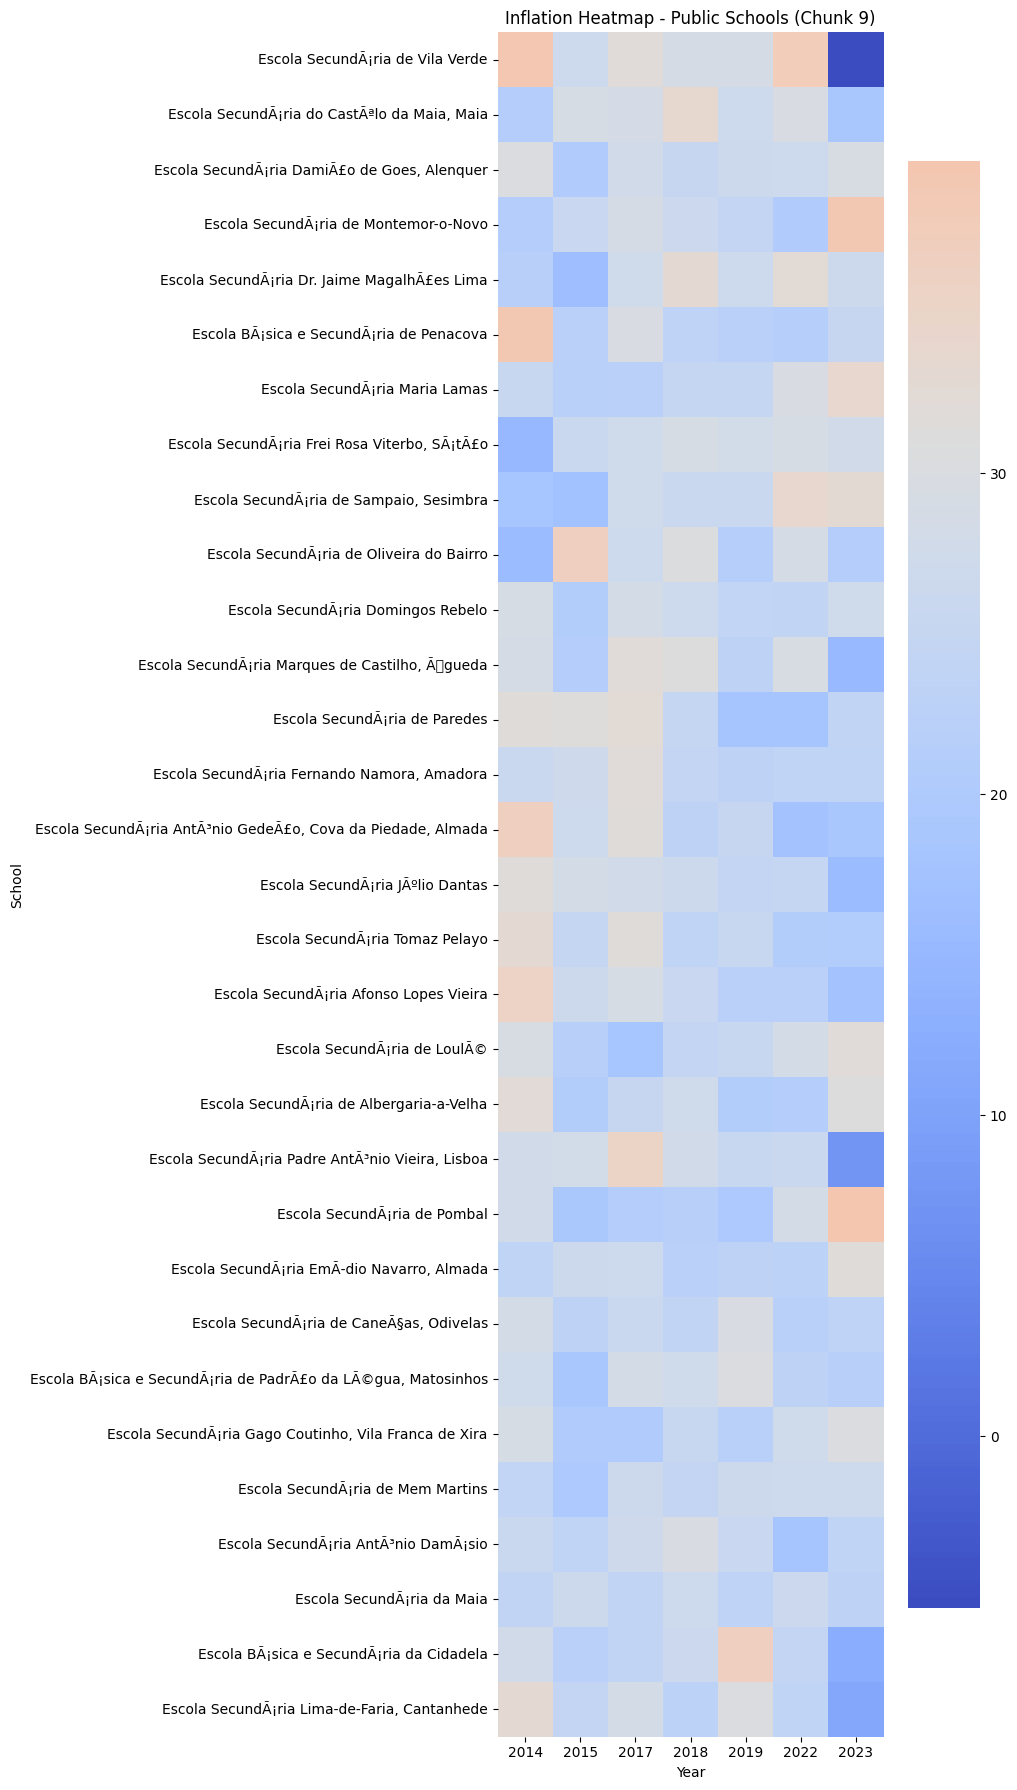

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.draw()
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


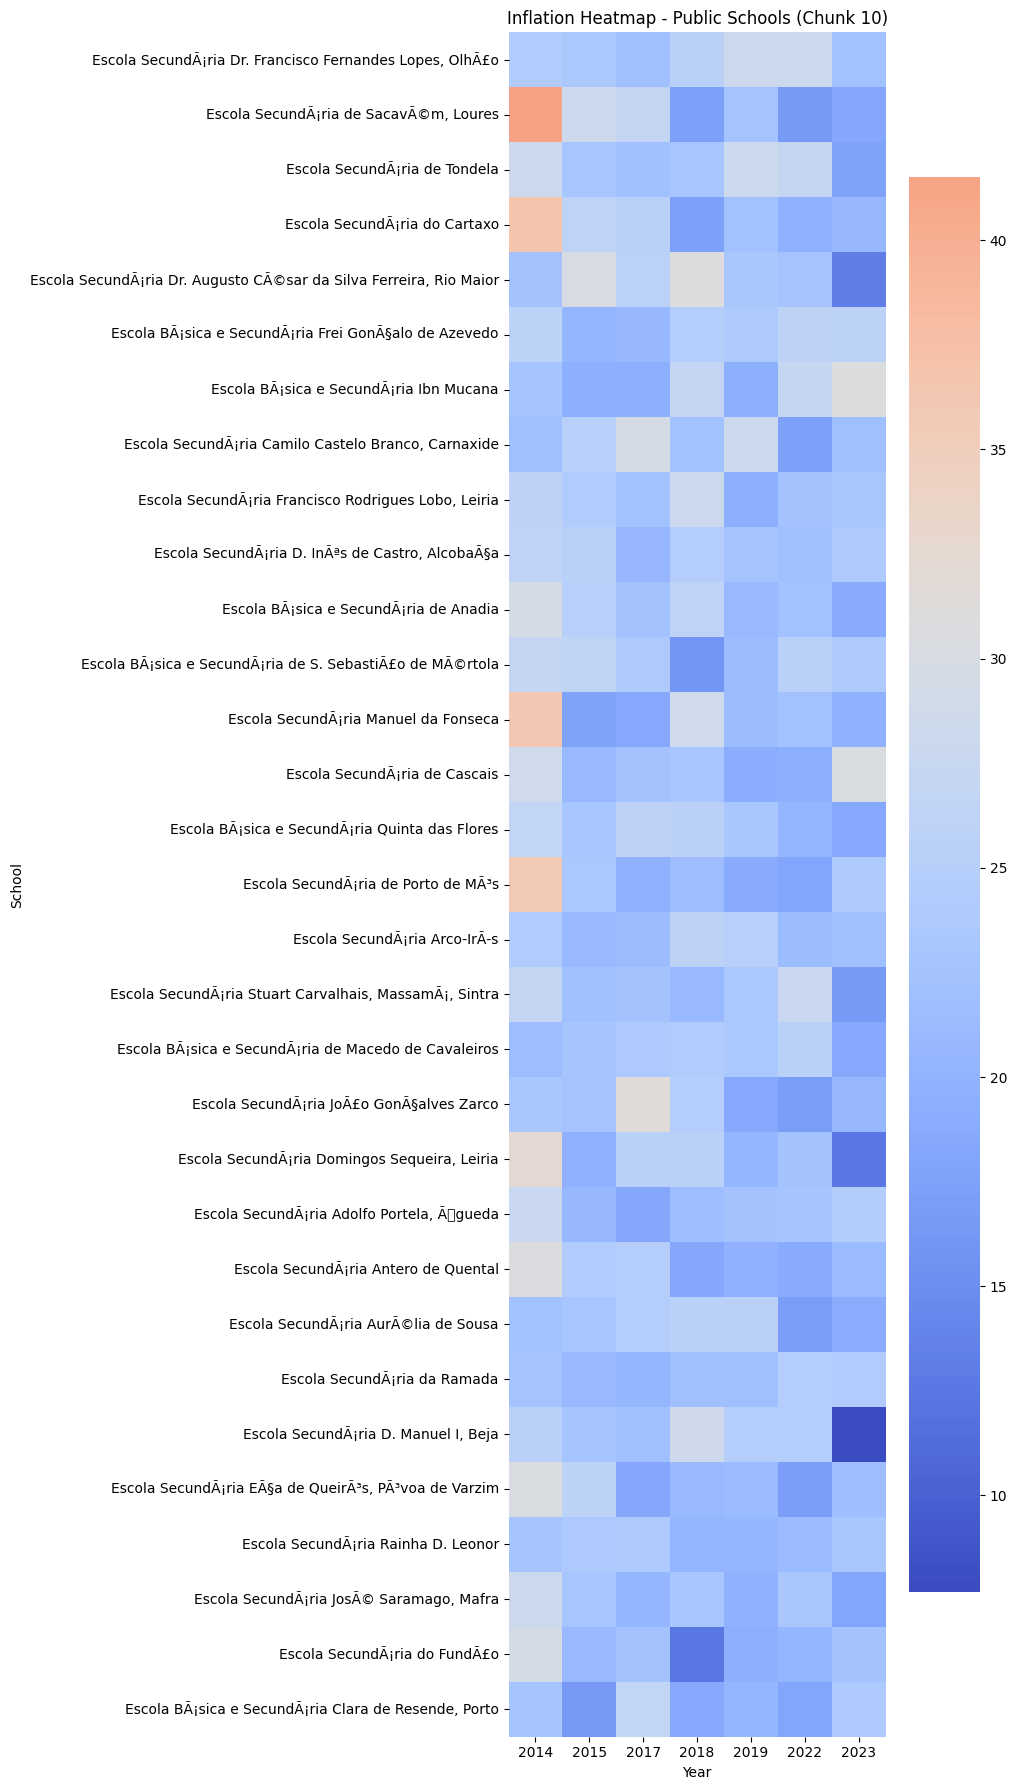

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 147 (\x93) missing from current font.
  fig.canvas.draw()
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 147 (\x93) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


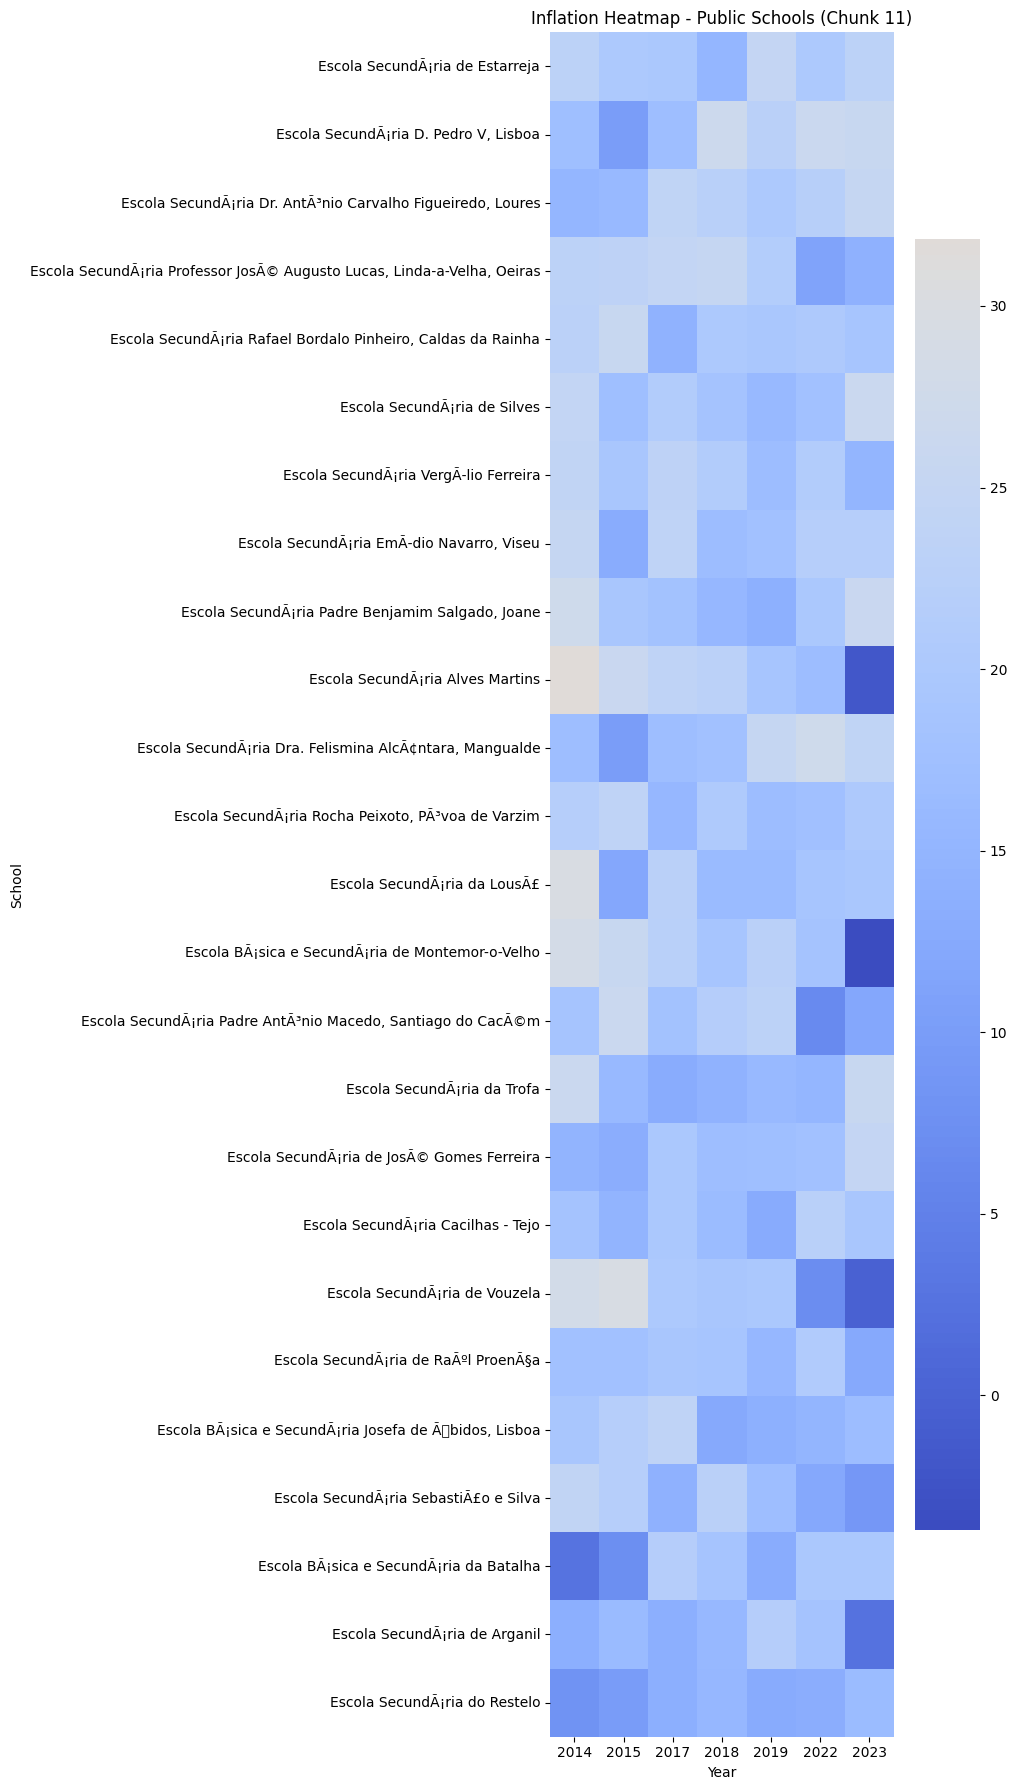

Escolas privadas:


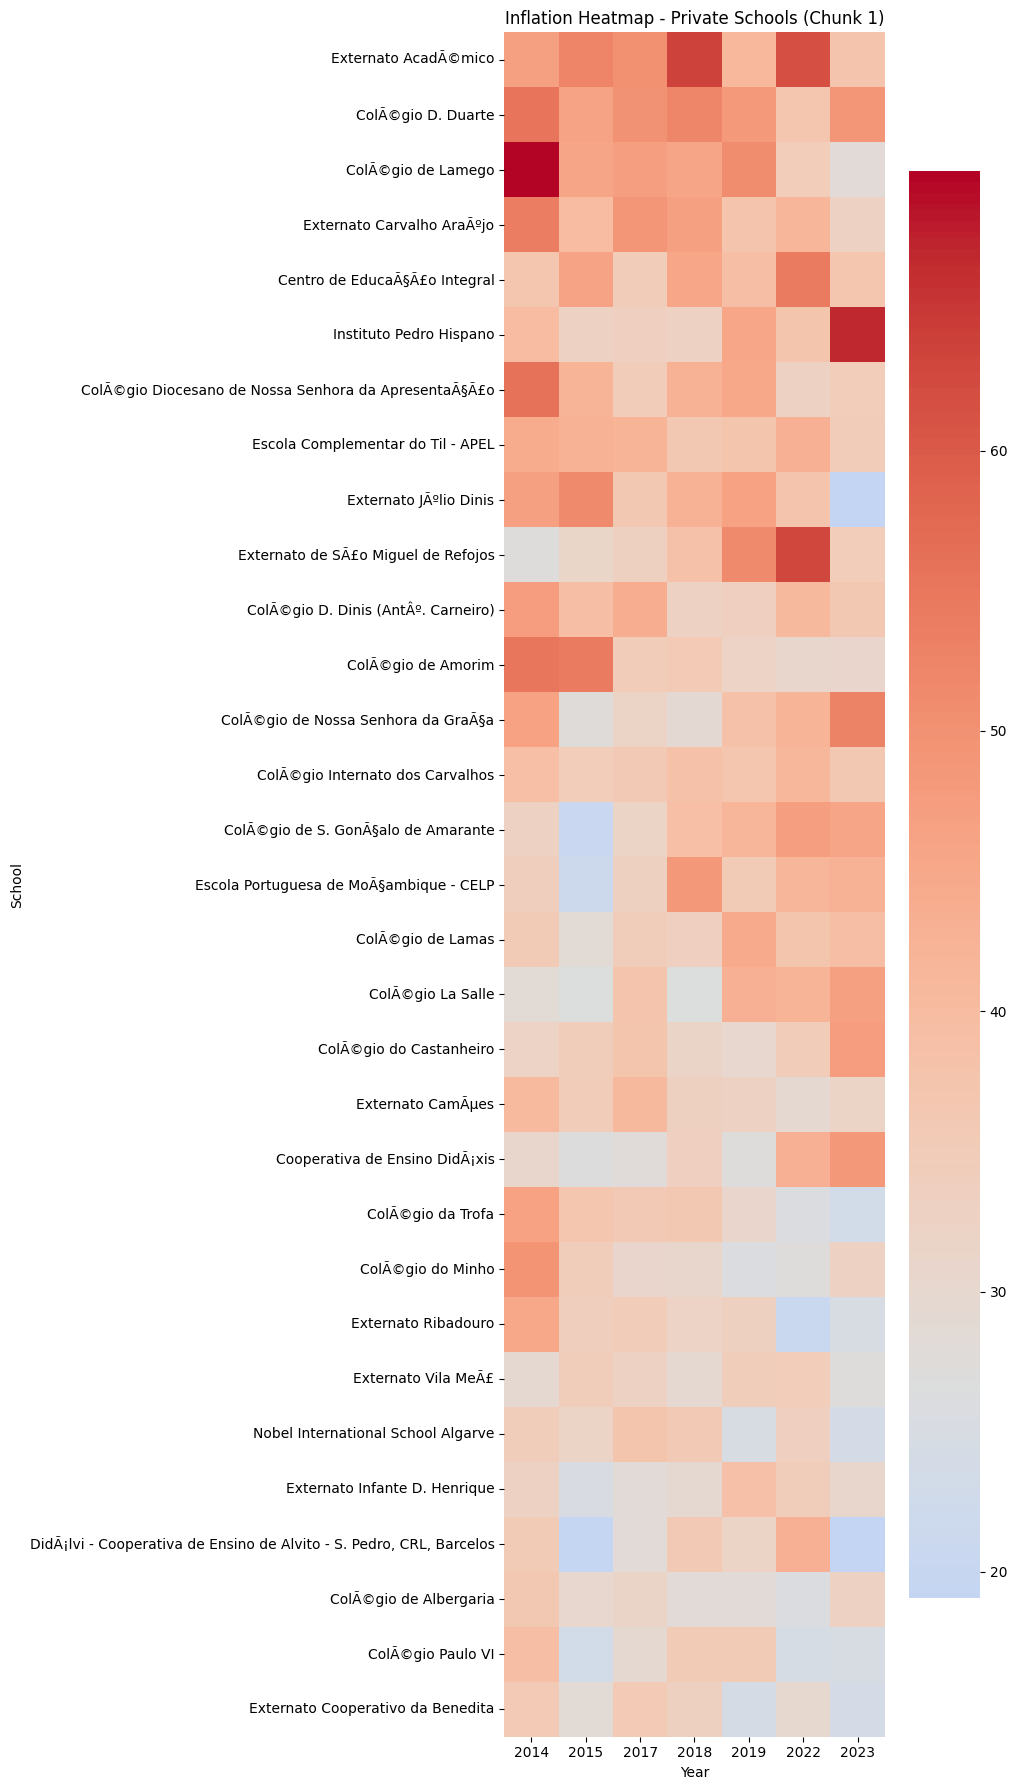

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.draw()
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


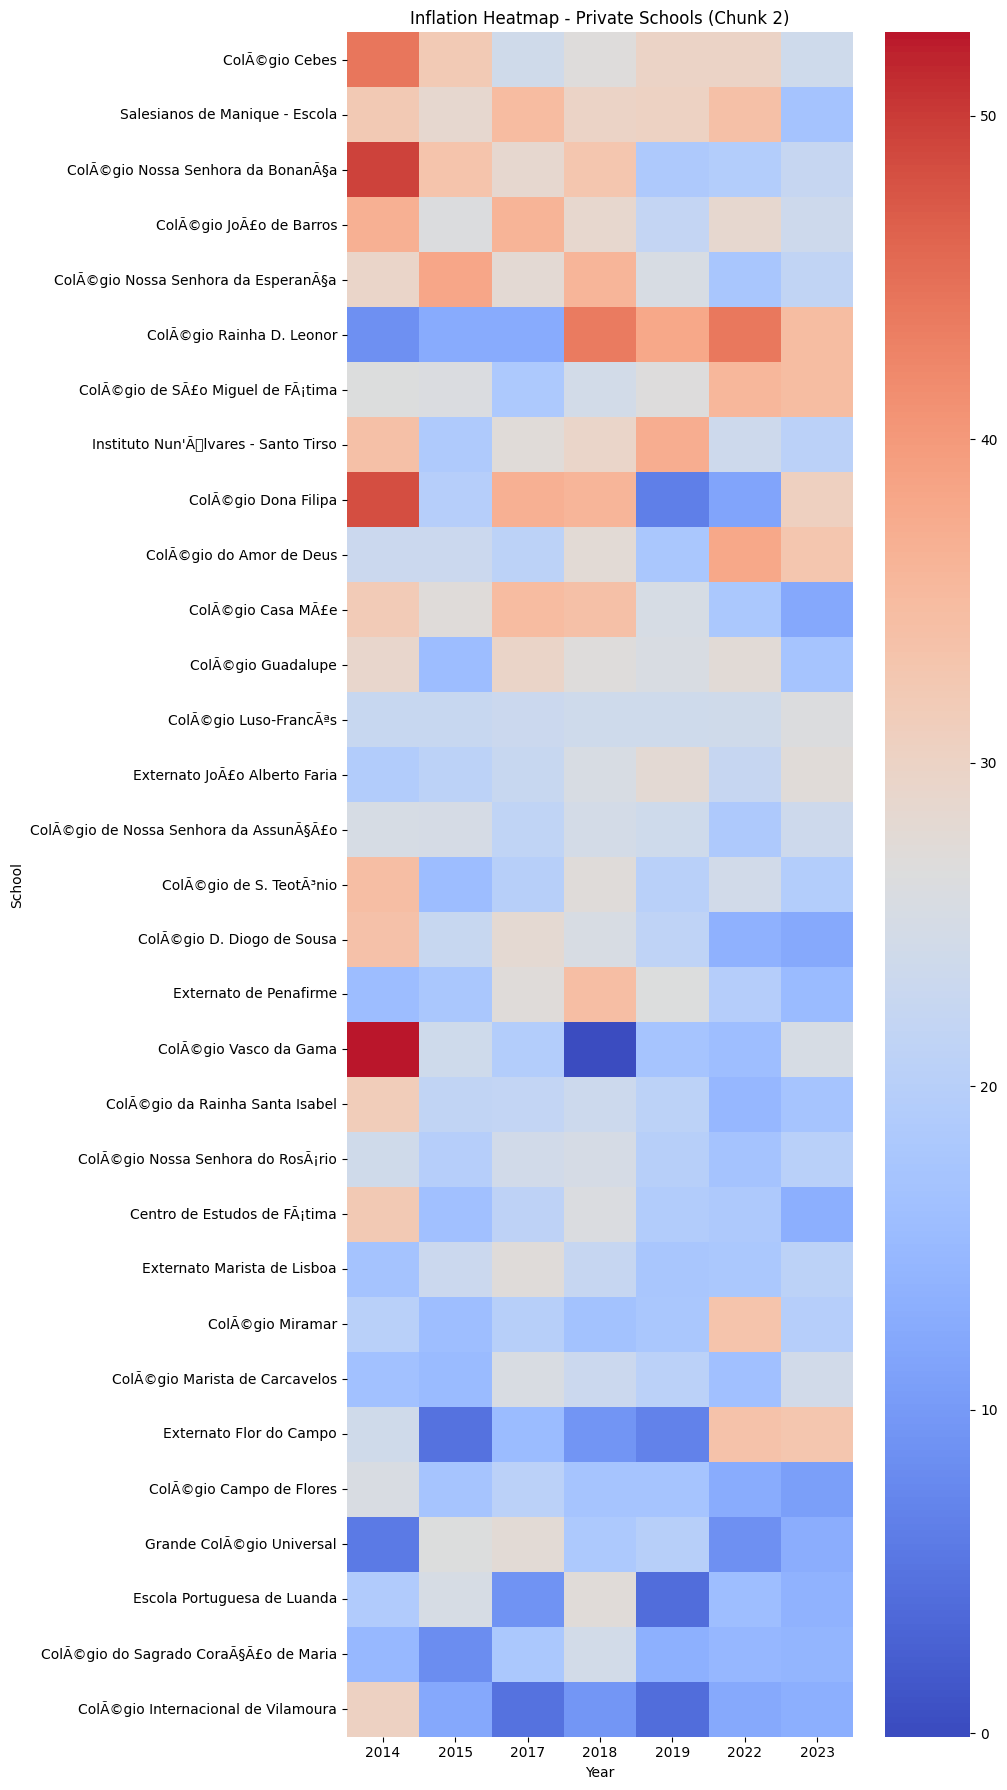

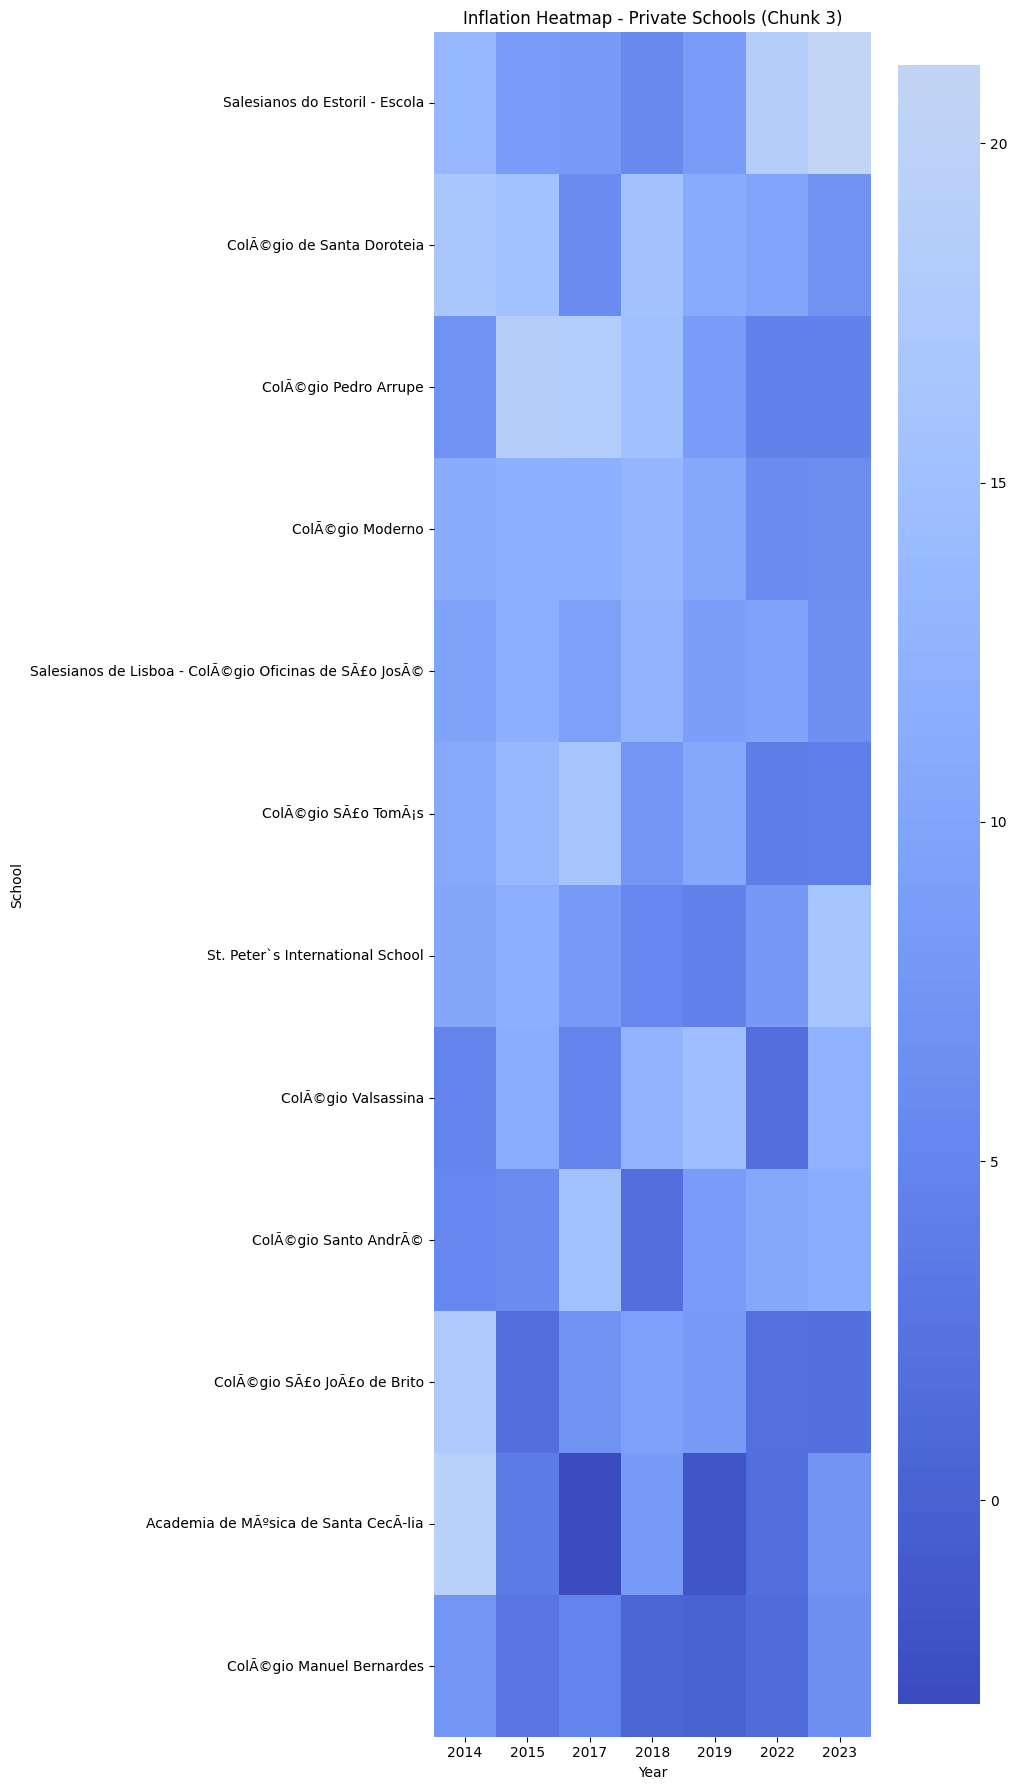

In [72]:
# Step 1: Total inflation per school
total_inflation_pub = inflation_pivot_pub_clean.sum(axis=1)
total_inflation_pri = inflation_pivot_pri_clean.sum(axis=1)

# Step 2: Sort schools by total inflation descending
sorted_schools_pub = total_inflation_pub.sort_values(ascending=False).index
sorted_schools_pri = total_inflation_pri.sort_values(ascending=False).index

# Step 3: Map codes to names
school_name_map = codigos_escolas_distritos.set_index("escola")["escola_descr"].to_dict()

# Step 4: Reindex to sorted order
sorted_pivot_pub = inflation_pivot_pub_clean.loc[sorted_schools_pub]
sorted_pivot_pri = inflation_pivot_pri_clean.loc[sorted_schools_pri]

# Step 5: Replace index with school names
sorted_pivot_pub.index = sorted_pivot_pub.index.map(lambda code: school_name_map.get(code, str(code)))
sorted_pivot_pri.index = sorted_pivot_pri.index.map(lambda code: school_name_map.get(code, str(code)))

# Step 6: Split into chunks using NumPy
chunk_size = 31
num_chunks_pub = int(np.ceil(len(sorted_pivot_pub) / chunk_size))
num_chunks_pri = int(np.ceil(len(sorted_pivot_pri) / chunk_size))
# Step 7: Plot each chunk

print("Escolas públicas:")

for i in range(num_chunks_pub):
    chunk = sorted_pivot_pub.iloc[i*chunk_size:(i+1)*chunk_size]
    
    plt.figure(figsize=(10, 18))
    sns.heatmap(
        chunk, 
        cmap="coolwarm", 
        center=inflation_pivot_pub_clean.mean().mean(),
        annot=False,
        yticklabels=True
    )
    plt.title(f"Inflation Heatmap - Public Schools (Chunk {i+1})")
    plt.xlabel("Year")
    plt.ylabel("School")
    plt.tight_layout()
    plt.show()

print("Escolas privadas:")
for i in range(num_chunks_pri):
    chunk = sorted_pivot_pri.iloc[i*chunk_size:(i+1)*chunk_size]
    
    plt.figure(figsize=(10, 18))
    sns.heatmap(
        chunk, 
        cmap="coolwarm", 
        center=inflation_pivot_pri_clean.mean().mean(),
        annot=False,
        yticklabels=True
    )
    plt.title(f"Inflation Heatmap - Private Schools (Chunk {i+1})")
    plt.xlabel("Year")
    plt.ylabel("School")
    plt.tight_layout()
    plt.show()


A lot of things were dropped. lets not drop them, order by average

In [43]:
# Filter public schools
public_schools = escolas_anos[escolas_anos["ESCOLA_PUBPRIV"] == "PUB"]

# Filter private schools
private_schools = escolas_anos[escolas_anos["ESCOLA_PUBPRIV"] == "PRI"]

# Create pivot tables
inflation_pivot_pub = public_schools.pivot_table(index="ESCOLA", columns="ANO", values="INFLACAO", aggfunc="mean")
inflation_pivot_pri = private_schools.pivot_table(index="ESCOLA", columns="ANO", values="INFLACAO", aggfunc="mean")

Escolas públicas:


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.draw()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 130 (\x82) missing from current font.
  fig.canvas.draw()
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 130 (\x82) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


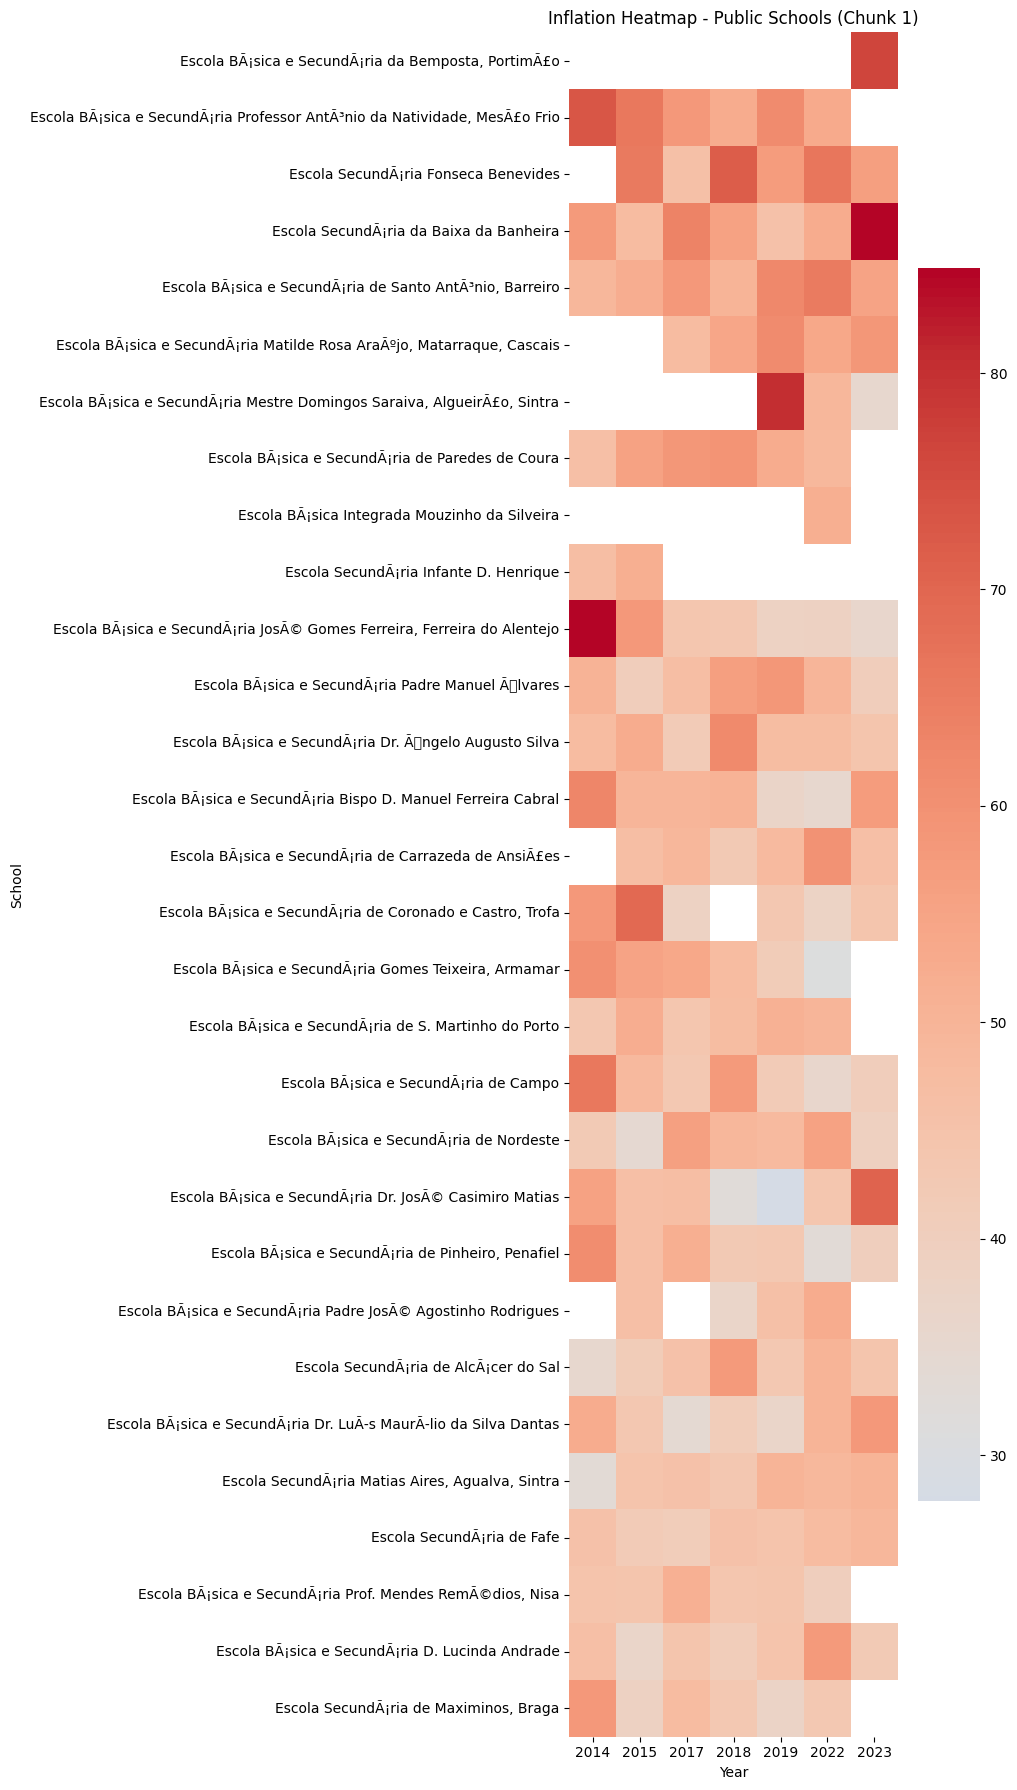

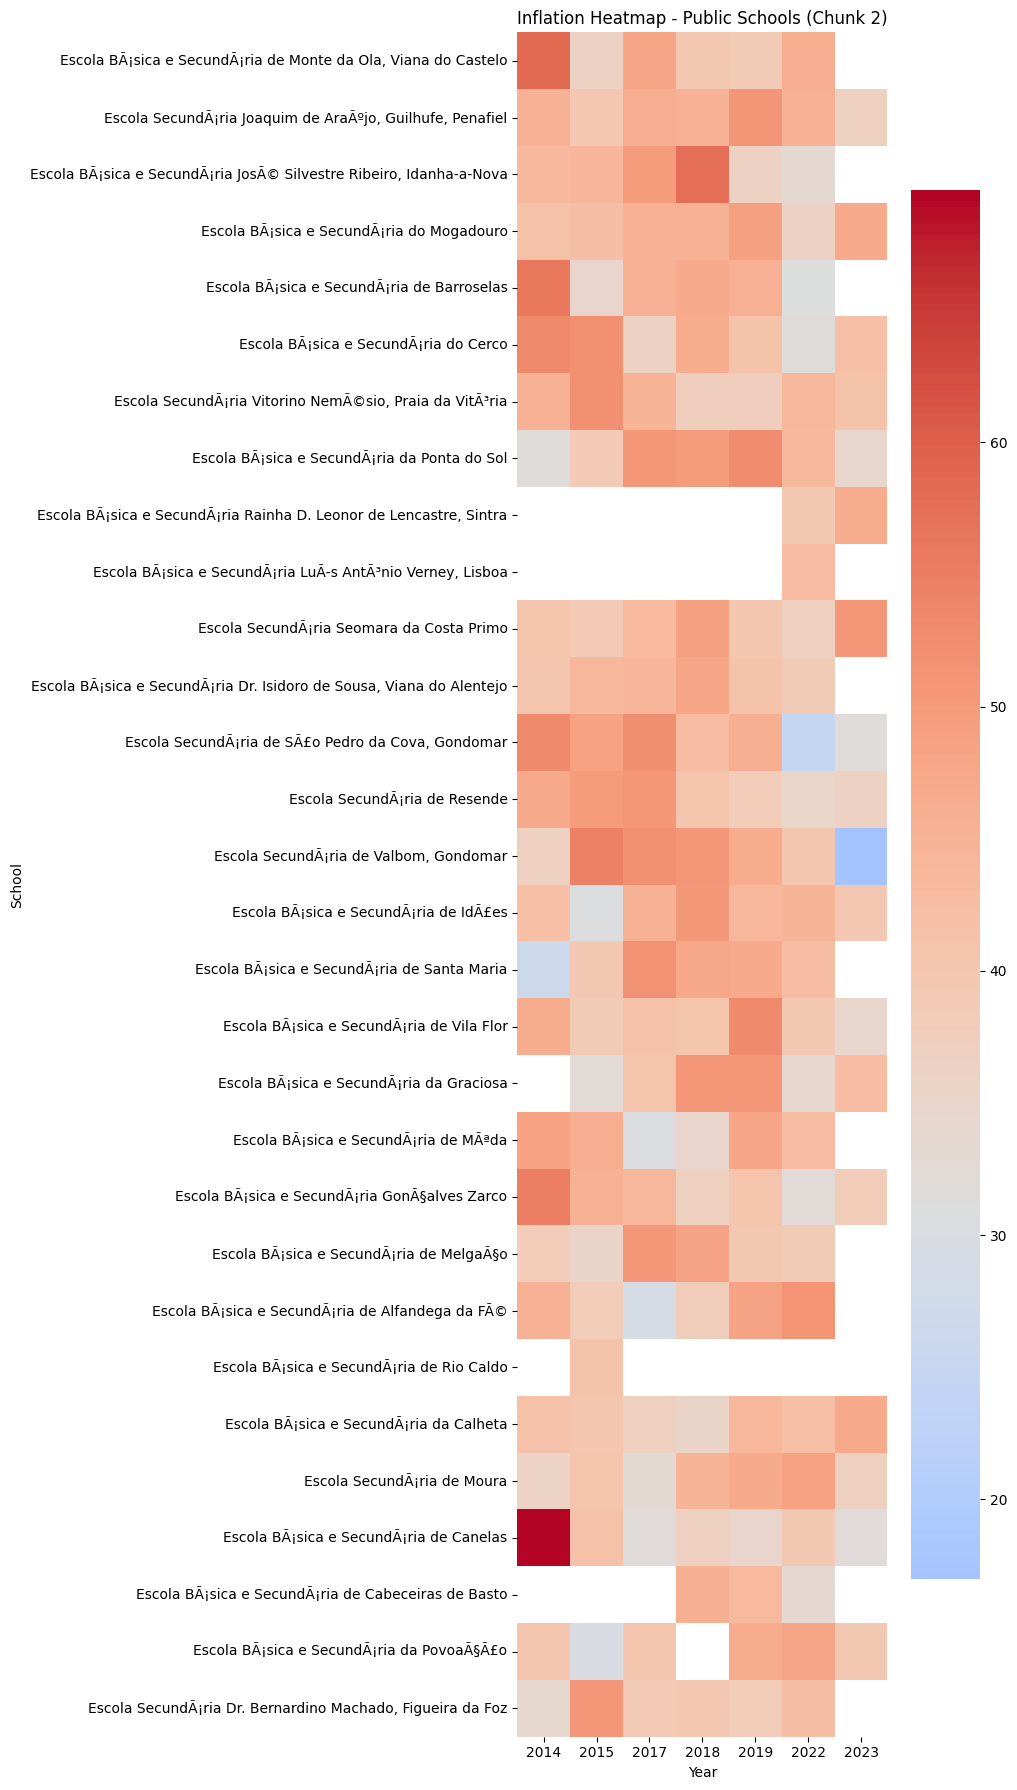

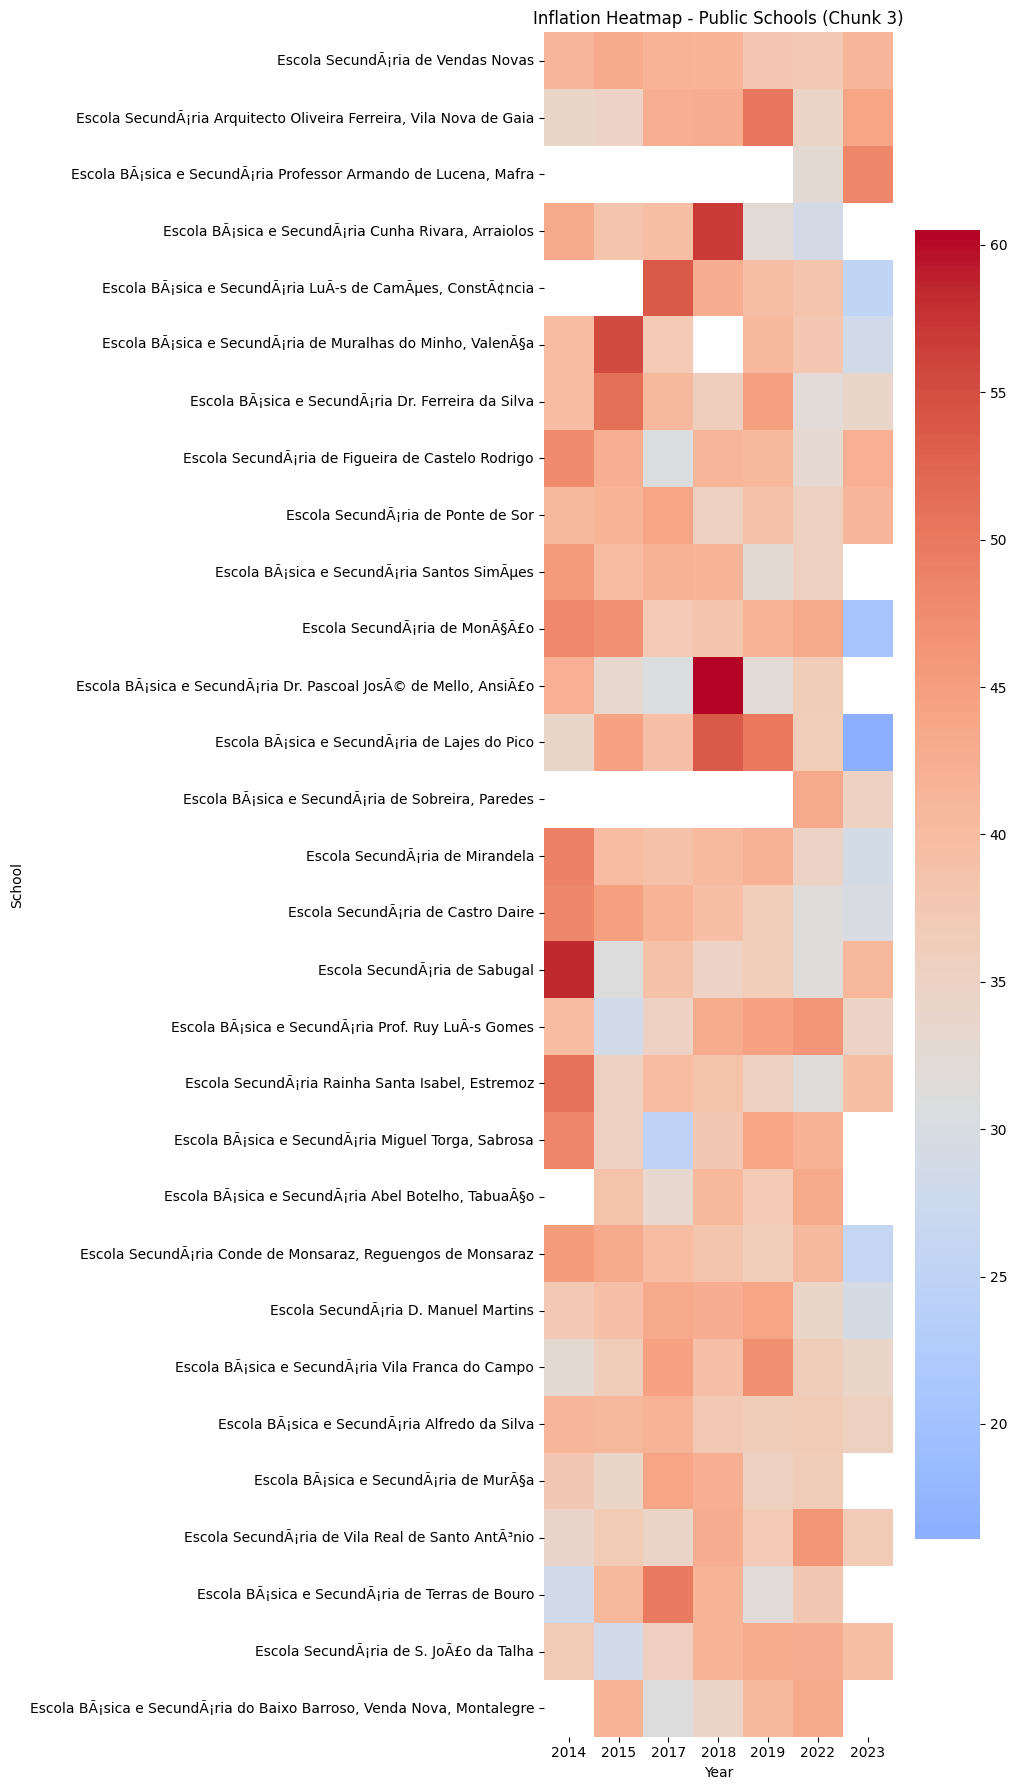

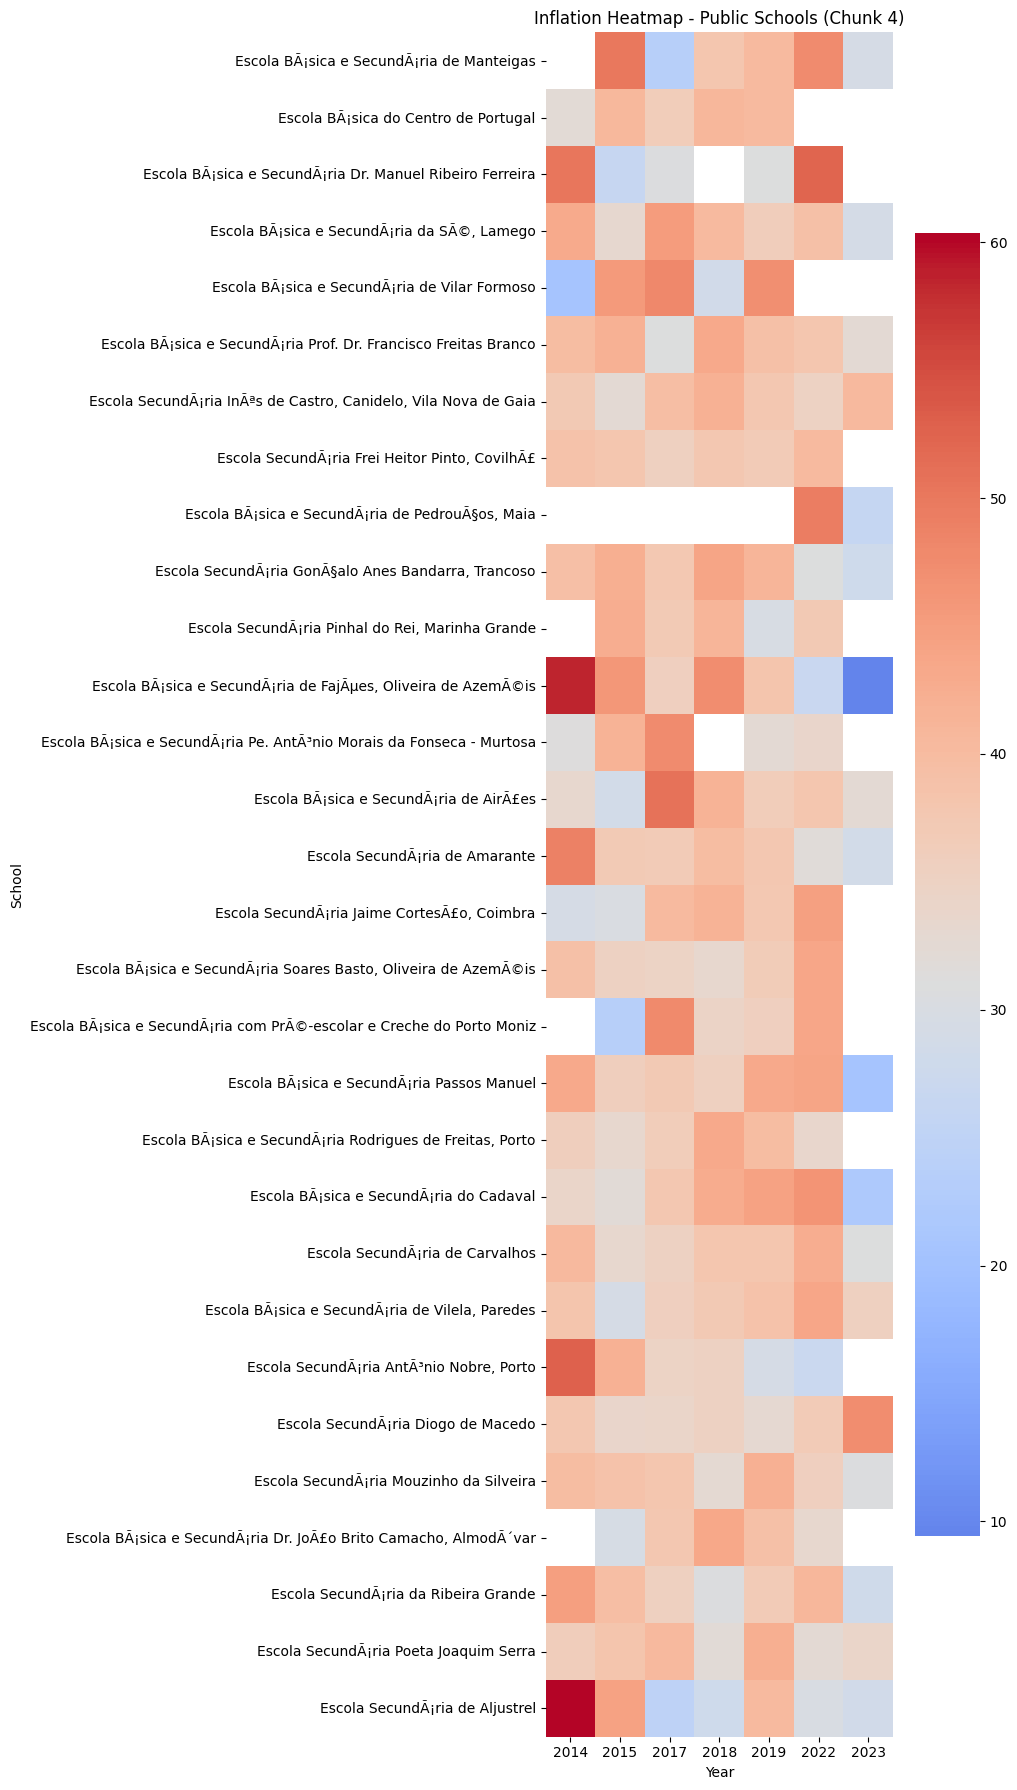

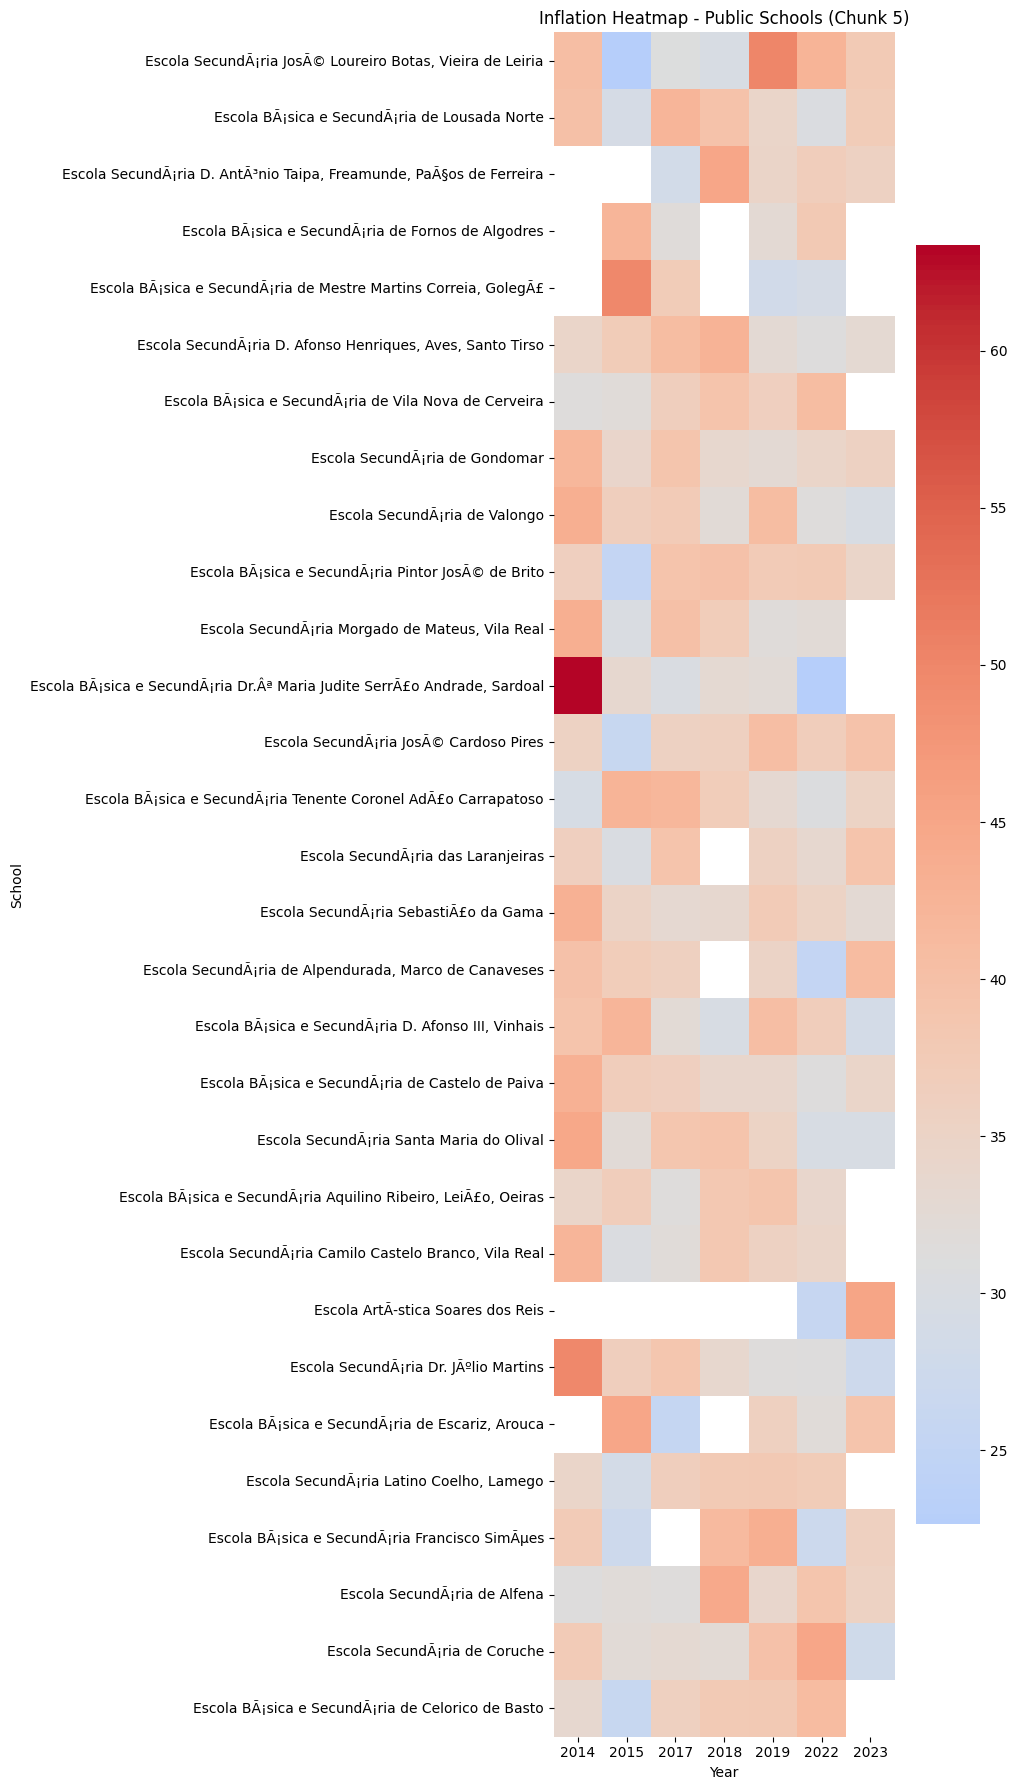

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.draw()
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


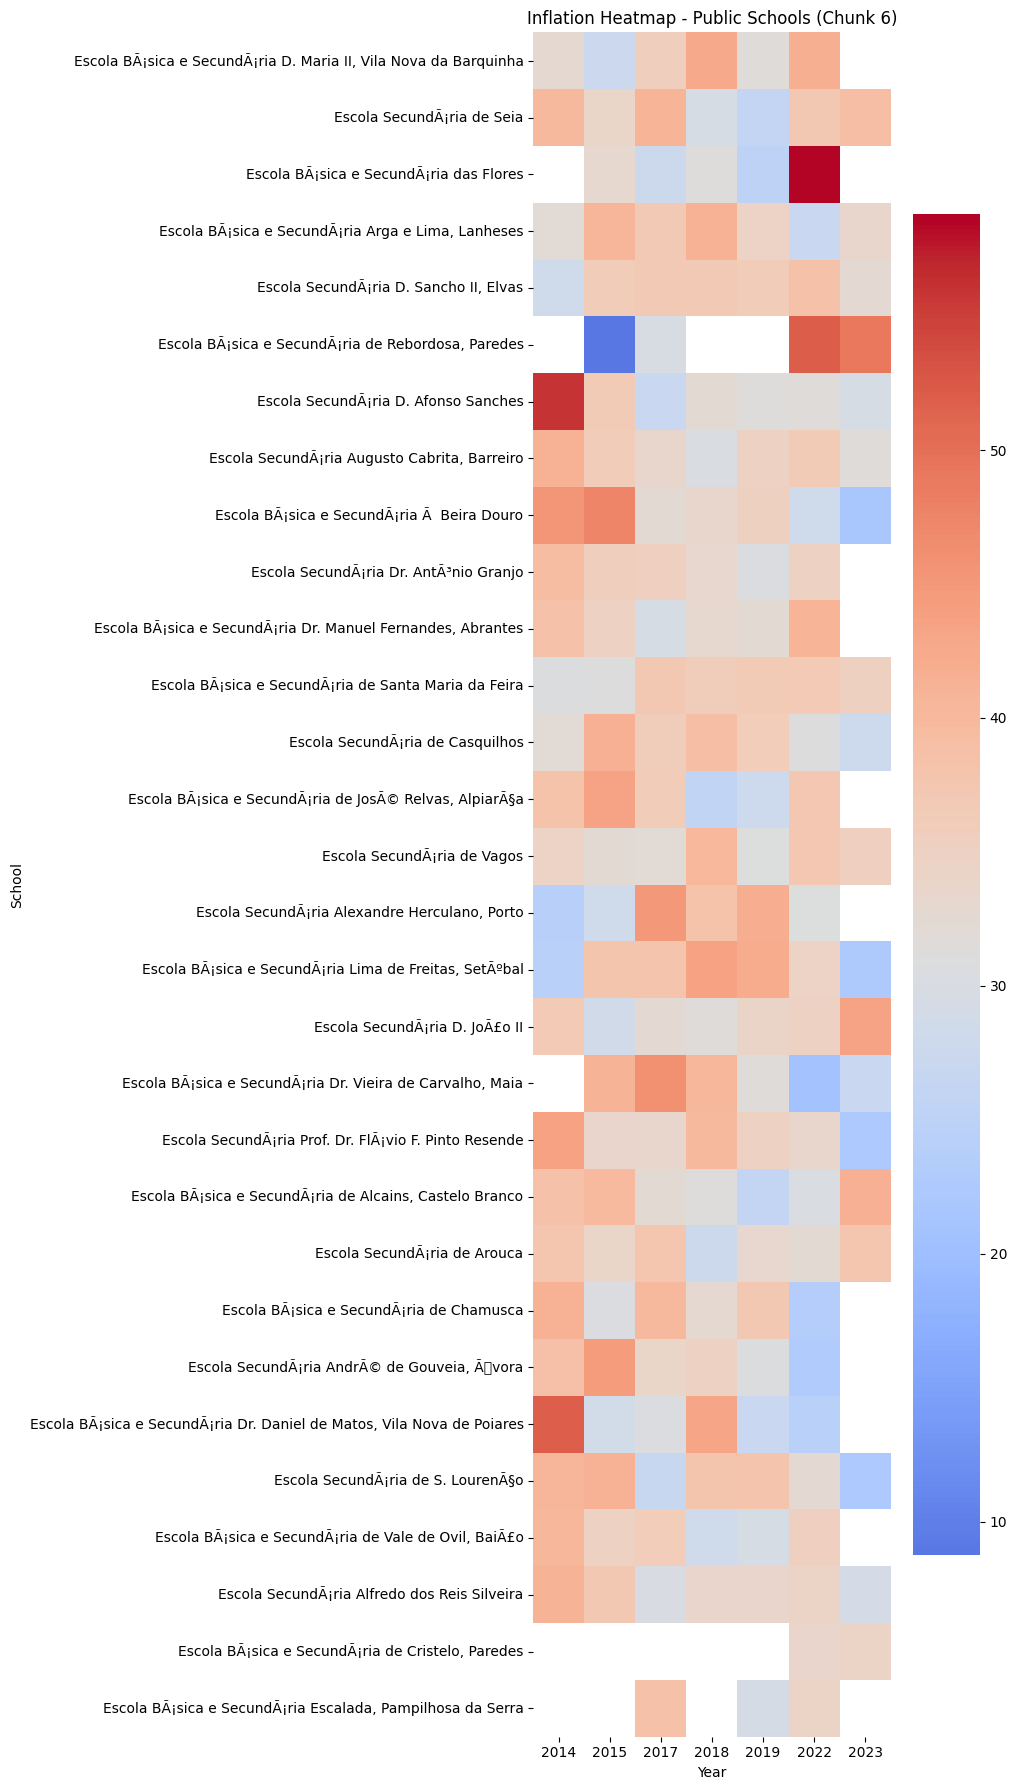

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 147 (\x93) missing from current font.
  fig.canvas.draw()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.draw()
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 147 (\x93) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


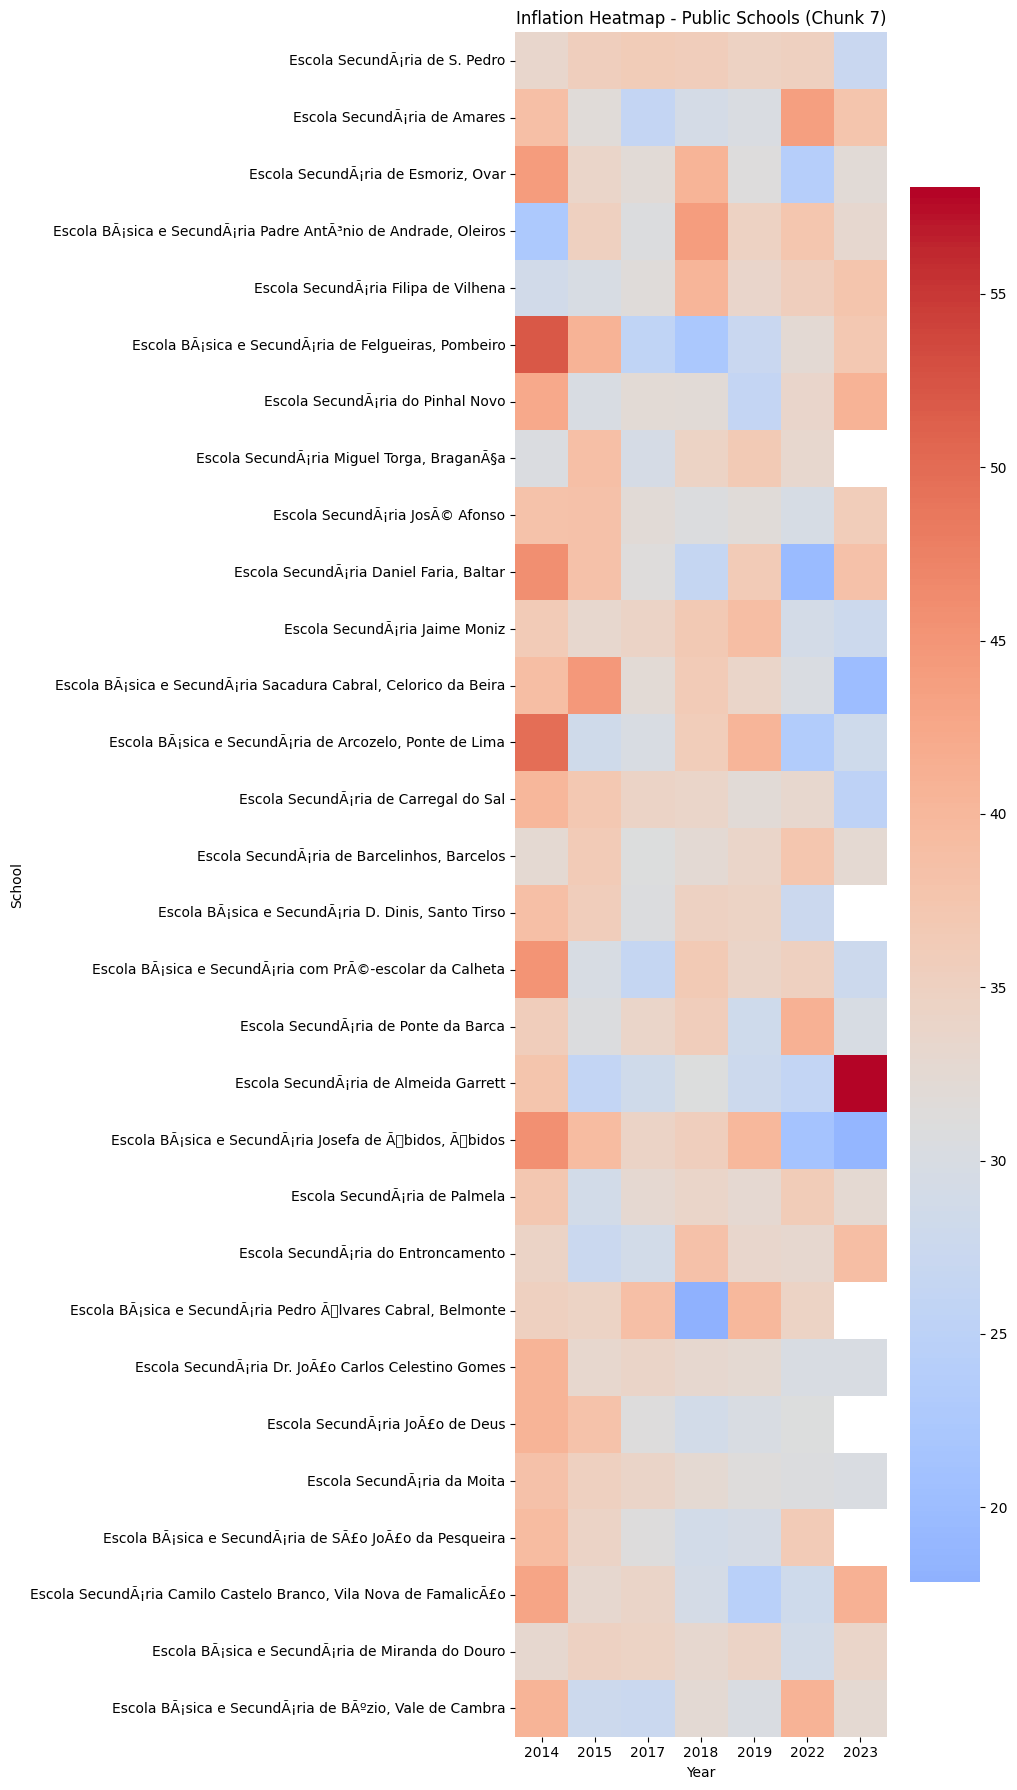

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 141 (\x8d) missing from current font.
  fig.canvas.draw()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.draw()
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 141 (\x8d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


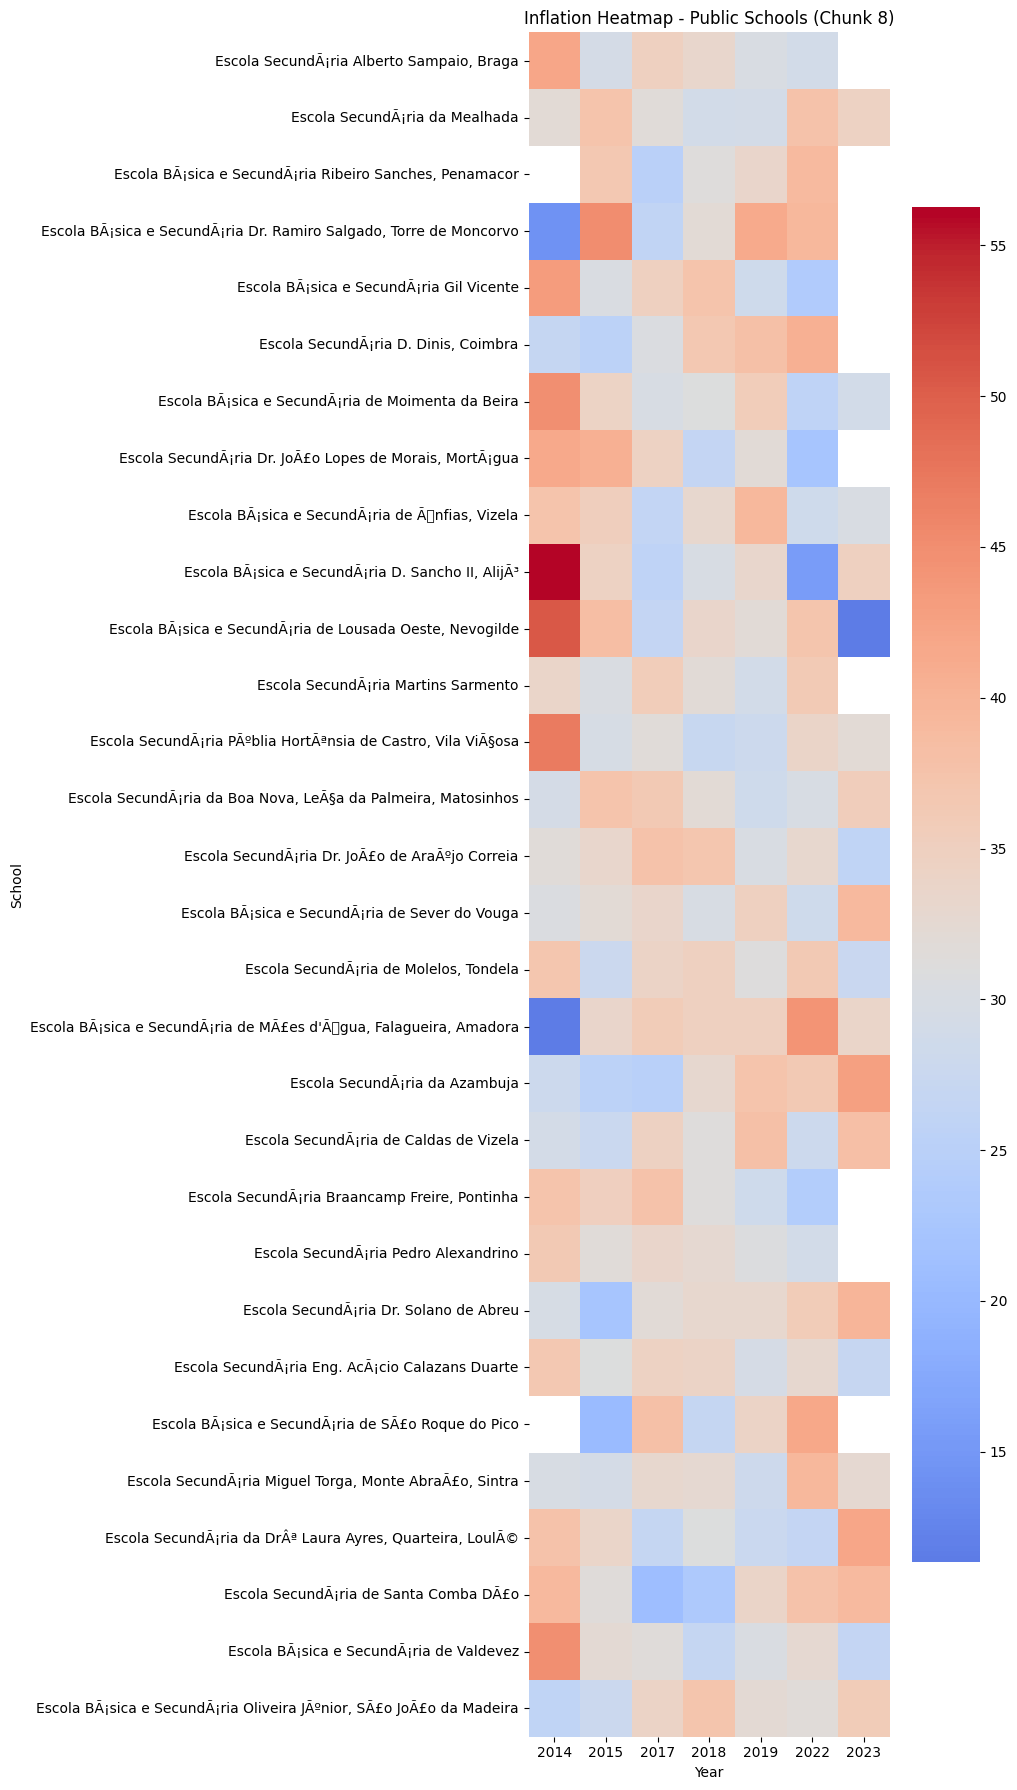

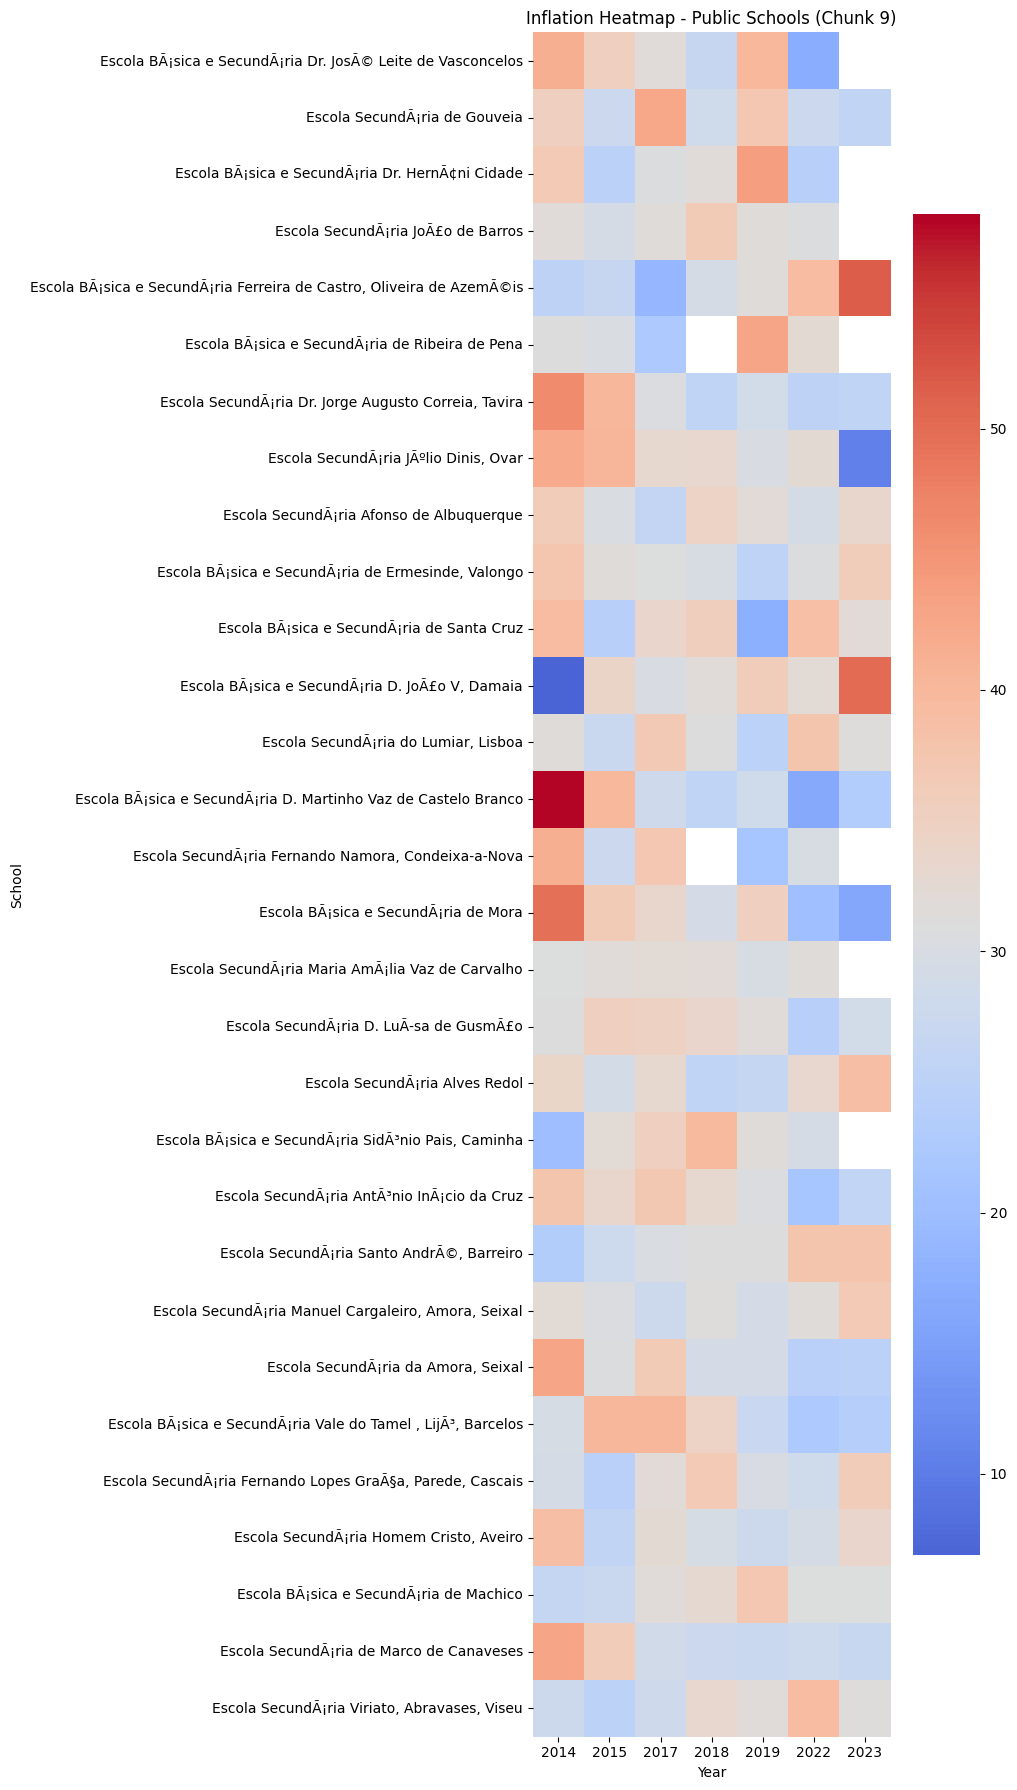

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.draw()
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


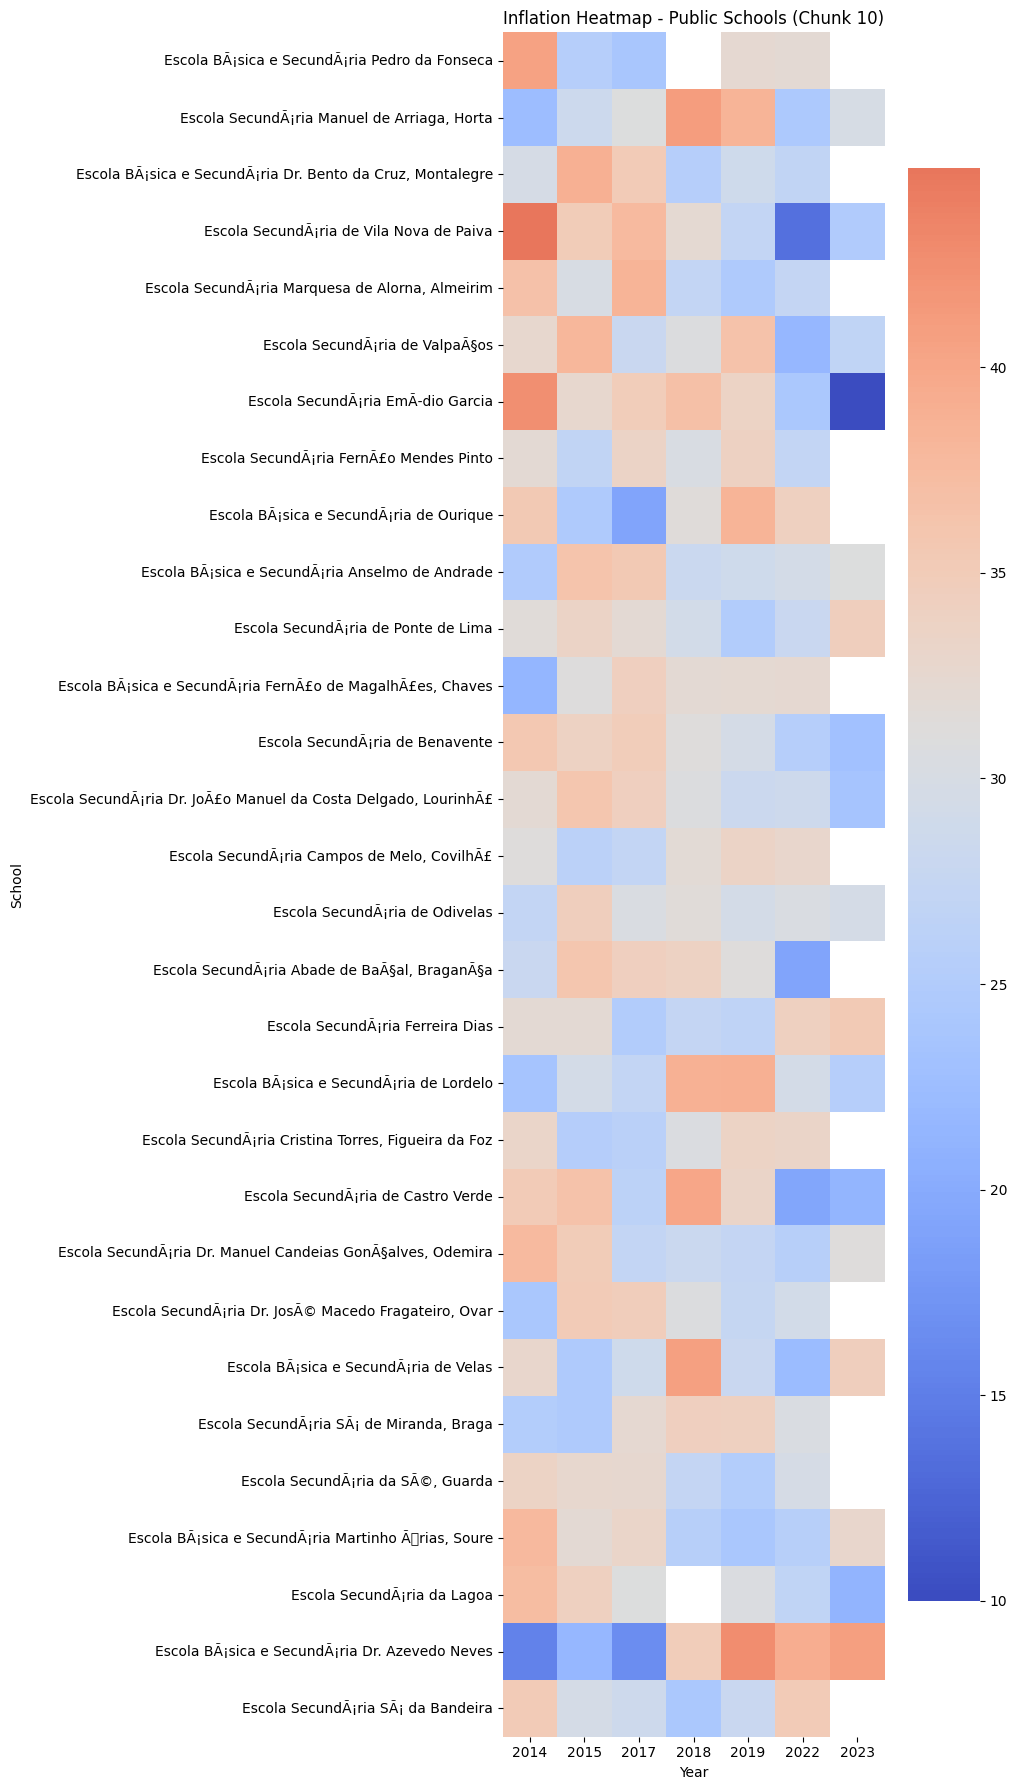

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.draw()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 141 (\x8d) missing from current font.
  fig.canvas.draw()
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 141 (\x8d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


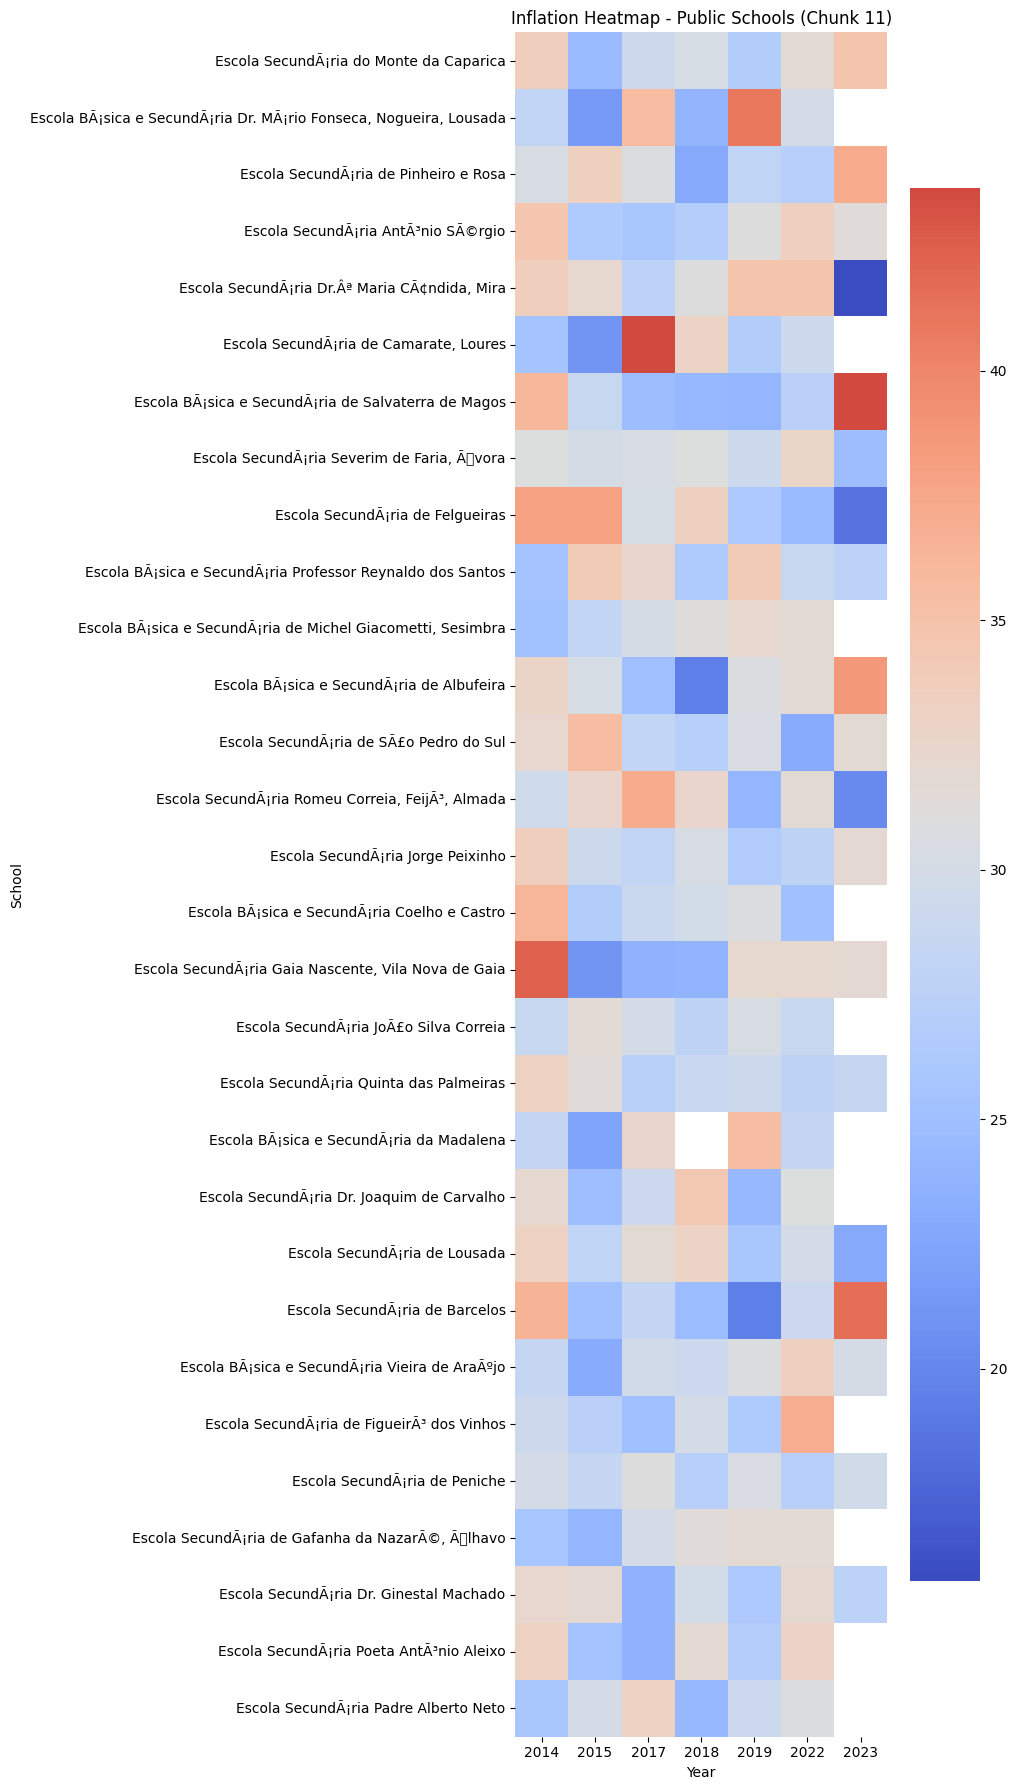

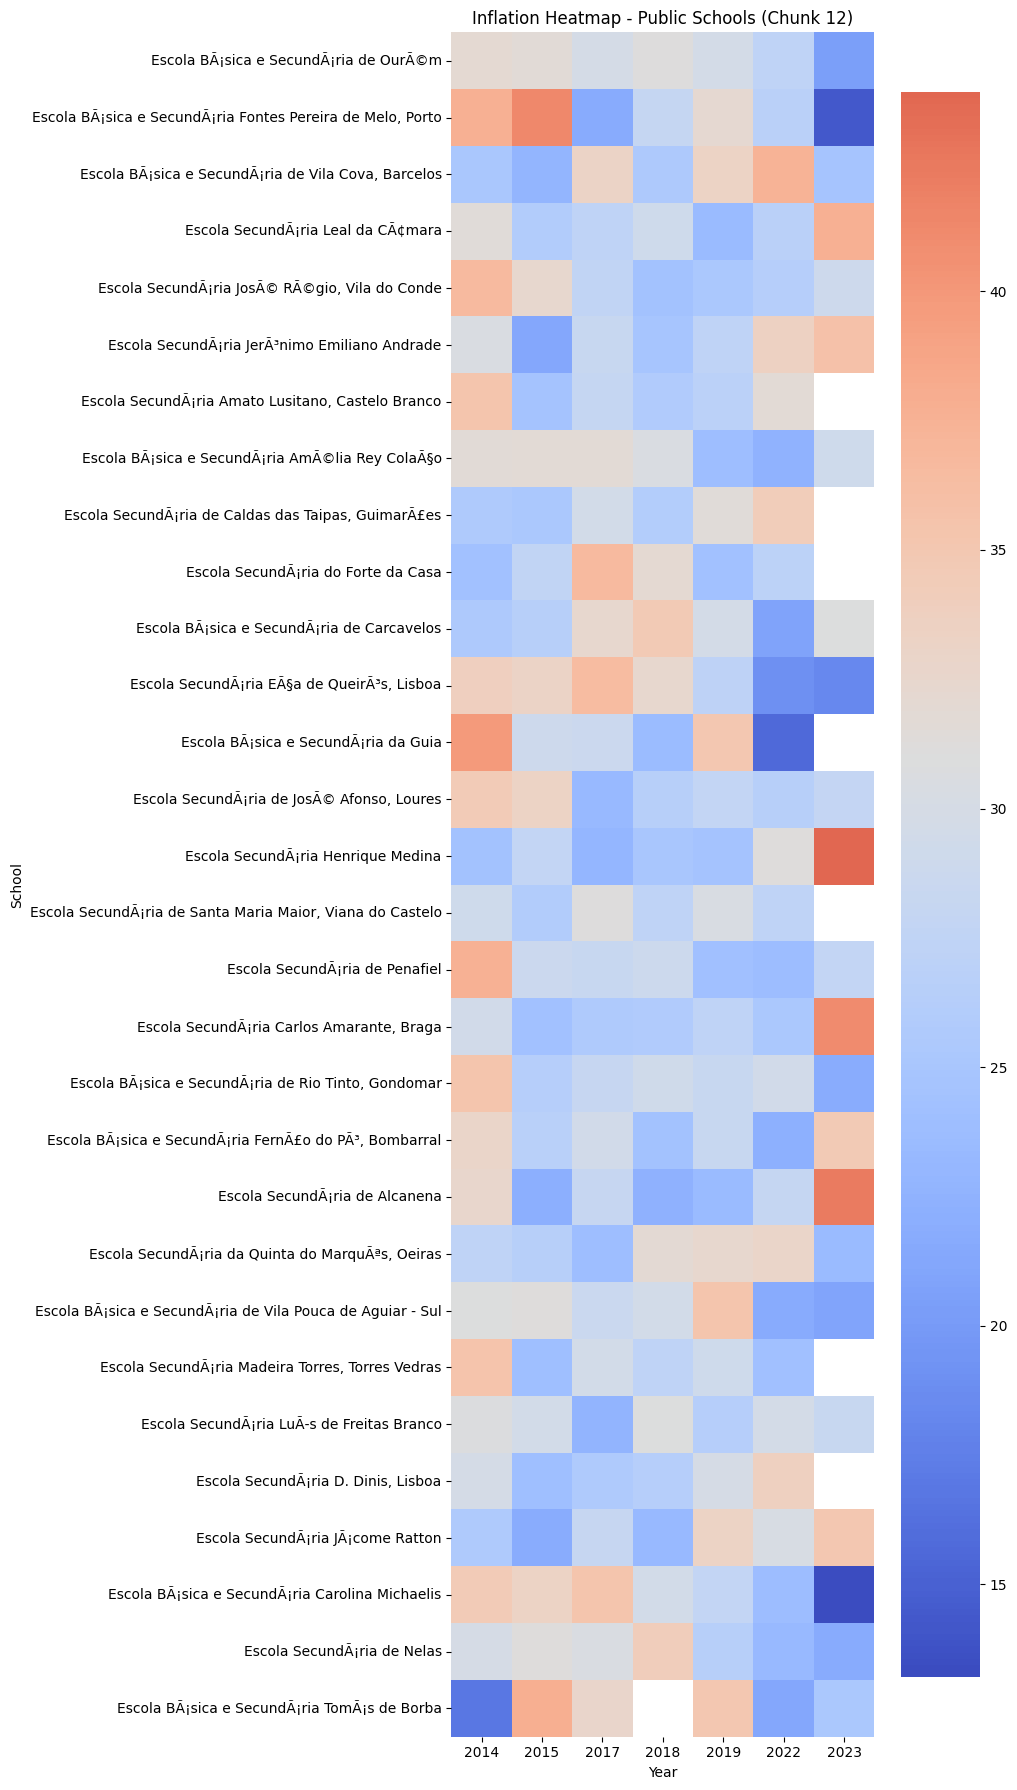

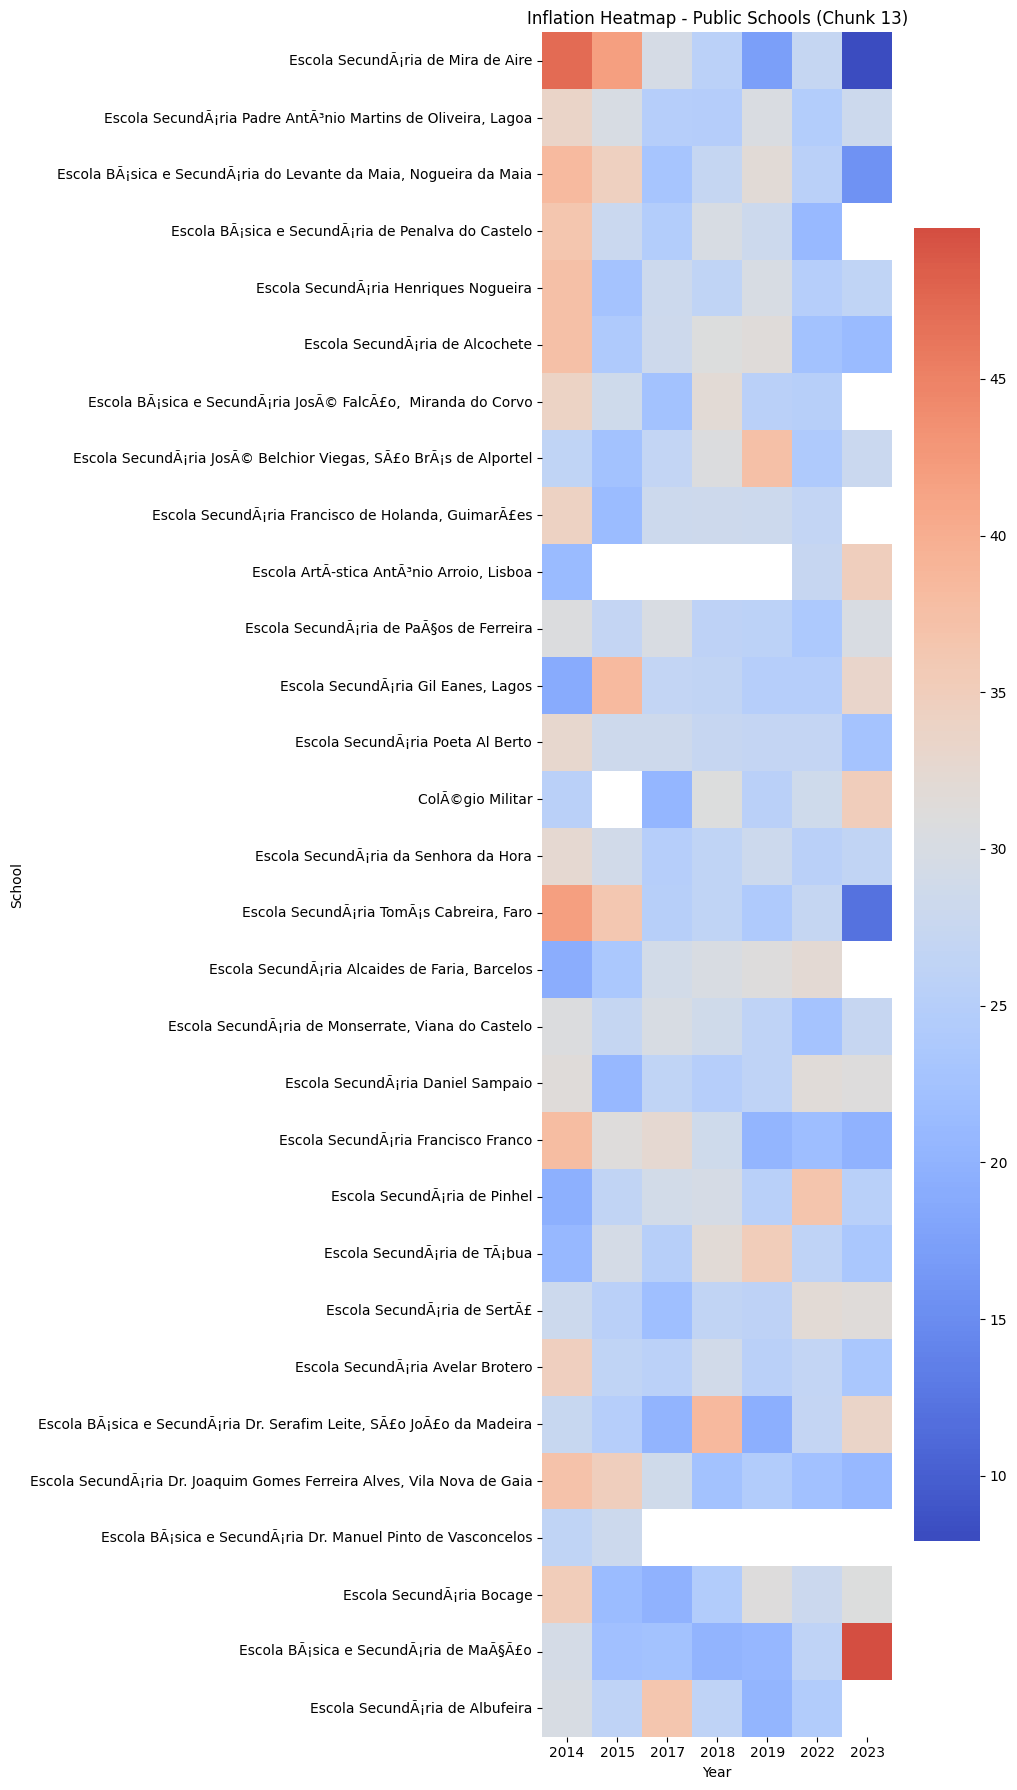

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.draw()
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


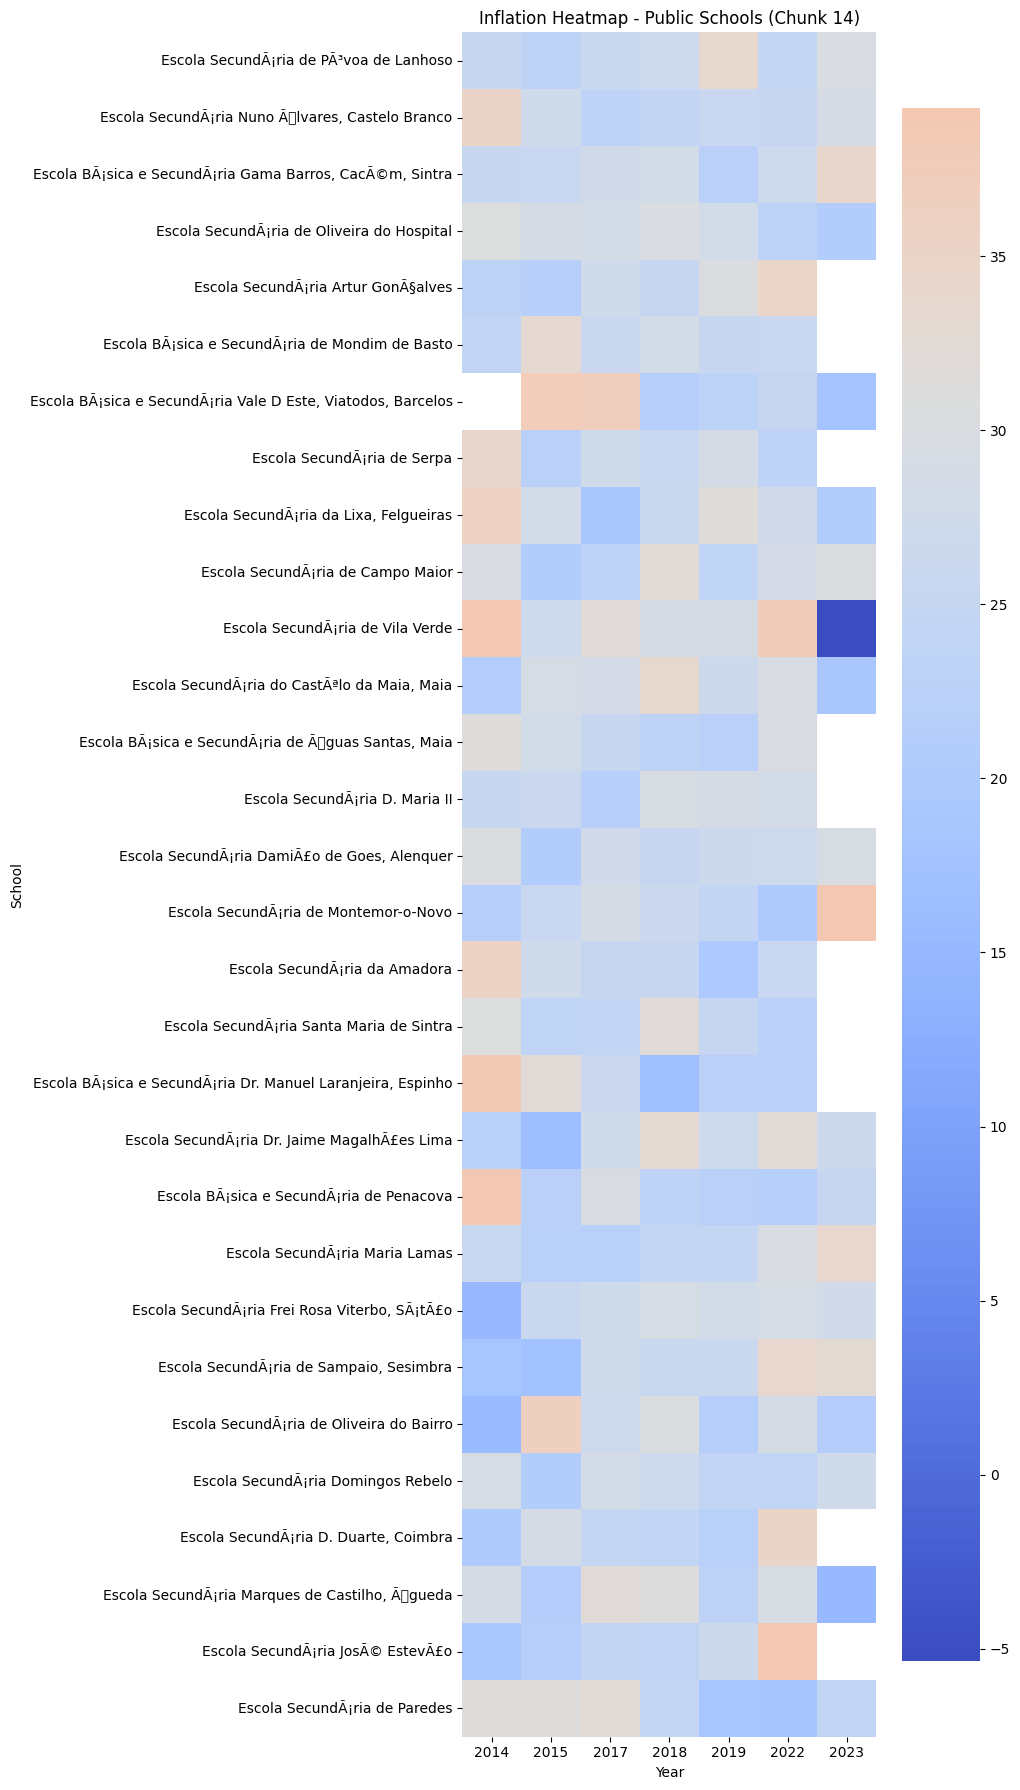

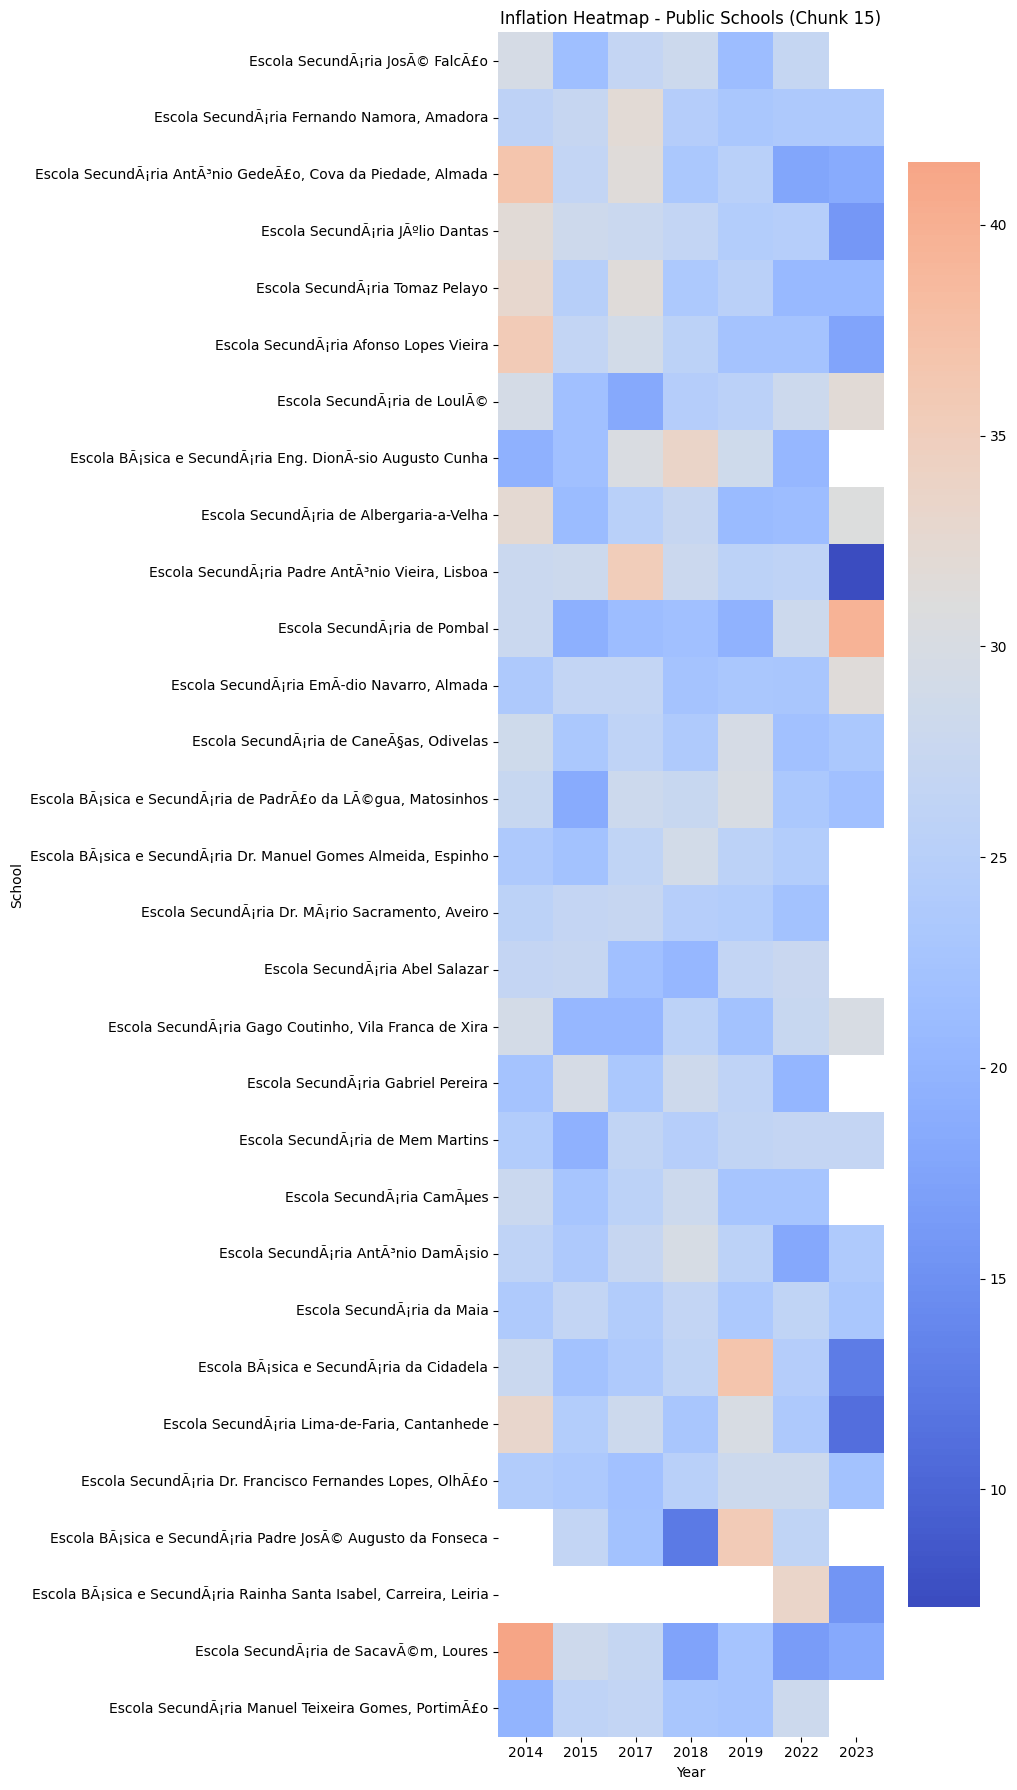

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.draw()
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


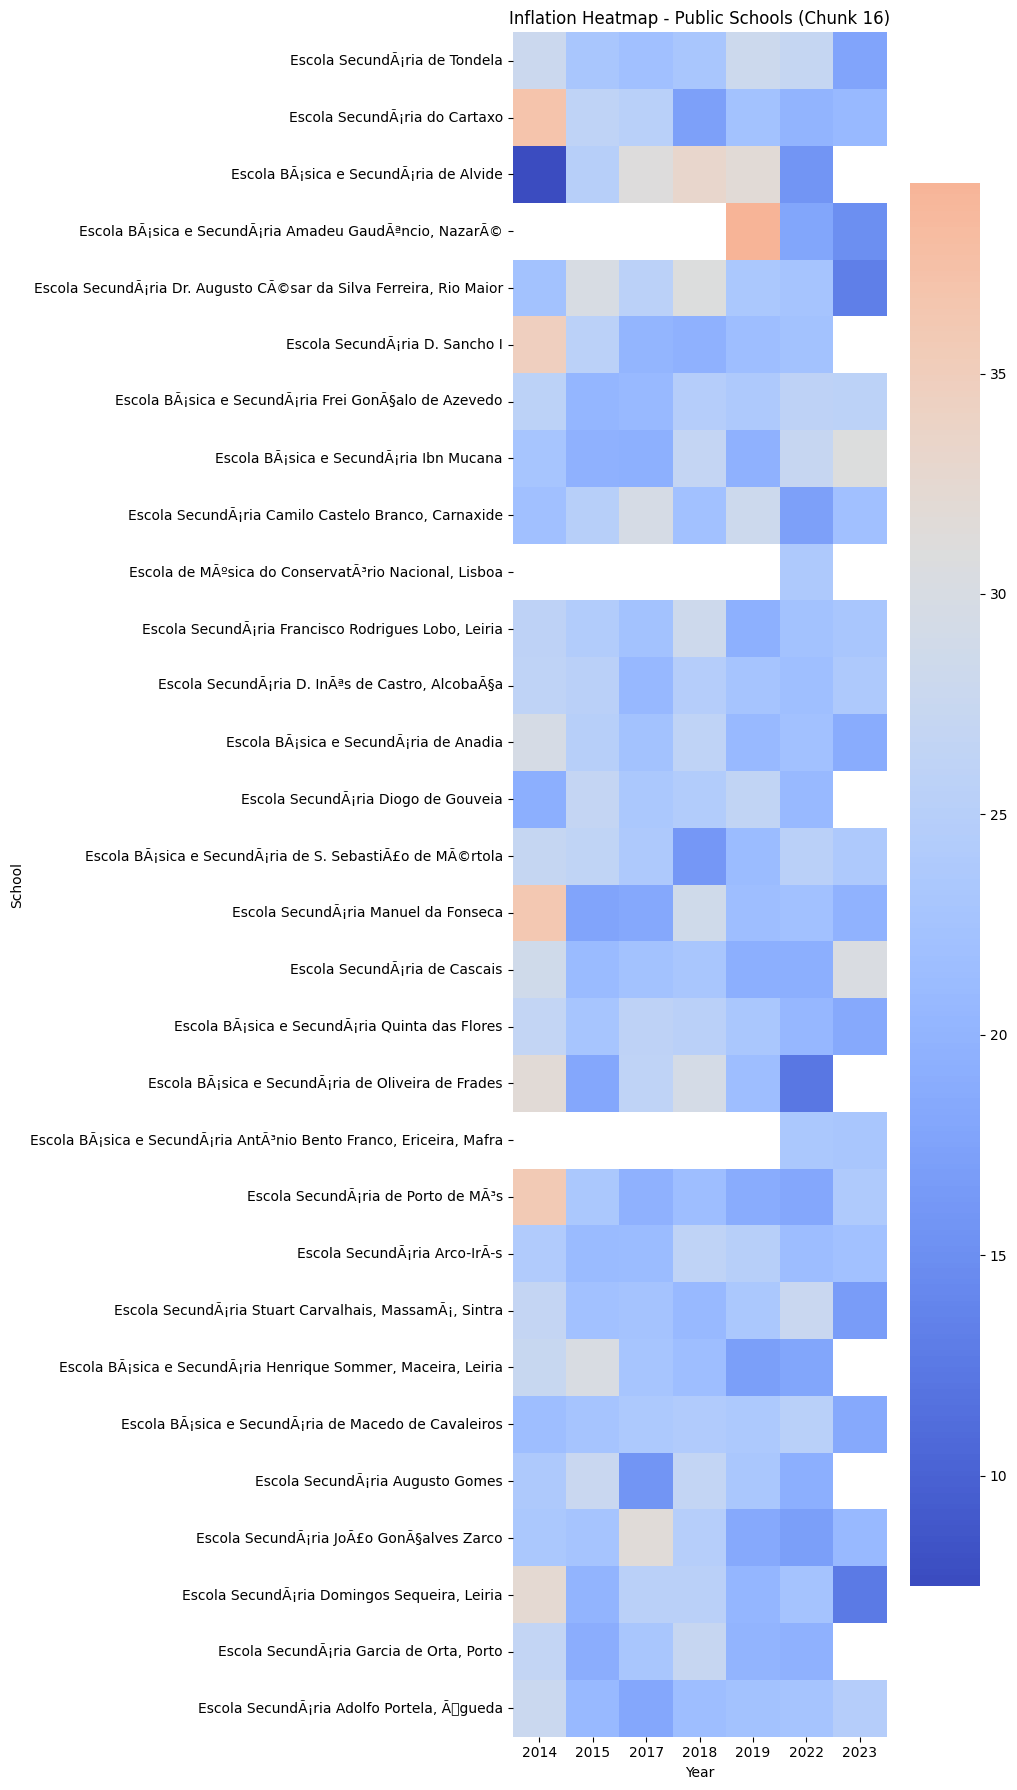

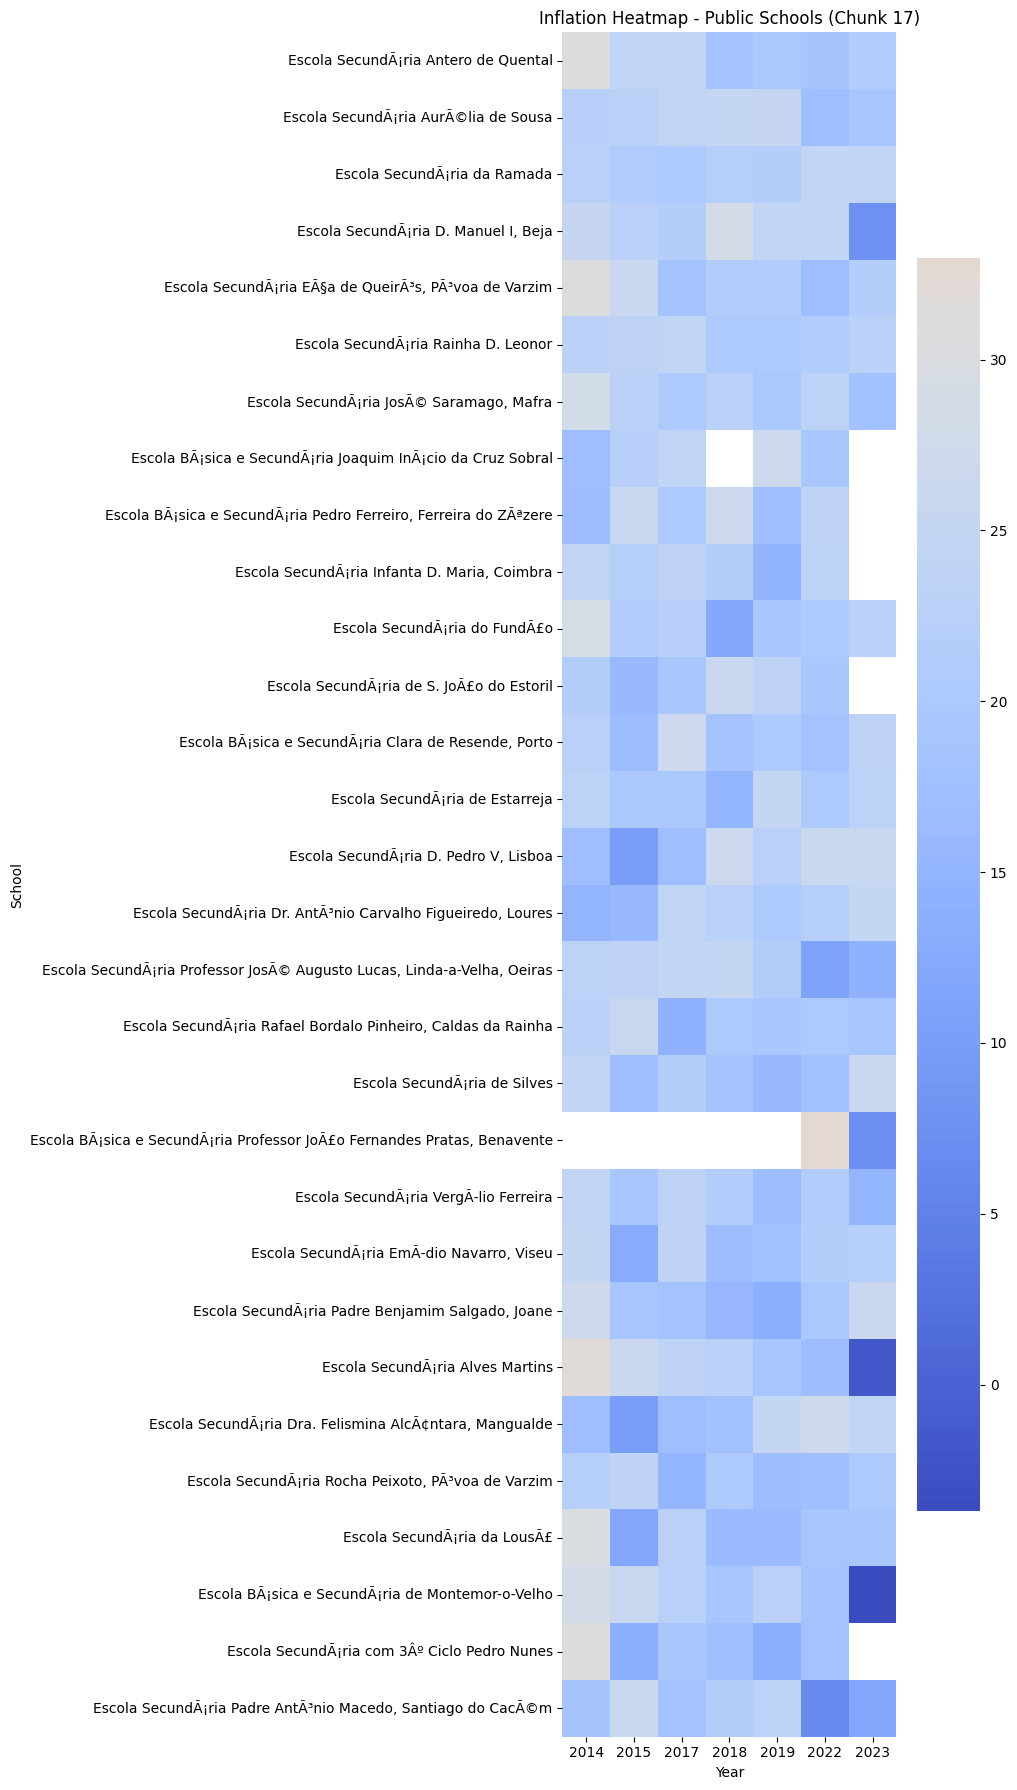

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 147 (\x93) missing from current font.
  fig.canvas.draw()
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 147 (\x93) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


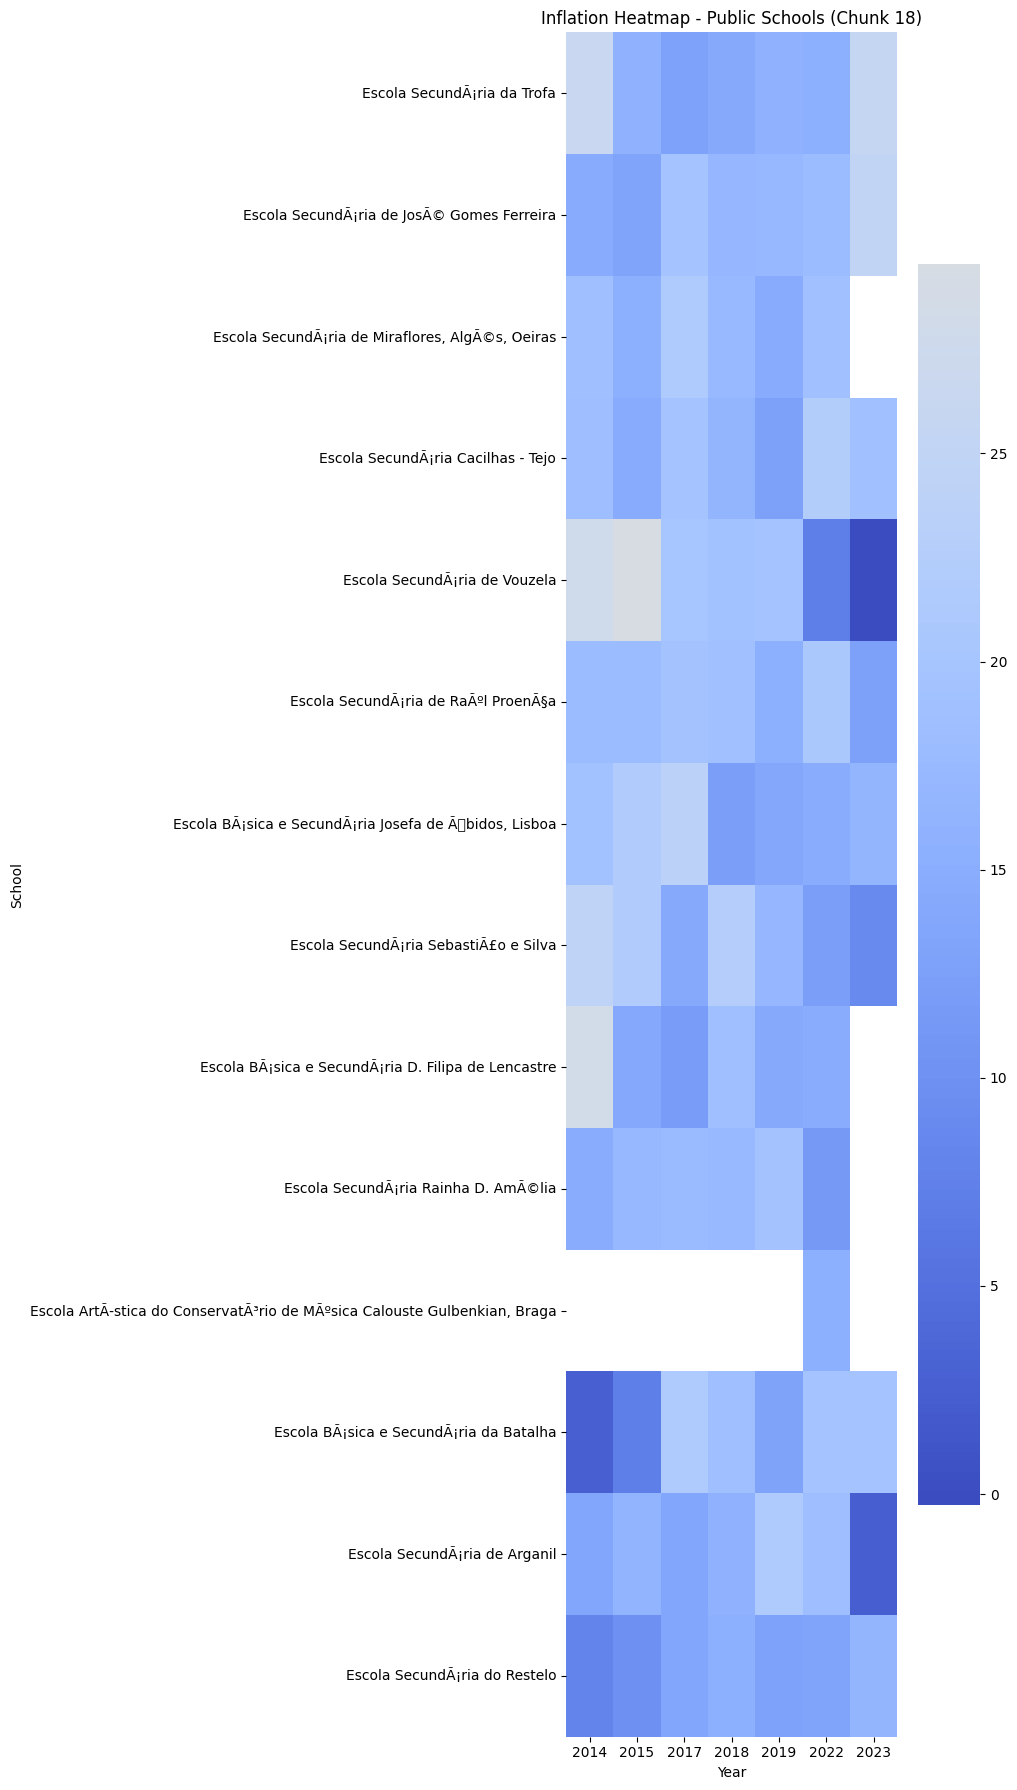

Escolas privadas:


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.draw()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.draw()
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


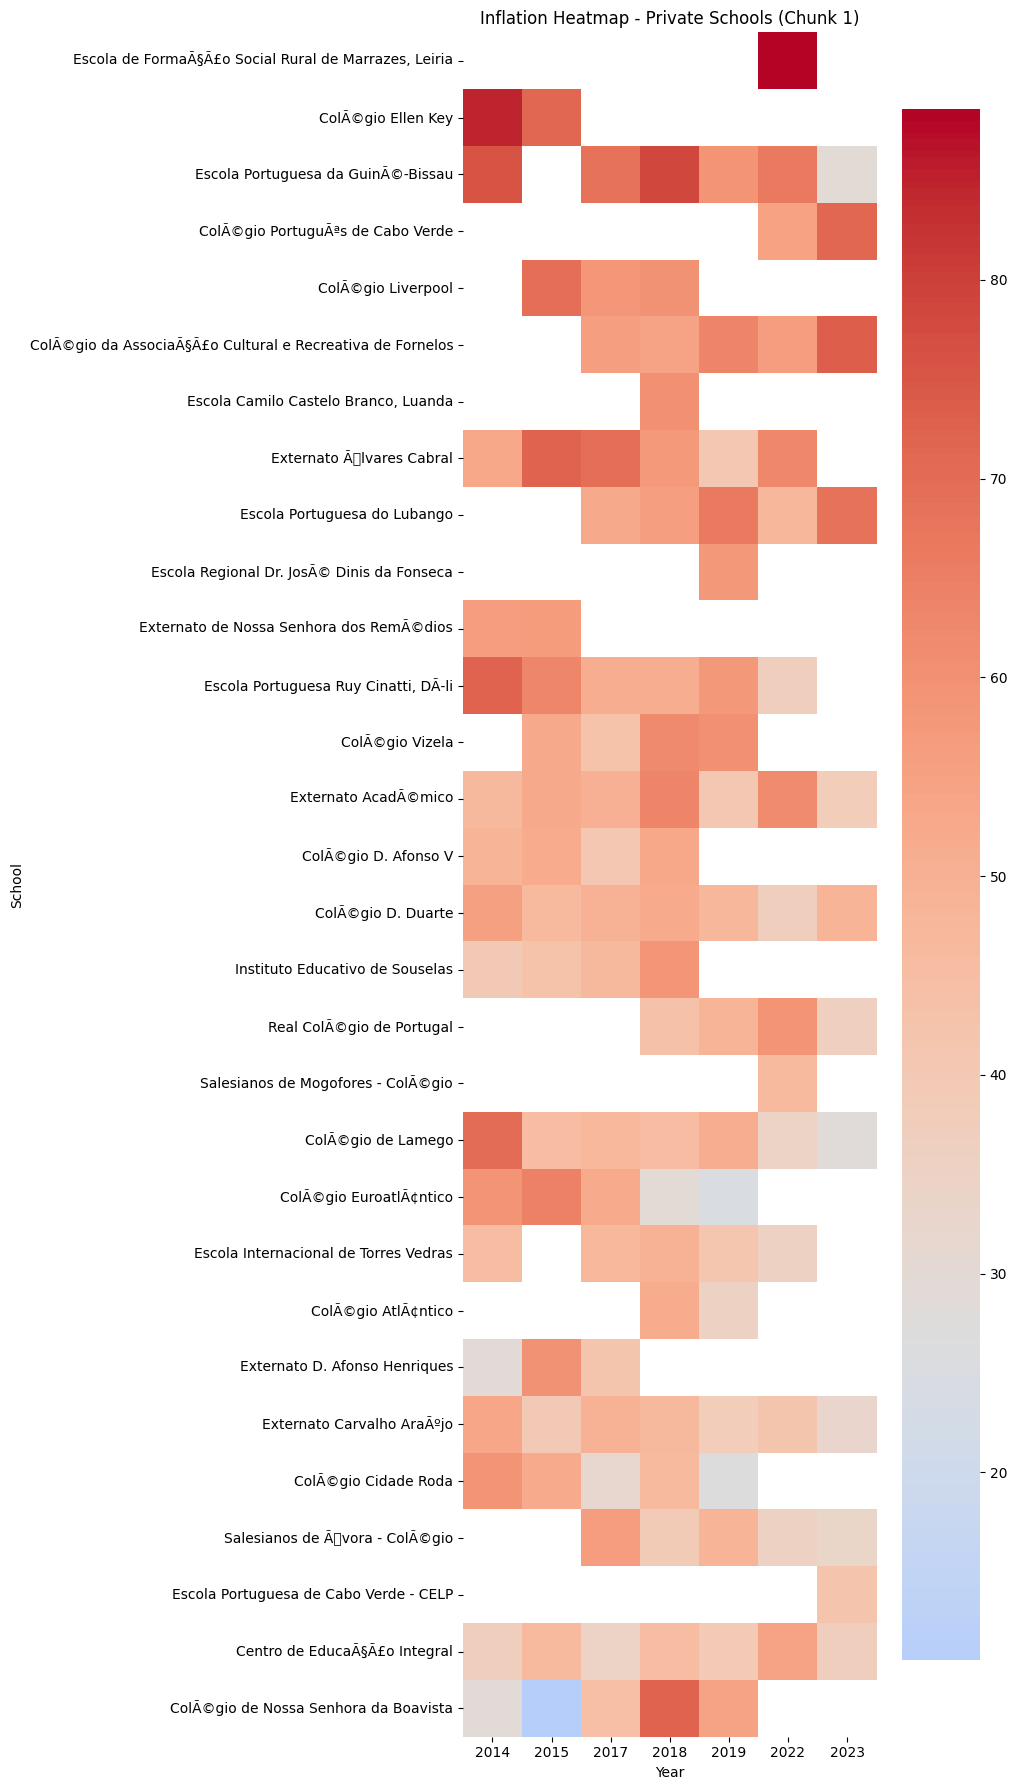

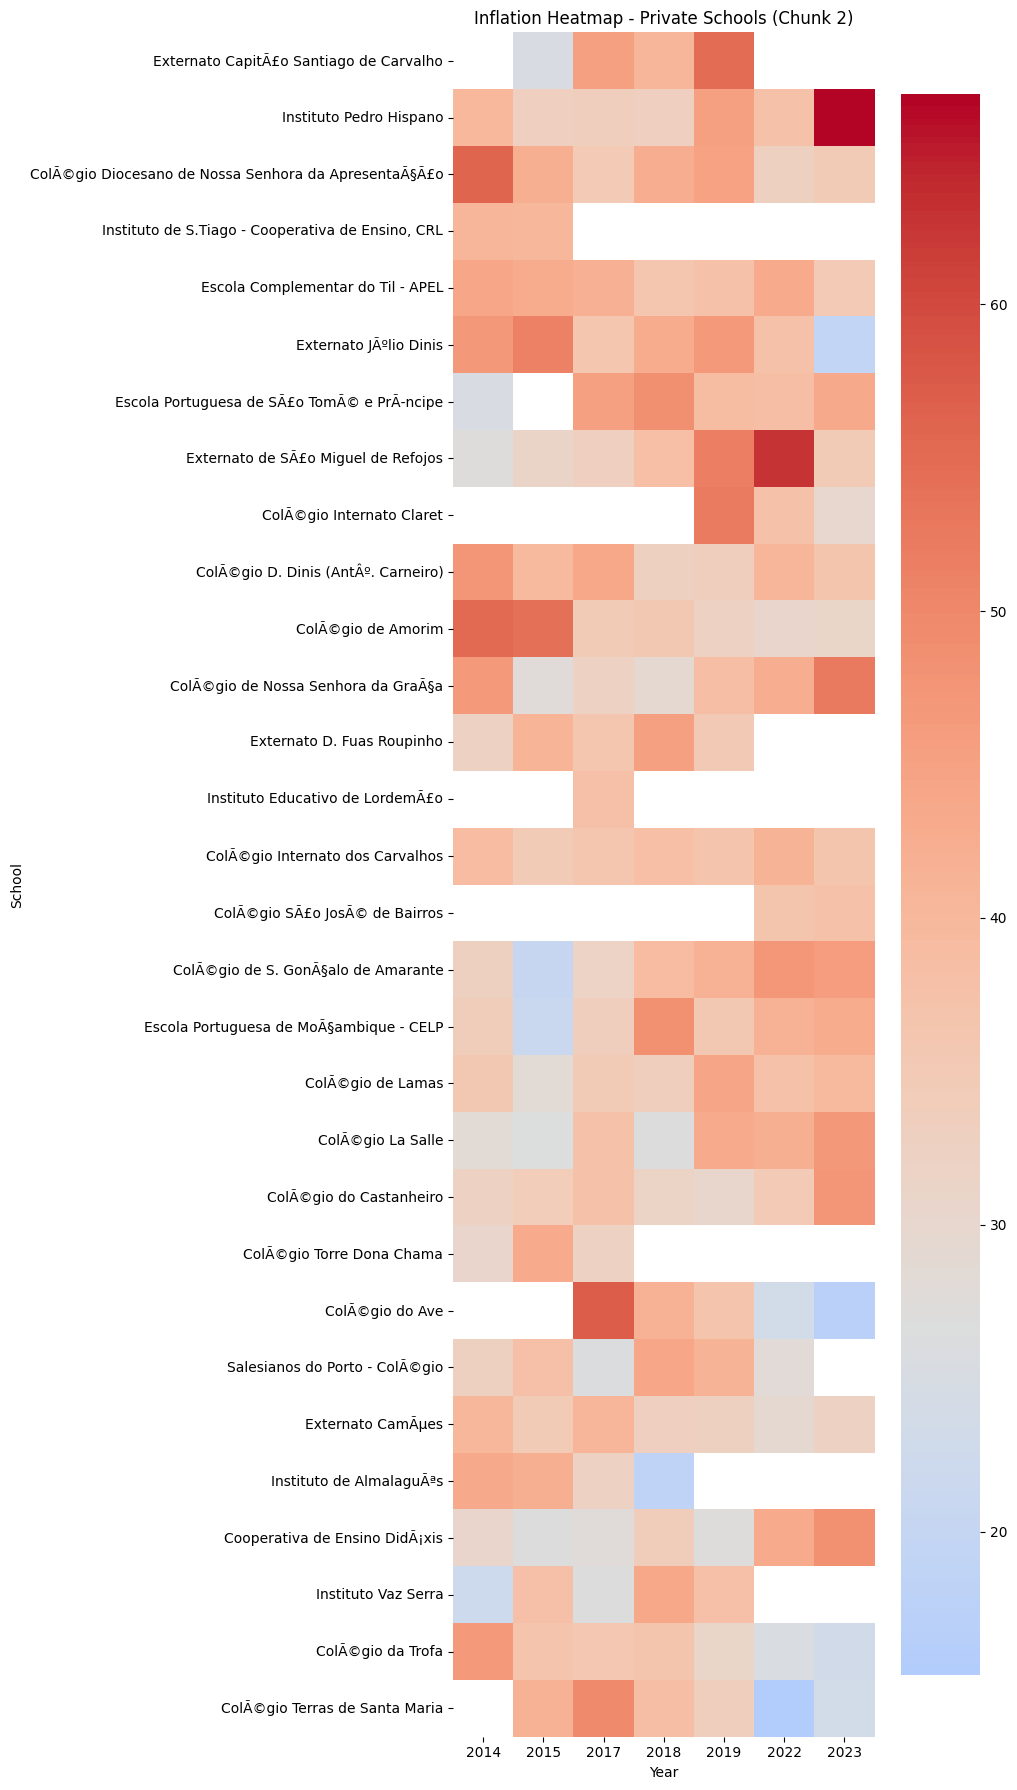

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.draw()
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


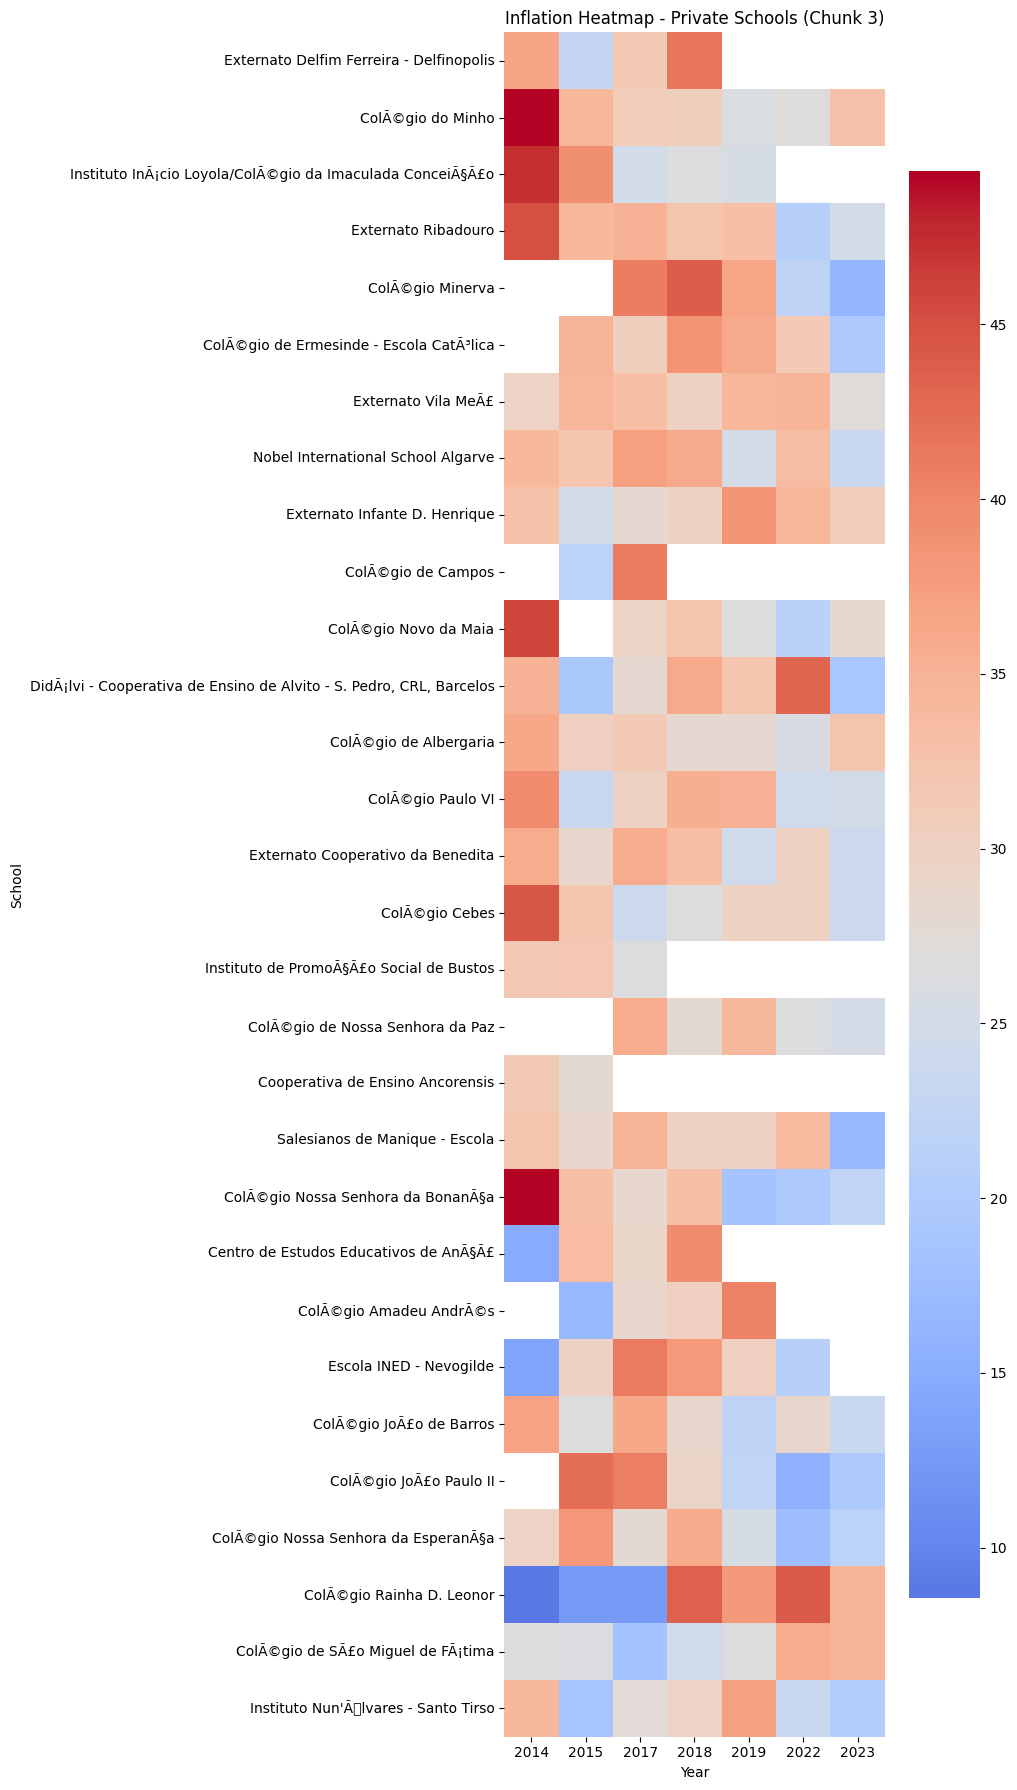

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.draw()
/Users/evicten/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


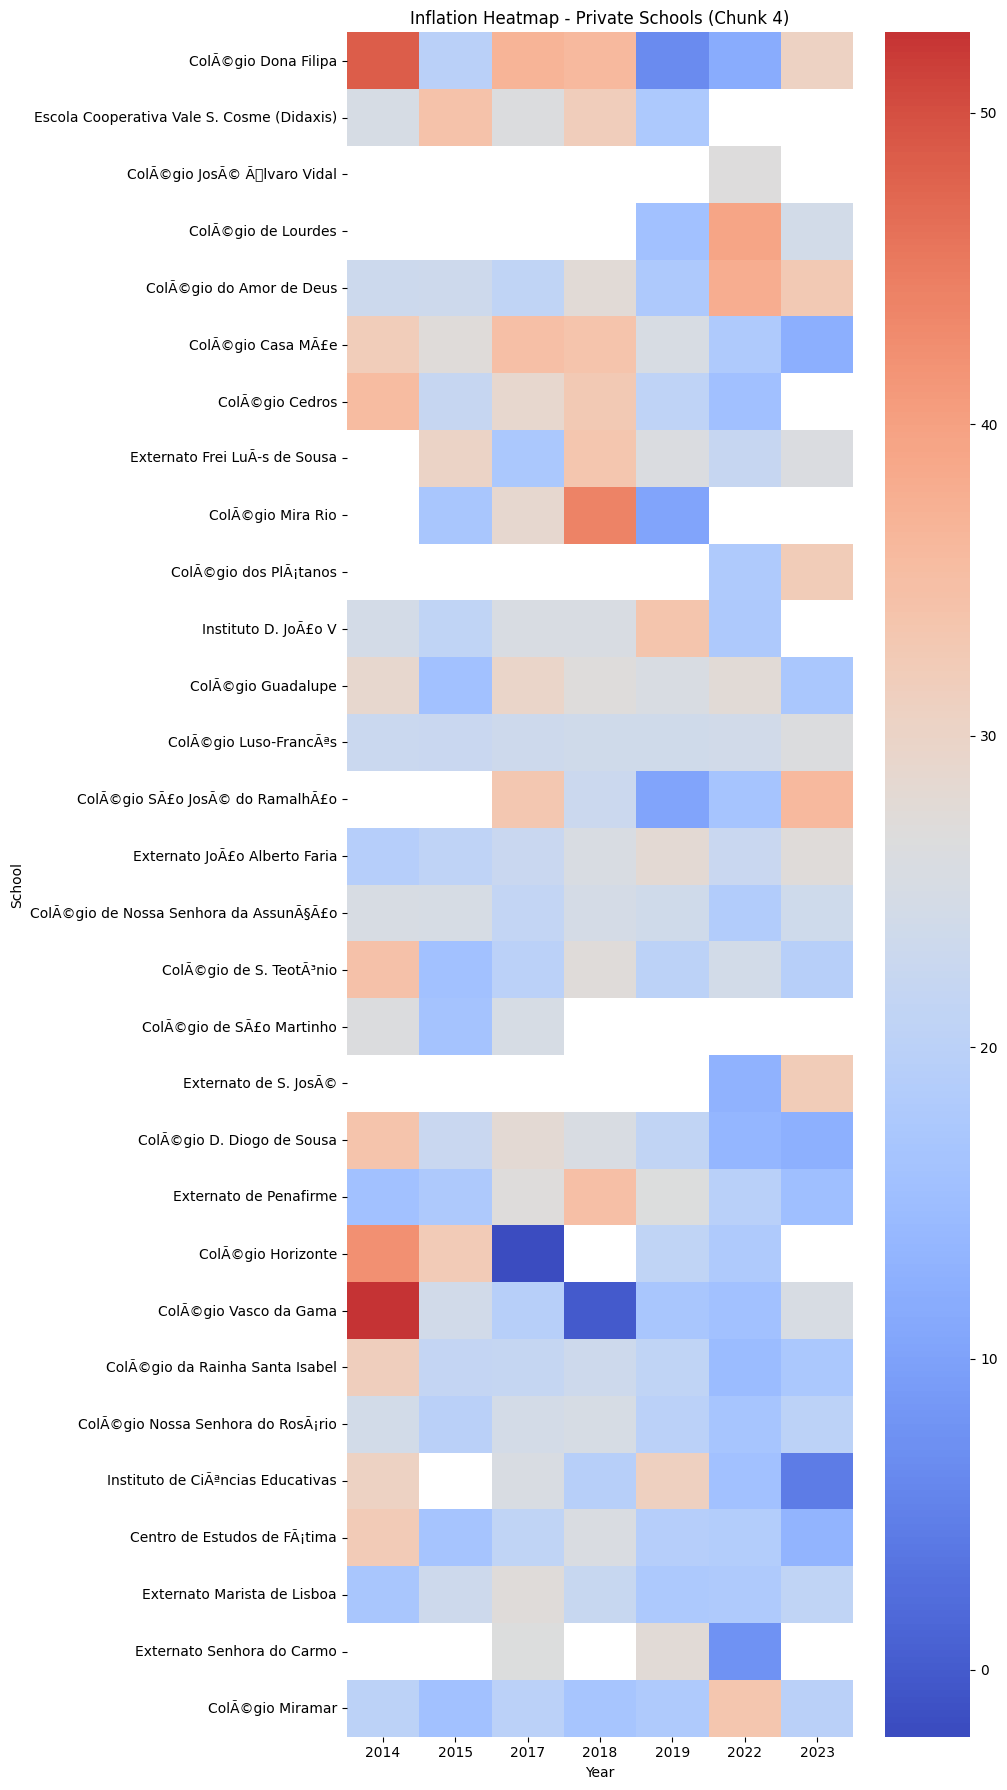

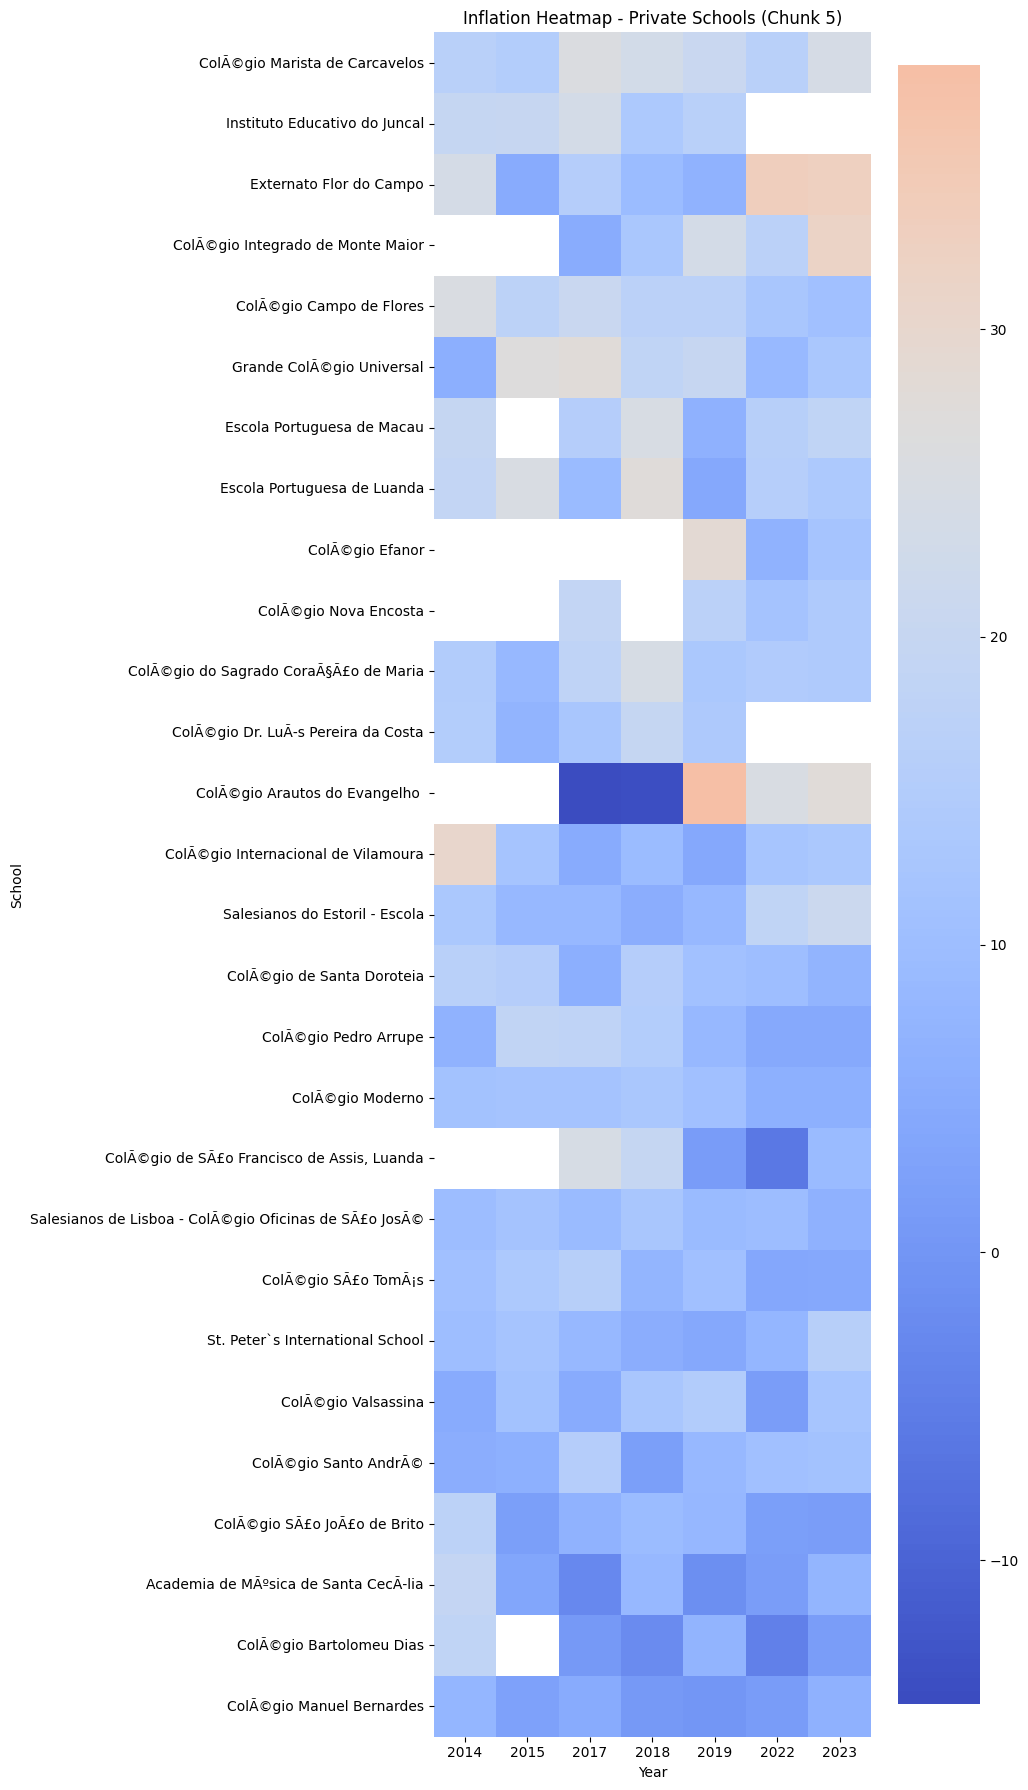

In [73]:
# Step 1: Total inflation per school
mean_inflation_pub = inflation_pivot_pub.mean(axis=1)
mean_inflation_pri = inflation_pivot_pri.mean(axis=1)

# Step 2: Sort schools by total inflation descending
sorted_schools_pub = mean_inflation_pub.sort_values(ascending=False).index
sorted_schools_pri = mean_inflation_pri.sort_values(ascending=False).index

# Step 3: Map codes to names
school_name_map = codigos_escolas_distritos.set_index("escola")["escola_descr"].to_dict()

# Step 4: Reindex to sorted order
sorted_pivot_pub = inflation_pivot_pub.loc[sorted_schools_pub]
sorted_pivot_pri = inflation_pivot_pri.loc[sorted_schools_pri]

# Step 5: Replace index with school names
sorted_pivot_pub.index = sorted_pivot_pub.index.map(lambda code: school_name_map.get(code, str(code)))
sorted_pivot_pri.index = sorted_pivot_pri.index.map(lambda code: school_name_map.get(code, str(code)))

# Step 6: Split into chunks using NumPy
chunk_size = 30
num_chunks_pub = int(np.ceil(len(sorted_pivot_pub) / chunk_size))
num_chunks_pri = int(np.ceil(len(sorted_pivot_pri) / chunk_size))
# Step 7: Plot each chunk

print("Escolas públicas:")

for i in range(num_chunks_pub):
    chunk = sorted_pivot_pub.iloc[i*chunk_size:(i+1)*chunk_size]
    
    plt.figure(figsize=(10, 18))
    sns.heatmap(
        chunk, 
        cmap="coolwarm", 
        center=inflation_pivot_pub_clean.mean().mean(),
        annot=False,
        yticklabels=True
    )
    plt.title(f"Inflation Heatmap - Public Schools (Chunk {i+1})")
    plt.xlabel("Year")
    plt.ylabel("School")
    plt.tight_layout()
    plt.show()

print("Escolas privadas:")
for i in range(num_chunks_pri):
    chunk = sorted_pivot_pri.iloc[i*chunk_size:(i+1)*chunk_size]
    
    plt.figure(figsize=(10, 18))
    sns.heatmap(
        chunk, 
        cmap="coolwarm", 
        center=inflation_pivot_pri_clean.mean().mean(),
        annot=False,
        yticklabels=True
    )
    plt.title(f"Inflation Heatmap - Private Schools (Chunk {i+1})")
    plt.xlabel("Year")
    plt.ylabel("School")
    plt.tight_layout()
    plt.show()


The above is still subject to simpson's paradox, but we dont necessarily need to account for it since we are not comparing 

In [ ]:


# Create pivot tables
inflation_pivot_pub = public_schools.pivot_table(index="ESCOLA", columns="ANO", values="INFLACAO", aggfunc="mean")
inflation_pivot_pri = private_schools.pivot_table(index="ESCOLA", columns="ANO", values="INFLACAO", aggfunc="mean")

# Create figure
# Create a figure for Public Schools
plt.figure(figsize=(10, 6))
sns.heatmap(
    inflation_pivot_pub, 
    cmap="coolwarm", 
    center=inflation_pivot_pub.mean().mean(), 
    annot=False
)
plt.title("Inflation Heatmap - Public Schools")
plt.xlabel("Year")
plt.ylabel("School")
plt.show()  # Show first plot

# Create a figure for Private Schools
plt.figure(figsize=(10, 6))
sns.heatmap(
    inflation_pivot_pri, 
    cmap="coolwarm", 
    center=inflation_pivot_pri.mean().mean(),  # Center based on private schools
    annot=False
)
plt.title("Inflation Heatmap - Private Schools")
plt.xlabel("Year")
plt.ylabel("School")
plt.show()  # Show second plot

Spearman Correlation - Public Schools:
ANO       2014      2015      2016      2017      2018      2019      2022  \
ANO                                                                          
2014  1.000000  0.654575  0.355815  0.524589  0.507264  0.538605  0.340722   
2015  0.654575  1.000000  0.424471  0.563284  0.615461  0.625893  0.388188   
2016  0.355815  0.424471  1.000000  0.407530  0.432014  0.317770  0.162411   
2017  0.524589  0.563284  0.407530  1.000000  0.610996  0.488076  0.453296   
2018  0.507264  0.615461  0.432014  0.610996  1.000000  0.745403  0.492497   
2019  0.538605  0.625893  0.317770  0.488076  0.745403  1.000000  0.497280   
2022  0.340722  0.388188  0.162411  0.453296  0.492497  0.497280  1.000000   
2023  0.233436  0.262378  0.176239  0.249980  0.401568  0.395947  0.559556   

ANO       2023  
ANO             
2014  0.233436  
2015  0.262378  
2016  0.176239  
2017  0.249980  
2018  0.401568  
2019  0.395947  
2022  0.559556  
2023  1.000000  

Spearman 

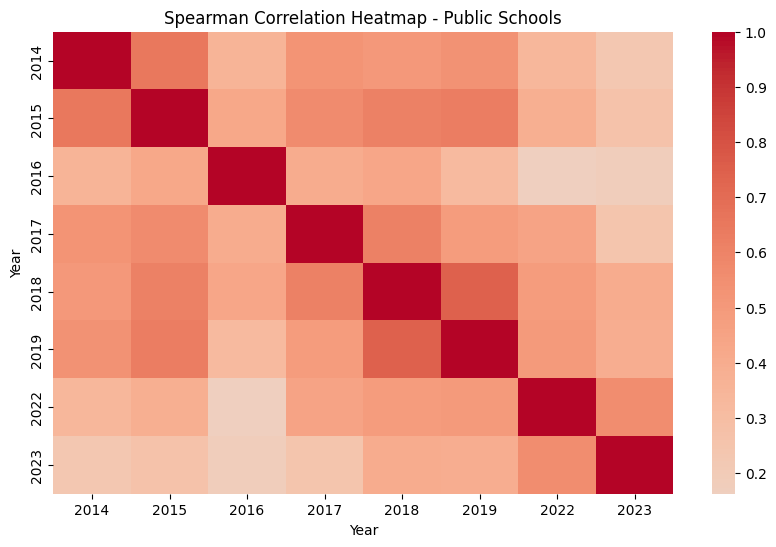

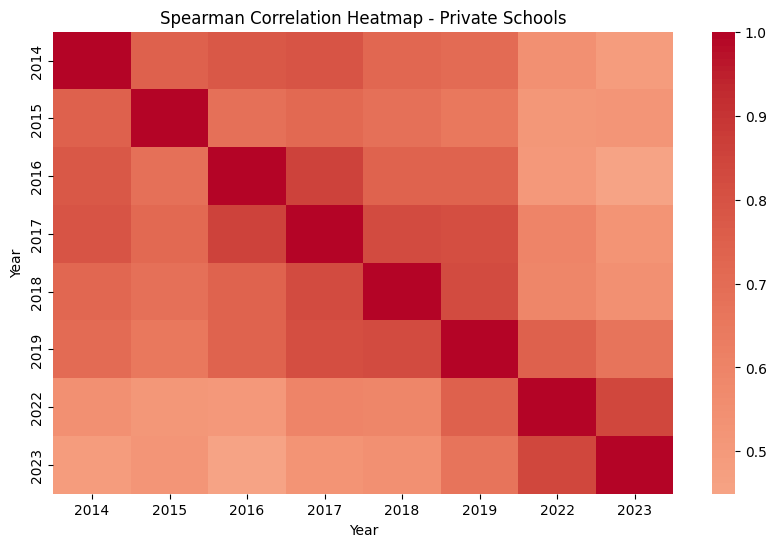

In [41]:
# Compute Spearman correlation for Public Schools
spearman_corr_pub = inflation_pivot_pub_clean.corr(method="spearman")

# Compute Spearman correlation for Private Schools
spearman_corr_pri = inflation_pivot_pri_clean.corr(method="spearman")

# Display the Spearman correlation matrices
print("Spearman Correlation - Public Schools:")
print(spearman_corr_pub)

print("\nSpearman Correlation - Private Schools:")
print(spearman_corr_pri)

# Create a figure for Public Schools
plt.figure(figsize=(10, 6))
sns.heatmap(
    spearman_corr_pub, 
    cmap="coolwarm", 
    center=0,  # Center based on the correlation matrix
    annot=False
)
plt.title("Spearman Correlation Heatmap - Public Schools")
plt.xlabel("Year")
plt.ylabel("Year")
plt.show()  # Show first plot
# Create a figure for Private Schools
plt.figure(figsize=(10, 6))
sns.heatmap(
    spearman_corr_pri, 
    cmap="coolwarm", 
    center=0,  # Center based on the correlation matrix
    annot=False
)
plt.title("Spearman Correlation Heatmap - Private Schools")
plt.xlabel("Year")
plt.ylabel("Year")
plt.show()  # Show second plot
# Create a figure for Public Schools


# Inflação por disciplina

In [40]:
print(disciplina.head())

            GROUP PUBPRIV  EXAME  INFLACAO    INF_STD  NSAMPLES  \
0    [60.0, 70.0)     PUB    126    11.750  54.328476         4   
1   [90.0, 100.0)     PUB    126    23.000  28.011902         4   
2  [100.0, 110.0)     PUB    126    16.600  21.972710         5   
3  [110.0, 120.0)     PUB    126     7.750  18.355290         4   
4  [100.0, 110.0)     PUB    127    -8.125  42.265952         8   

                  EXAME_DESCR  
0  Geometria Descritiva A -NE  
1  Geometria Descritiva A -NE  
2  Geometria Descritiva A -NE  
3  Geometria Descritiva A -NE  
4   Literatura Portuguesa -NE  
